#0. Imports

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
!pip install feature_engine


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 8.7 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, fbeta_score, make_scorer, classification_report, confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from feature_engine.creation import CyclicalFeatures
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import optuna

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, datasets
import tqdm
import copy
from torchvision.io import read_image
import os
from torchmetrics import Accuracy
from torchsummary import summary

In [ ]:
SEED = 22
sns.set(rc={"figure.figsize":(12, 8)})


I'll try to fix seed to get simmilar results every time.

In [ ]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(12)

# 1. Regression part

Next 2 chapters were copied from previous HW.

## 1. Initial data preparation and EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/hw3/AirQualityUCI.csv', sep=';')
df.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

### Initaial data preparetion - dealing with types and standart nan values.

There are weird columns n the end, those are probaby false so i'll investigate and probably delete them.

In [ ]:
print(df.shape)
df.value_counts(['Unnamed: 15', 'Unnamed: 16'])

(9471, 17)


Series([], dtype: int64)

In [ ]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
df.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  
0  0,7578  
1  0,7255  
2  0,7502  
3  0,7867  
4  0,7888

In [ ]:
df.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

The fact that CO(GT), C6H6(GT), T, RH and AH are considered objects is due to the fact that they use ',' instead of '.'.

In [ ]:
df[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']]

CO(GT) C6H6(GT)     T    RH      AH
0       2,6     11,9  13,6  48,9  0,7578
1         2      9,4  13,3  47,7  0,7255
2       2,2      9,0  11,9  54,0  0,7502
3       2,2      9,2  11,0  60,0  0,7867
4       1,6      6,5  11,2  59,6  0,7888
...     ...      ...   ...   ...     ...
9466    NaN      NaN   NaN   NaN     NaN
9467    NaN      NaN   NaN   NaN     NaN
9468    NaN      NaN   NaN   NaN     NaN
9469    NaN      NaN   NaN   NaN     NaN
9470    NaN      NaN   NaN   NaN     NaN

[9471 rows x 5 columns]

In [ ]:
df[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']] = df[['CO(GT)','C6H6(GT)', 'T', 'RH', 'AH']].apply(lambda i: i.apply(lambda j: float(str(j).replace(',', '.'))))
 

In [ ]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  9357.000000  9357.000000  9357.000000  9357.000000    9357.000000   
mean    -34.207524  1048.990061  -159.090093     1.865683     894.595276   
std      77.657170   329.832710   139.789093    41.380206     342.333252   
min    -200.000000  -200.000000  -200.000000  -200.000000    -200.000000   
25%       0.600000   921.000000  -200.000000     4.000000     711.000000   
50%       1.500000  1053.000000  -200.000000     7.900000     895.000000   
75%       2.600000  1221.000000  -200.000000    13.600000    1105.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  9357.000000   9357.000000  9357.000000   9357.000000  9357.000000   
mean    168.616971    794.990168    58.148873   1391.479641   975.072032   
std     257.433866    321.993552   126.940455    467.210125   456.938184   
min    -200.000000   -200.000000  -200.000000   -200.000000  -200.000000   
25%      50.000000    637.000000    53.000000   1185.000000   700.000000   
50%     141.000000    794.000000    96.000000   1446.000000   942.000000   
75%     284.000000    960.000000   133.000000   1662.000000  1255.000000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean      9.778305    39.485380    -6.837604  
std      43.203623    51.216145    38.976670  
min    -200.000000  -200.000000  -200.000000  
25%      10.900000    34.100000     0.692300  
50%      17.200000    48.600000     0.976800  
75%      24.100000    61.900000     1.296200  
max      44.600000    88.700000     2.231000

In additional info about dataset is written that nan values are marked -200  and from above table i see that no negative values are meaningfull, so i can comvert them to nan.

In [ ]:
print(df[df == -200].count())
print(df[df == '-200'].count())
df = df.replace(-200, np.nan)

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64
Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


In [ ]:
print(df.isnull().sum())

Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64


Now let's convert date and time to datetime type. 
format:
0 Date (DD/MM/YYYY)
1 Time (HH.MM.SS)



In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df['Date']

0      2004-03-10
1      2004-03-10
2      2004-03-10
3      2004-03-10
4      2004-03-10
          ...    
9466          NaT
9467          NaT
9468          NaT
9469          NaT
9470          NaT
Name: Date, Length: 9471, dtype: datetime64[ns]

In [ ]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  8991.000000  8991.000000  8991.000000  
mean     18.317829    49.234201     1.025530  
std       8.832116    17.316892     0.403813  
min      -1.900000     9.200000     0.184700  
25%      11.800000    35.800000     0.736800  
50%      17.800000    49.600000     0.995400  
75%      24.400000    62.500000     1.313700  
max      44.600000    88.700000     2.231000

Different columns have very different scales so i'll definetely use scaling.

In [ ]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

### EDA

First of all I would like to have a look at the columns individually.

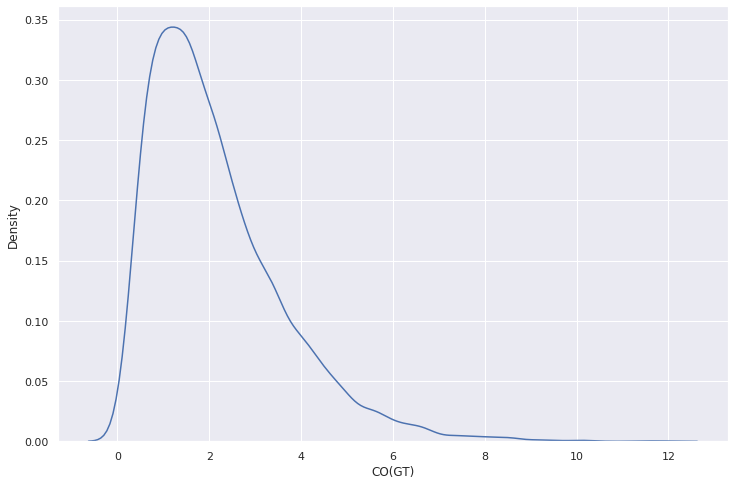

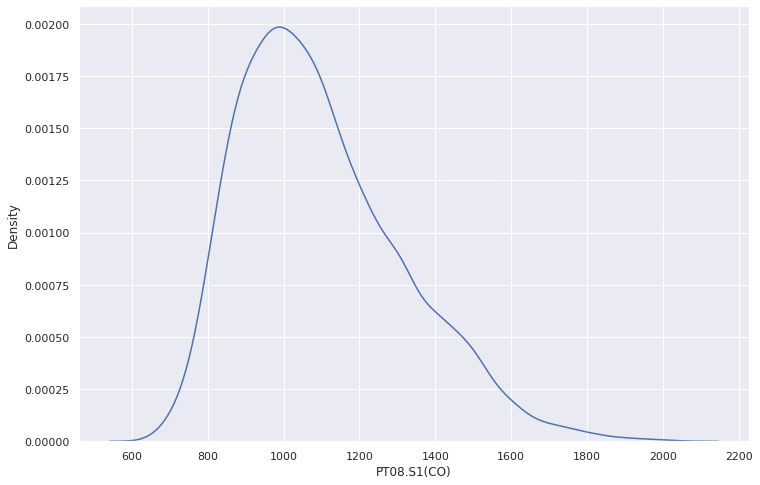

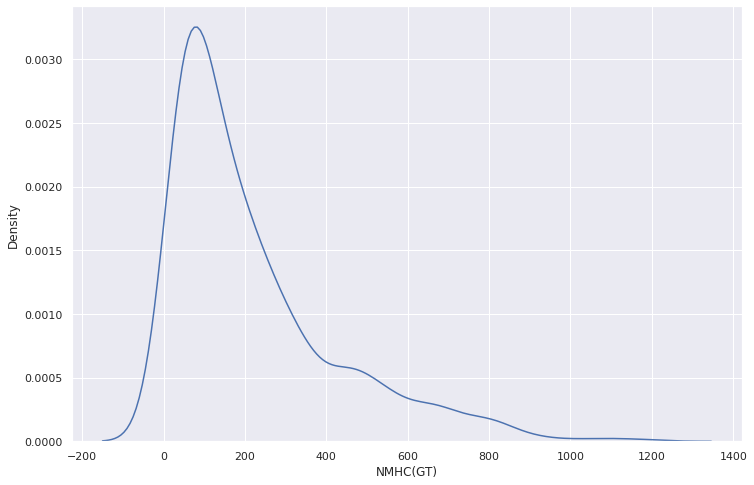

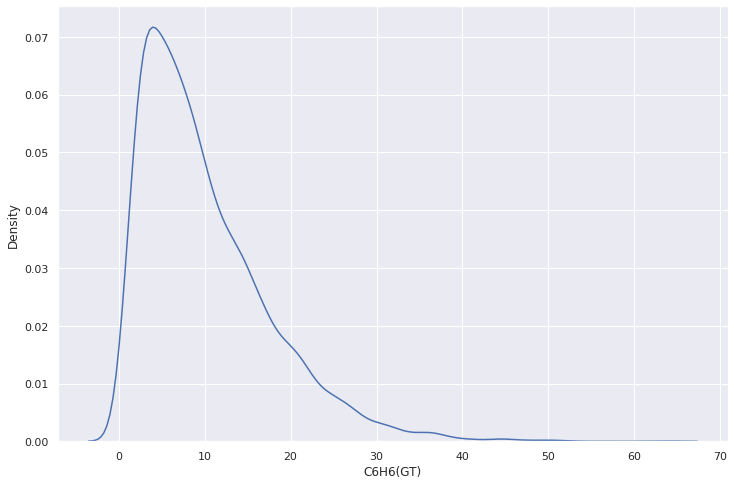

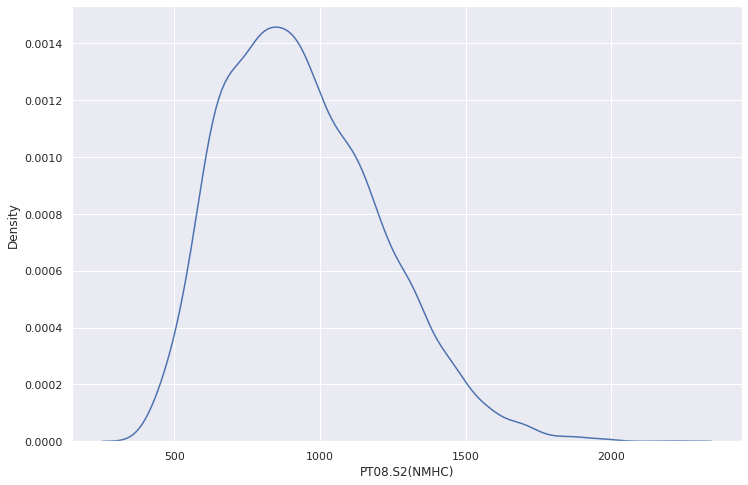

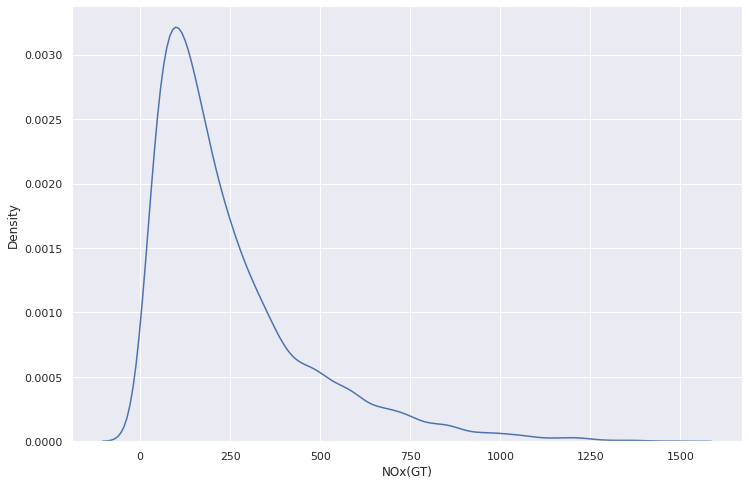

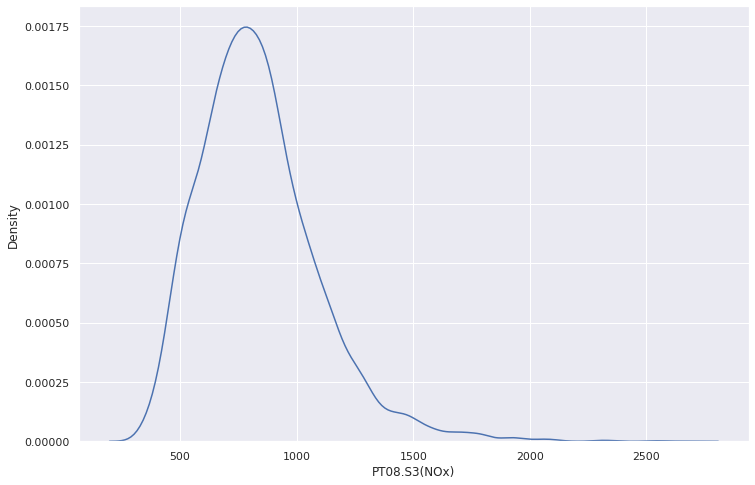

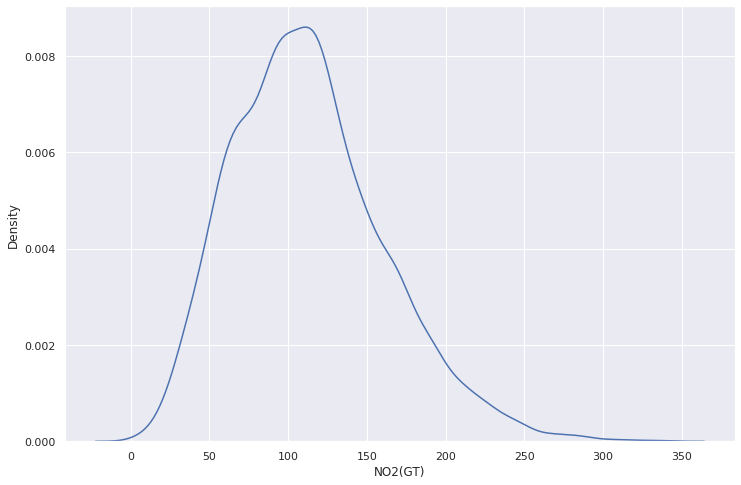

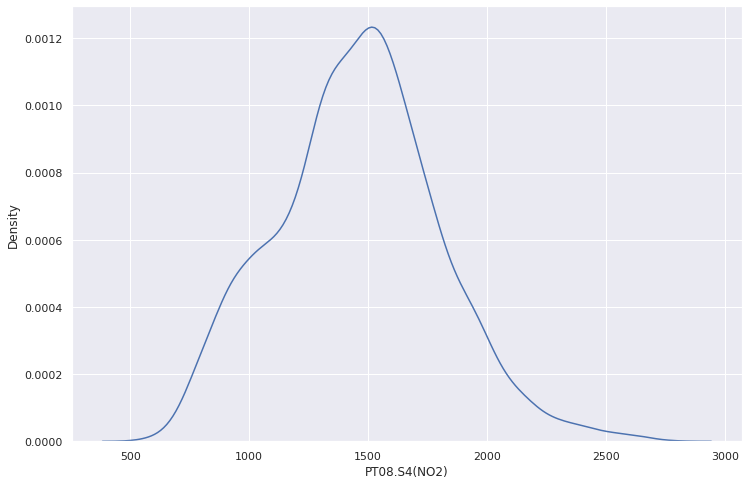

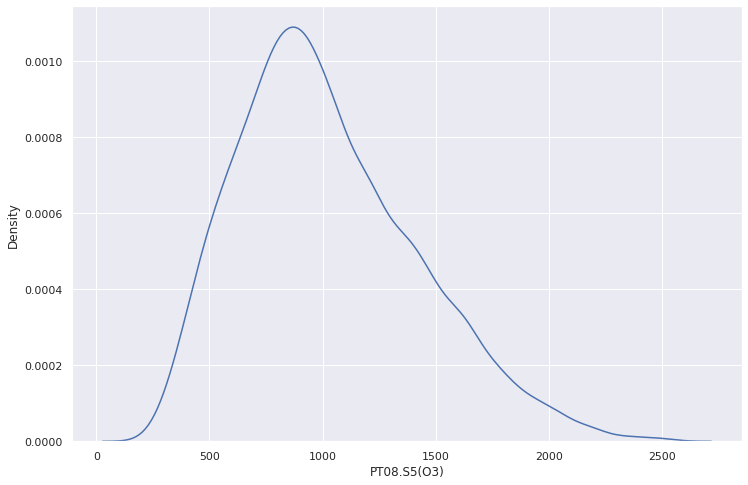

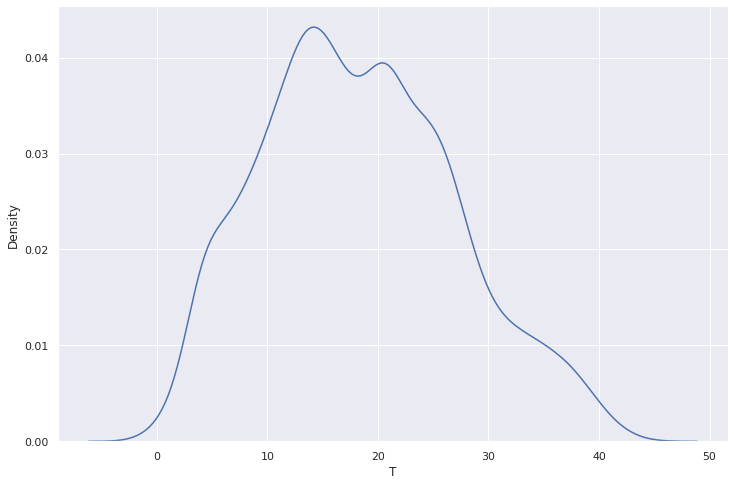

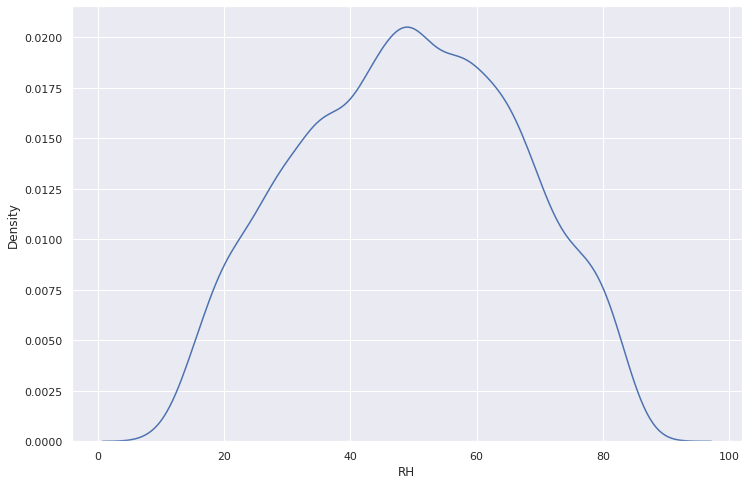

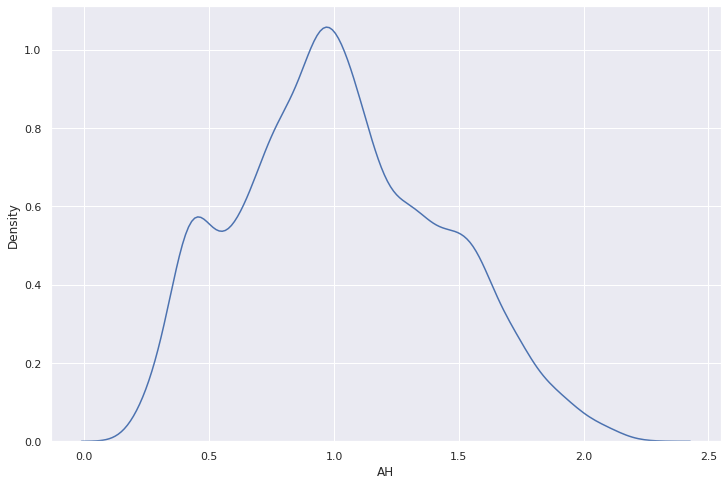

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
for col in df.columns:
  if df[col].dtype == 'float64':
    sns.kdeplot(data=df[col])
    plt.show(); 
    #plt.xticks(rotation = 90)
  

All the numeric variables seem to be normally-like distributed(perhaps there is sense to perform log transformation)

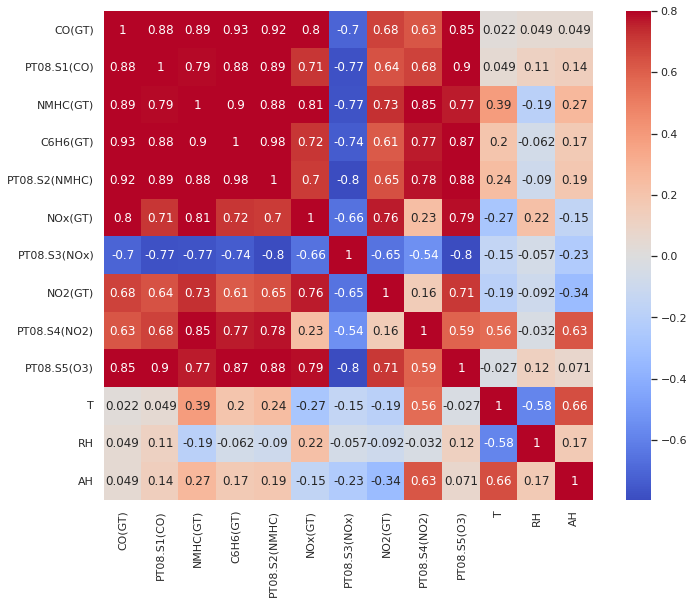

In [ ]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="coolwarm", vmax=.8, square=True, annot=True);

In [ ]:

corrmat = corrmat.abs()
s = corrmat.unstack()
sorted = s.sort_values(kind="quicksort", ascending=False)
highest_cor = sorted[13:25]
highest_cor

PT08.S2(NMHC)  C6H6(GT)         0.981950
C6H6(GT)       PT08.S2(NMHC)    0.981950
               CO(GT)           0.931078
CO(GT)         C6H6(GT)         0.931078
PT08.S2(NMHC)  CO(GT)           0.915514
CO(GT)         PT08.S2(NMHC)    0.915514
C6H6(GT)       NMHC(GT)         0.902559
NMHC(GT)       C6H6(GT)         0.902559
PT08.S1(CO)    PT08.S5(O3)      0.899324
PT08.S5(O3)    PT08.S1(CO)      0.899324
PT08.S1(CO)    PT08.S2(NMHC)    0.892964
PT08.S2(NMHC)  PT08.S1(CO)      0.892964
dtype: float64

From corr map i see that target value(C6H6(GT) greately correlates with many columns but those columns greatlely correlate with each other so i might drop some of them as redundant. PT08.S2(NMHC), CO(GT), NMHC(GT), PT08.S1(CO), PT08.S5(O3) are all highly correleted.

In [ ]:
print(df.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')


In [ ]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
numerical_cols.remove('C6H6(GT)')

In [ ]:
#sns.pairplot(df)

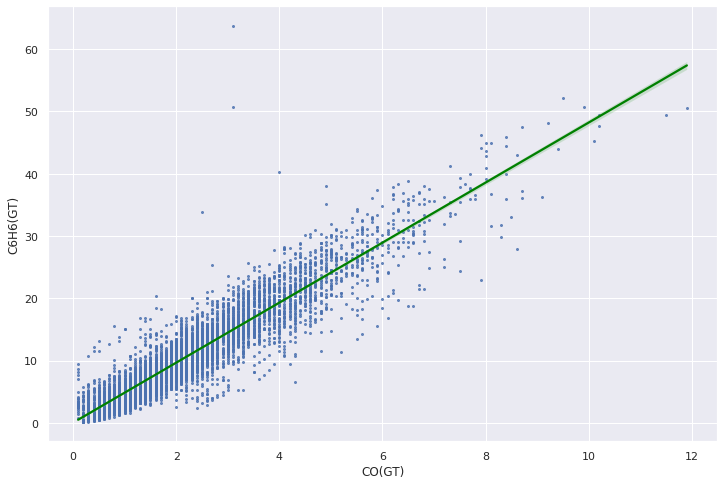

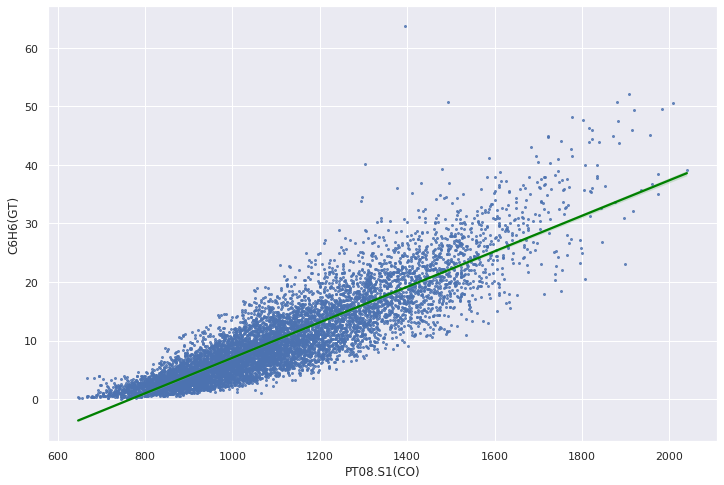

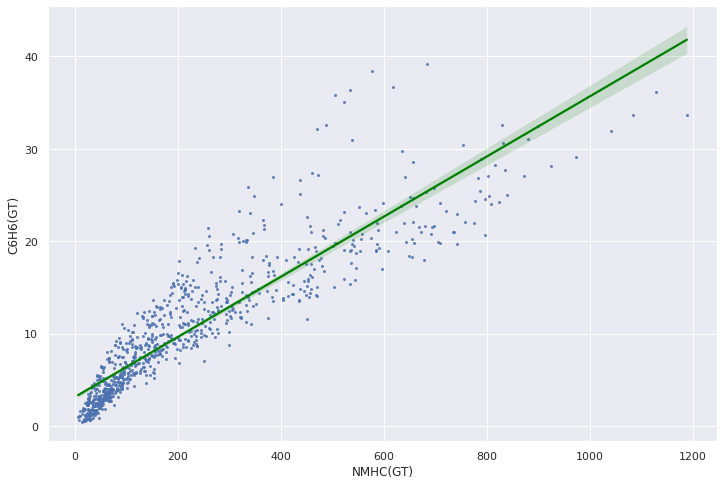

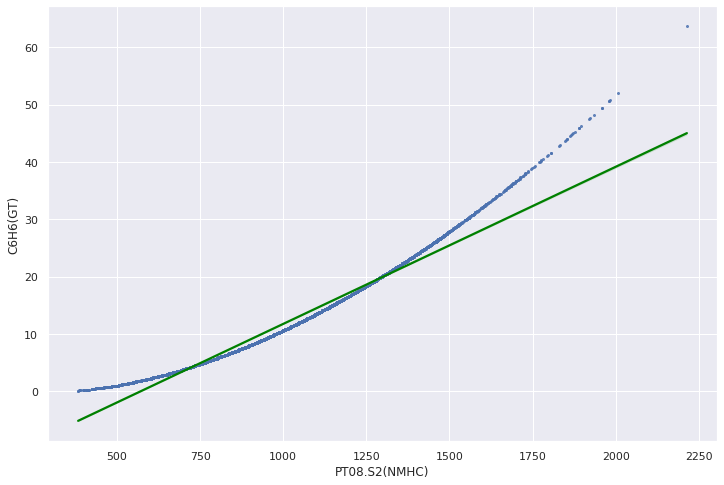

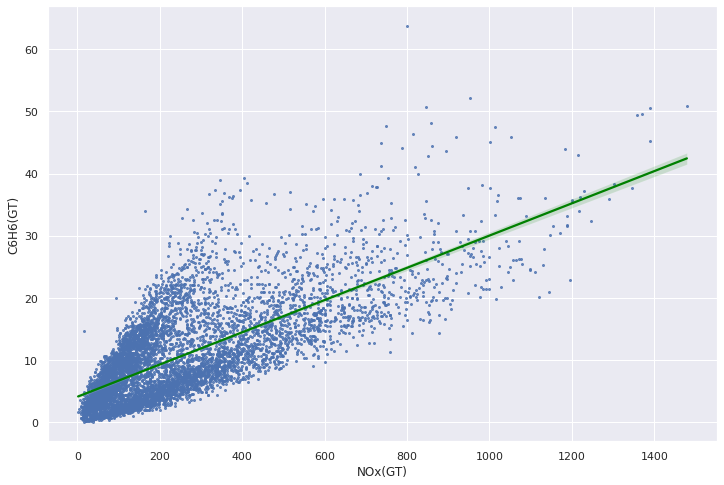

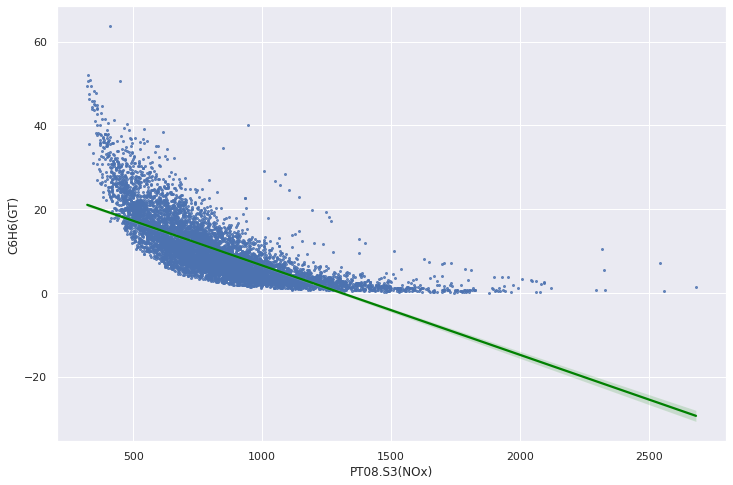

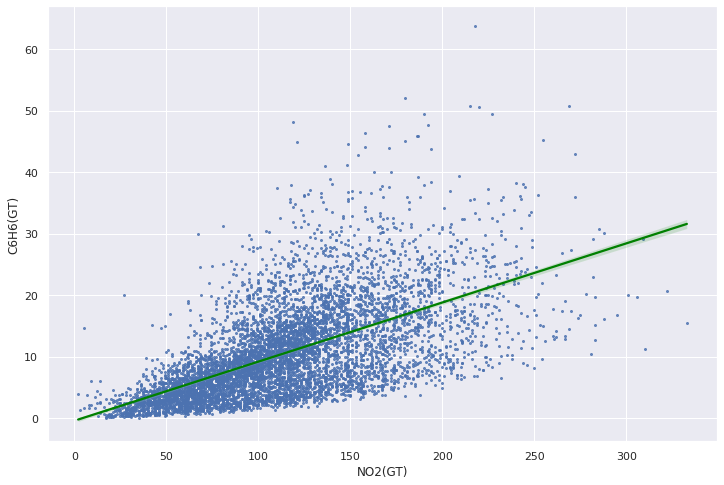

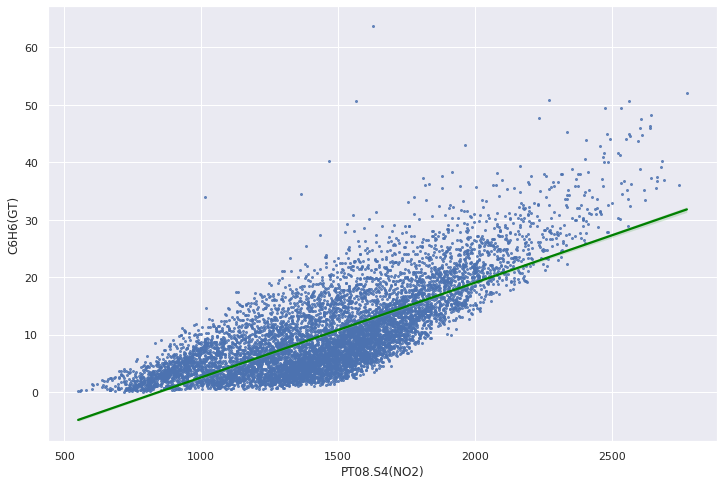

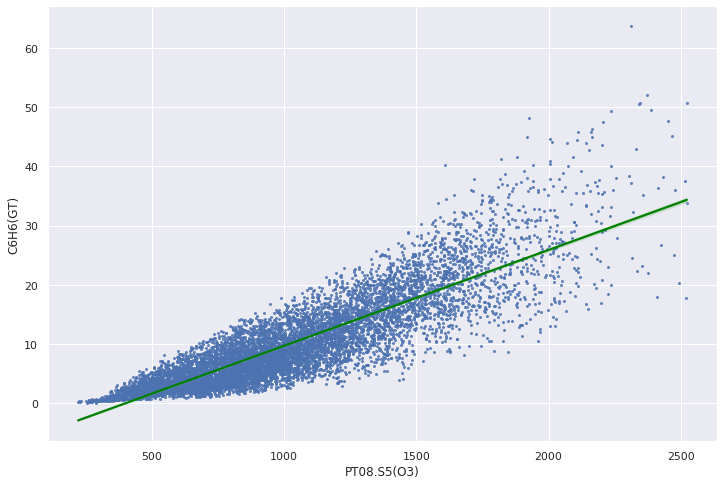

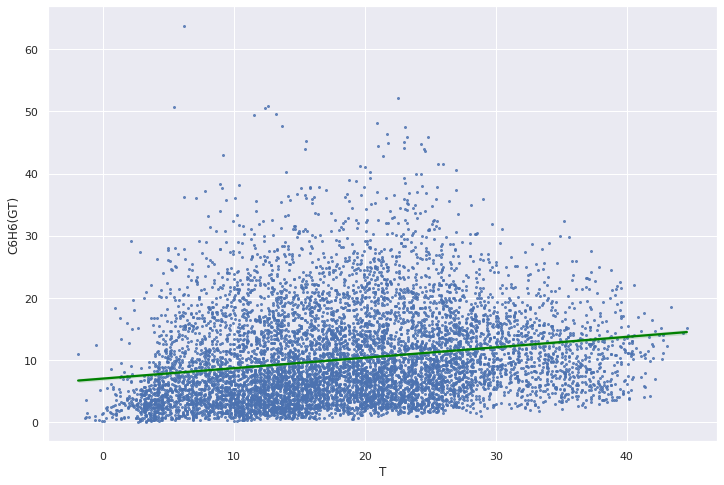

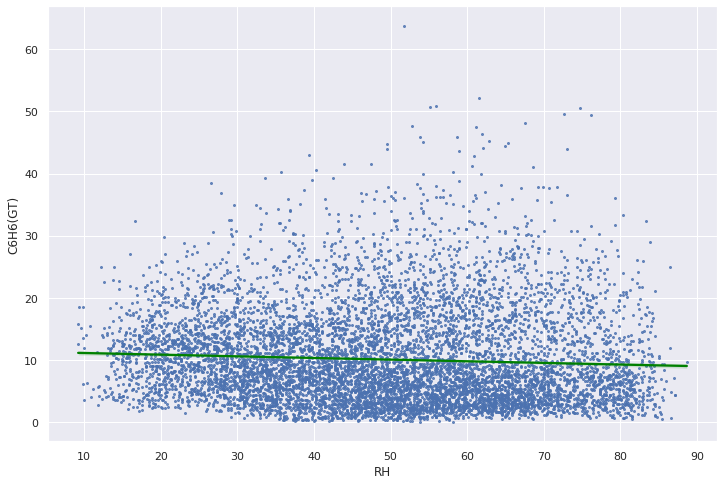

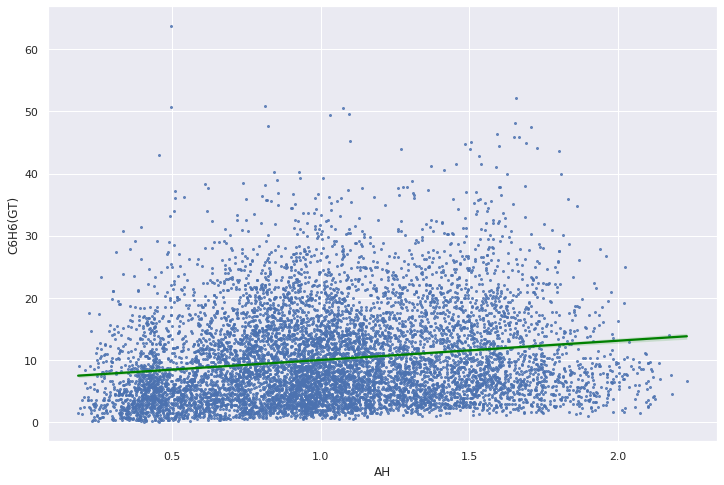

In [ ]:
def reg(data, cols):
  for col in cols:
    if data[col].dtype == 'float64':
      sns.set(rc={"figure.figsize":(12, 8)})
      sns.regplot(x=data[col], y=df['C6H6(GT)'], scatter_kws={"s": 4}, line_kws={'color': 'green'})
      plt.show(); 

reg(df, numerical_cols)

From regplots i see quite clear connection between some properties and target. Especially with 'PT08.S2' which seem be nearly idealy correlated to target value. From addiotional info i see that this feature is a sensor of NMHC but it looks like a data leakage. I'll try to predict C6H6 without this feature for situations when we don't have this particular sensor. 

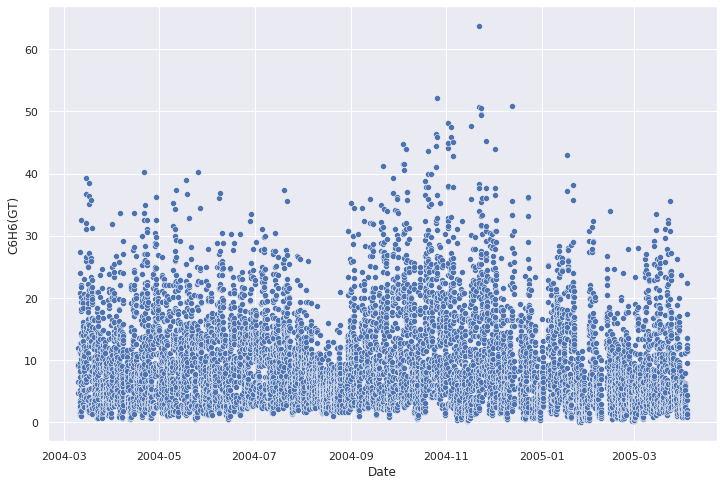

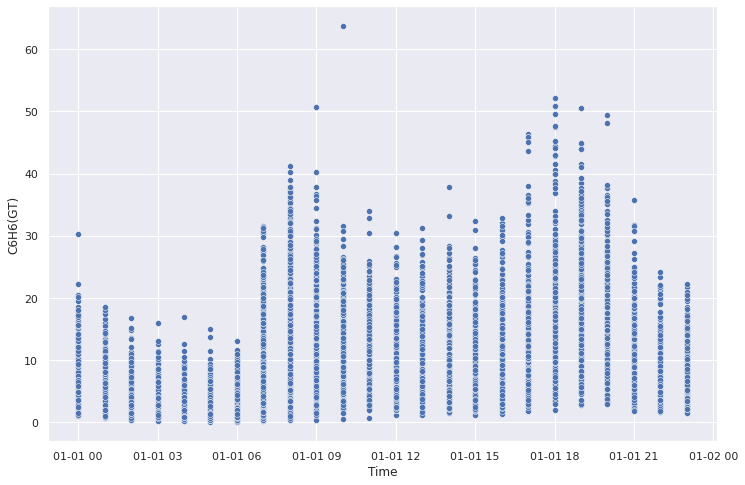

In [ ]:
sns.scatterplot(x=df['Date'], y=df['C6H6(GT)'])
plt.show()
ax = sns.scatterplot(x=df['Time'], y=df['C6H6(GT)'], )
#ax.set_xticks(df['Time'].apply(lambda x: x.time()))
plt.show()

From above pots i see that target value don't seem to be very connected to time and adequate time series analisys requaries additional knowledge so i will use it only to do time series split. 

To sum up, I am going to drop this and all the true (not collected by sensors) variables : 'CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)' as if we have direct measurements of target value or even true values of substencies we don't need a model. I'll drop them later on in data preparation part.

##2. Data preparation


### Dropping data and outliers 

Drop of some columns as i've mentioned earlier.

In [ ]:
df = df.drop(['CO(GT)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'NO2(GT)'], axis=1)

In [ ]:
df.head()

Date                Time  PT08.S1(CO)  C6H6(GT)  PT08.S3(NOx)  \
0 2004-03-10 1900-01-01 18:00:00       1360.0      11.9        1056.0   
1 2004-03-10 1900-01-01 19:00:00       1292.0       9.4        1174.0   
2 2004-03-10 1900-01-01 20:00:00       1402.0       9.0        1140.0   
3 2004-03-10 1900-01-01 21:00:00       1376.0       9.2        1092.0   
4 2004-03-10 1900-01-01 22:00:00       1272.0       6.5        1205.0   

   PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1692.0       1268.0  13.6  48.9  0.7578  
1        1559.0        972.0  13.3  47.7  0.7255  
2        1555.0       1074.0  11.9  54.0  0.7502  
3        1584.0       1203.0  11.0  60.0  0.7867  
4        1490.0       1110.0  11.2  59.6  0.7888

### Missing data

In [ ]:
print(df.isnull().sum())

Date            114
Time              0
PT08.S1(CO)     480
C6H6(GT)        480
PT08.S3(NOx)    480
PT08.S4(NO2)    480
PT08.S5(O3)     480
T               480
RH              480
AH              480
dtype: int64


In [ ]:
df[df==np.nan]

Date Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
0     NaT  NaN     NaN          NaN       NaN       NaN            NaN   
1     NaT  NaN     NaN          NaN       NaN       NaN            NaN   
2     NaT  NaN     NaN          NaN       NaN       NaN            NaN   
3     NaT  NaN     NaN          NaN       NaN       NaN            NaN   
4     NaT  NaN     NaN          NaN       NaN       NaN            NaN   
...   ...  ...     ...          ...       ...       ...            ...   
9466  NaT  NaN     NaN          NaN       NaN       NaN            NaN   
9467  NaT  NaN     NaN          NaN       NaN       NaN            NaN   
9468  NaT  NaN     NaN          NaN       NaN       NaN            NaN   
9469  NaT  NaN     NaN          NaN       NaN       NaN            NaN   
9470  NaT  NaN     NaN          NaN       NaN       NaN            NaN   

      NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)   T  RH  AH  
0         NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
1         NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
2         NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
3         NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
4         NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
...       ...           ...      ...           ...          ...  ..  ..  ..  
9466      NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
9467      NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
9468      NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
9469      NaN           NaN      NaN           NaN          NaN NaN NaN NaN  
9470      NaN           NaN      NaN           NaN          NaN NaN NaN NaN  

[9471 rows x 15 columns]

In [ ]:
df[df==np.nan].nunique()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

All the rows that contain nan are empty, so i can just drop them.

In [ ]:
df.dropna(inplace=True)
print(df.isnull().sum())

Date            0
Time            0
PT08.S1(CO)     0
C6H6(GT)        0
PT08.S3(NOx)    0
PT08.S4(NO2)    0
PT08.S5(O3)     0
T               0
RH              0
AH              0
dtype: int64


In [ ]:
df['Time'] = df['Time'].apply(lambda x: int(str(x)[:2]))
#df['Time'] = df['Time'].apply(lambda x: x.time())
#df['Time'].dtype

### Normality testing

Now let's try check hypothesis that all distributions are normal and compare result with and without log transformation.

In [ ]:
res = [[st.normaltest(np.log(df[col])) for col in df.columns]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=df.columns)
norm_h0['T'].iloc[0] = st.normaltest(np.sqrt(df[col]))
norm_h0

[[NormaltestResult(statistic=206.34874265769116, pvalue=1.5557501733405534e-45), NormaltestResult(statistic=634.8012814786056, pvalue=1.4277533056914974e-138), NormaltestResult(statistic=4.75908620144585, pvalue=0.09259287346406014), NormaltestResult(statistic=325.8510236370003, pvalue=1.7472266930670137e-71), NormaltestResult(statistic=173.11521179728052, pvalue=2.561588656935418e-38), NormaltestResult(statistic=nan, pvalue=nan), NormaltestResult(statistic=831.8314626067172, pvalue=2.3447306375019433e-181), NormaltestResult(statistic=584.2969041579677, pvalue=1.3229376168970617e-127)]]


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PT08.S1(CO)  \
0  (206.34874265769116, 1.5557501733405534e-45)   

                                       C6H6(GT)  \
0  (634.8012814786056, 1.4277533056914974e-138)   

                              PT08.S3(NOx)  \
0  (4.75908620144585, 0.09259287346406014)   

                                  PT08.S4(NO2)  \
0  (325.8510236370003, 1.7472266930670137e-71)   

                                   PT08.S5(O3)  \
0  (173.11521179728052, 2.561588656935418e-38)   

                                            T  \
0  (276.5279116212157, 8.968647300050933e-61)   

                                             RH  \
0  (831.8314626067172, 2.3447306375019433e-181)   

                                             AH  
0  (584.2969041579677, 1.3229376168970617e-127)

In [ ]:
res = [[st.normaltest(df[col]) for col in df.columns]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=df.columns)
norm_h0

[[NormaltestResult(statistic=718.7651943581501, pvalue=8.35836154952806e-157), NormaltestResult(statistic=2052.805749333648, pvalue=0.0), NormaltestResult(statistic=1800.6706400451621, pvalue=0.0), NormaltestResult(statistic=64.31476952506917, pvalue=1.0819949784039548e-14), NormaltestResult(statistic=498.8201635028024, pvalue=4.814794595035264e-109), NormaltestResult(statistic=270.79221026879475, pvalue=1.5784058030378252e-59), NormaltestResult(statistic=834.4914128495294, pvalue=6.201433655953465e-182), NormaltestResult(statistic=328.2080913173042, pvalue=5.376733517599341e-72)]]


PT08.S1(CO)                  C6H6(GT)  \
0  (718.7651943581501, 8.35836154952806e-157)  (2052.805749333648, 0.0)   

                PT08.S3(NOx)                                 PT08.S4(NO2)  \
0  (1800.6706400451621, 0.0)  (64.31476952506917, 1.0819949784039548e-14)   

                                   PT08.S5(O3)  \
0  (498.8201635028024, 4.814794595035264e-109)   

                                              T  \
0  (270.79221026879475, 1.5784058030378252e-59)   

                                            RH  \
0  (834.4914128495294, 6.201433655953465e-182)   

                                           AH  
0  (328.2080913173042, 5.376733517599341e-72)

Both log-ed and original datasets have very little p-values as our dataset is quite large and not quite normally distributed but p-values got bigger on transformed data, especially in case of PT08.S3(NOx) column in which case we even cannot reject h0 that distribution is normal. So, i'll use transformed data on PT08.S3(NOx). Also i'll do log transformation on target value as it has right skewness and it's p-value also got bigger.

Plots of log transformed columns

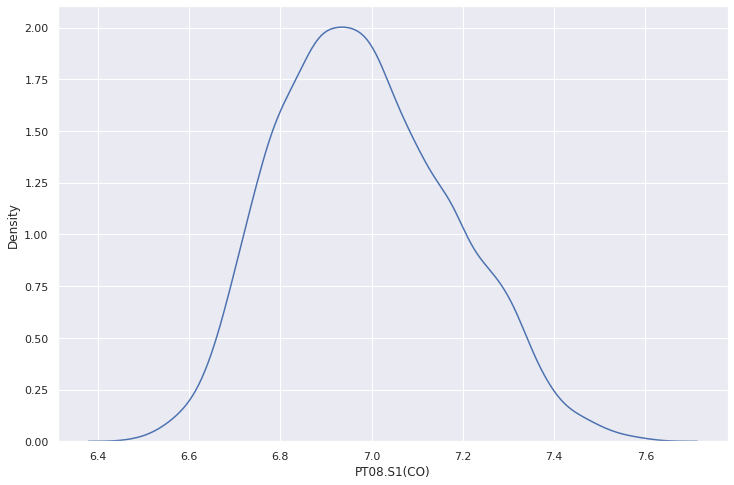

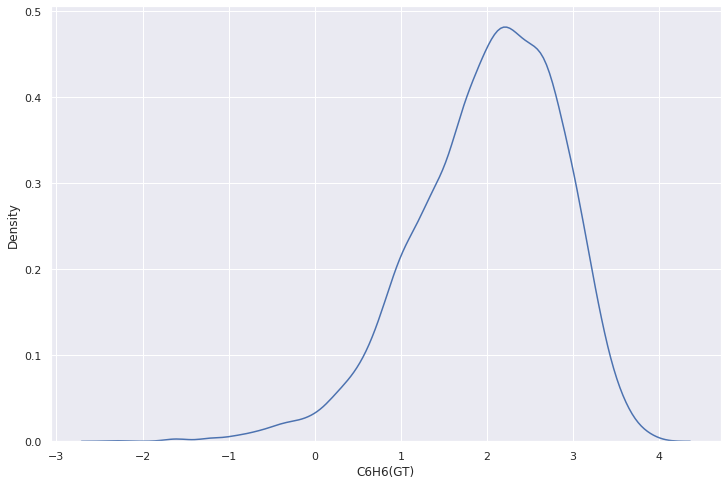

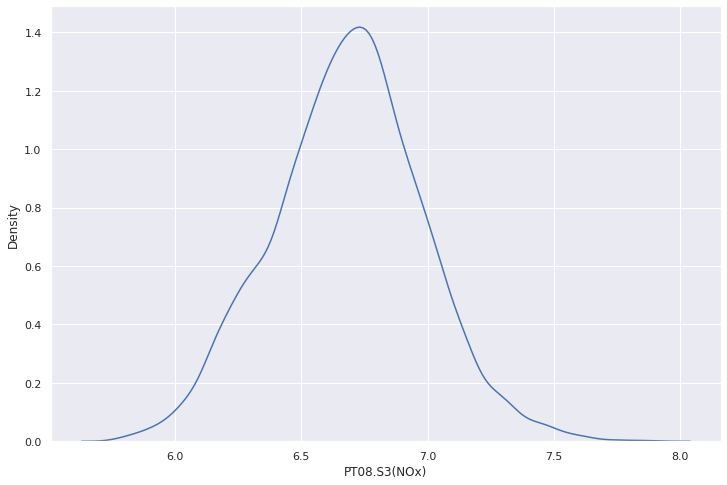

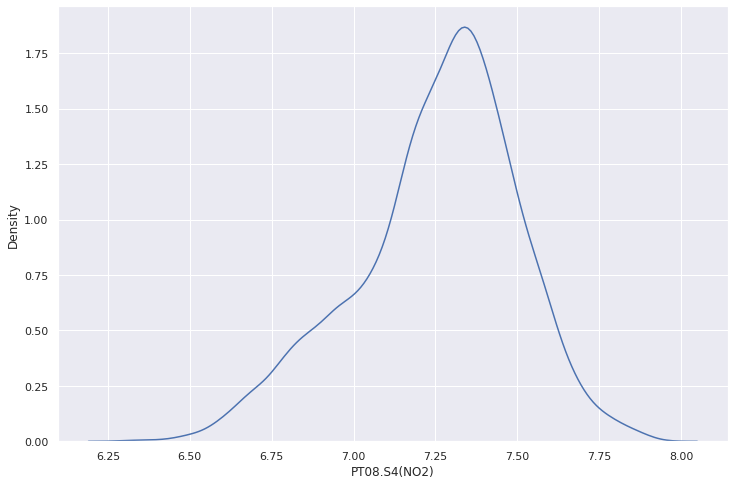

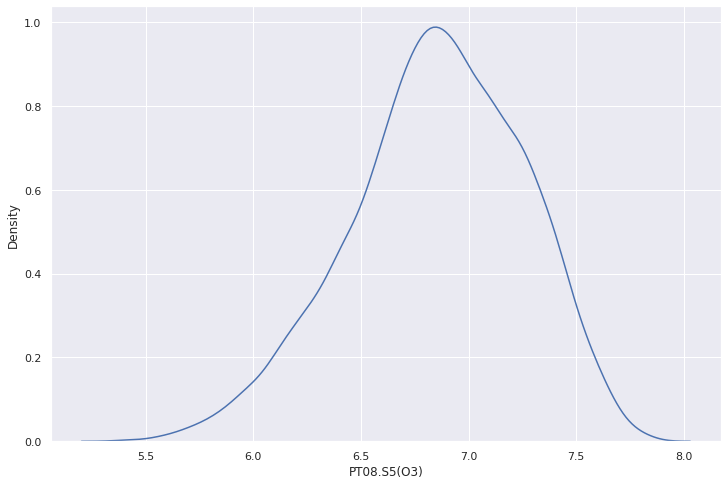

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


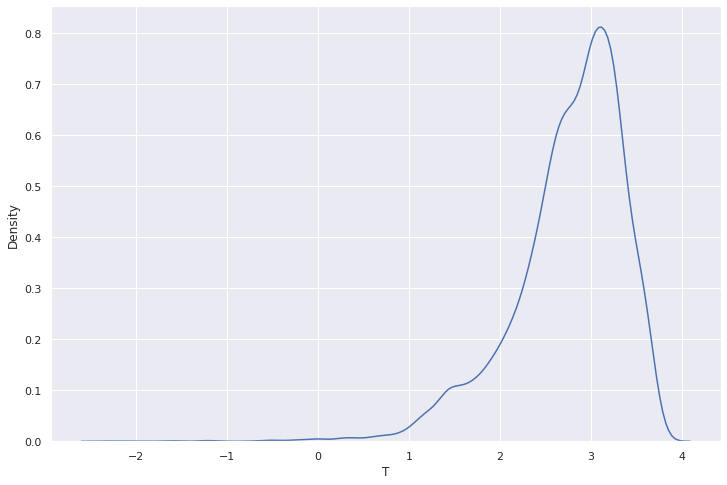

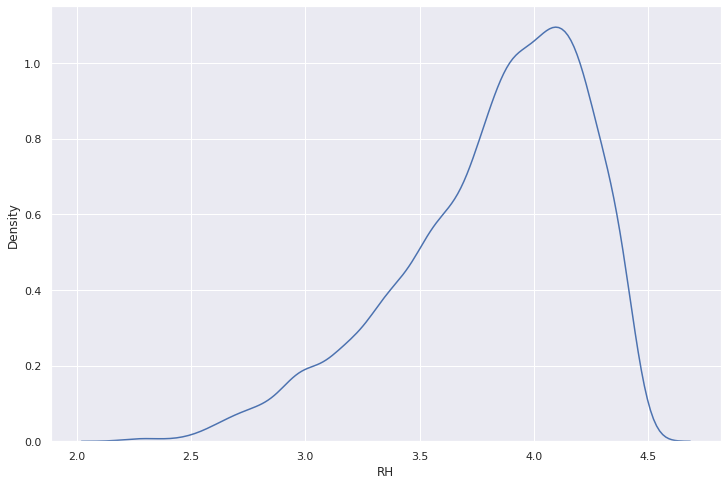

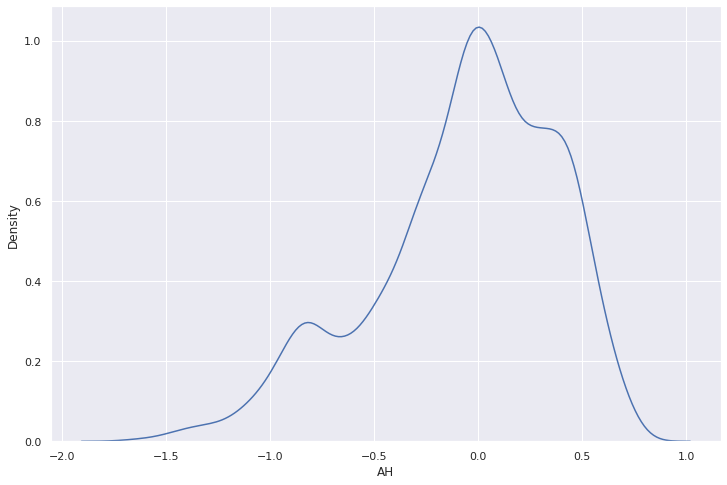

In [ ]:
for col in df.columns:
    sns.kdeplot(data=np.log(df[col]))
    plt.show(); 


Most of the plots show that transformation doen't really help to make features less skewed so i'll do transformation for 'PT08.S3(NOx)' variable and target value as it's got much less skewed.

In [ ]:
data = df.copy()
data['day'] = data['Date'].dt.dayofyear
data = data.drop(columns='Date')
data[['PT08.S3(NOx)']] = np.log(df[['PT08.S3(NOx)']])
data[['C6H6(GT)']] = np.log(df[['C6H6(GT)']])

In [ ]:
data


PT08.S1(CO)  C6H6(GT)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)     T  \
0          1360.0  2.476538      6.962243        1692.0       1268.0  13.6   
1          1292.0  2.240710      7.068172        1559.0        972.0  13.3   
2          1402.0  2.197225      7.038784        1555.0       1074.0  11.9   
3          1376.0  2.219203      6.995766        1584.0       1203.0  11.0   
4          1272.0  1.871802      7.094235        1490.0       1110.0  11.2   
...           ...       ...           ...           ...          ...   ...   
9352       1314.0  2.602690      6.289716        1374.0       1729.0  21.9   
9353       1163.0  2.433613      6.403574        1264.0       1269.0  24.3   
9354       1142.0  2.517696      6.401917        1241.0       1092.0  26.9   
9355       1003.0  2.251292      6.553933        1041.0        770.0  28.3   
9356       1071.0  2.476538      6.483107        1129.0        816.0  28.5   

        RH      AH  
0     48.9  0.7578  
1     47.7  0.7255  
2     54.0  0.7502  
3     60.0  0.7867  
4     59.6  0.7888  
...    ...     ...  
9352  29.3  0.7568  
9353  23.7  0.7119  
9354  18.3  0.6406  
9355  13.5  0.5139  
9356  13.1  0.5028  

[8989 rows x 8 columns]

### Normalization/scaling

As there is element of time Series in a data, i'll train models on older data and test on chronologically newer. As data is already sorted by date i can just apply standart train_test_split without shuffle.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('C6H6(GT)', axis=1), data['C6H6(GT)'], random_state=1, shuffle=False)

scaler function allows to quickly scale dataset after train-test split.

In [ ]:
def scaler(scaler, X_train, X_test):
  X_train = pd.DataFrame(scaler().fit_transform(X_train), columns=X_train.columns)
  X_test = pd.DataFrame(scaler().fit_transform(X_test), columns=X_test.columns)
  return X_train, X_test

In [ ]:
X_train, X_test = scaler(MinMaxScaler, X_train, X_test)

## 3. ML model

From previous hw I see that the best result was achieved but performing sqrt transformation on th target. I'm going to use this transformation and the best hyperperparameters

In [ ]:
def evaluate_model(model, train, test, y_tr, y_tst):
    pred_train = model.predict(train) ** 2
    pred_test = model.predict(test) ** 2
    y_tr = y_tr ** 2
    y_tst = y_tst ** 2
    return pd.DataFrame({
        'train_RMSE': [mean_squared_error(y_tr, pred_train, squared=False)], 
        'train_R2': [r2_score(y_tr, pred_train)],
        'test_RMSE': [mean_squared_error(y_tst, pred_test, squared=False)],
        'test_R2': [r2_score(y_tst, pred_test)]
    })


In [ ]:
linear_sqrt = LinearRegression(n_jobs=-1).fit(X_train, y_train)
res = evaluate_model(linear_sqrt, X_train, X_test, y_train, y_test)
res

train_RMSE  train_R2  test_RMSE   test_R2
0    0.963828  0.902767   1.861568  0.593617

As a pinnacle of ML methods I'll use gradient boost algorithm - catboostRegressor.

In [ ]:
cat_reg = CatBoostRegressor(random_state=SEED, verbose=False)
cat = cat_reg.fit(X_train, y_train)

In [ ]:
evaluate_model(cat, X_train, X_test, y_train, y_test)

train_RMSE  train_R2  test_RMSE  test_R2
0      0.2046  0.995618   0.836775  0.91789

Gradient boost doesn't seem to be all that good as it severely overfits. All in all, vanilla linear regression has test rmse of 0.77 and untuned cat_regressor test_rmse=0.93. I think hyperparameters tuning might have helped a lot but I'm not gonna perform it as it is not a goal of this hw.

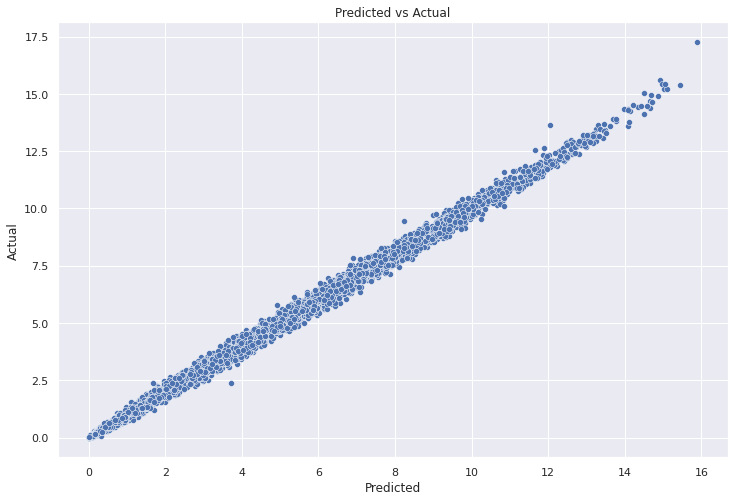

In [ ]:
sns.scatterplot(x=cat.predict(X_train) ** 2, y=y_train ** 2).set(title='Predicted vs Actual', xlabel='Predicted', ylabel='Actual');

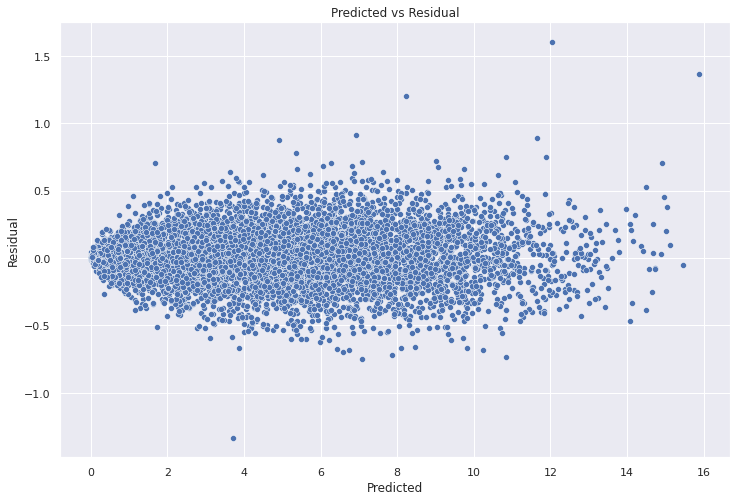

In [ ]:
sns.scatterplot(x=cat.predict(X_train) ** 2,
                y=y_train ** 2 - cat.predict(X_train) ** 2).set(title='Predicted vs Residual', xlabel='Predicted', ylabel='Residual');

The errors seem to have more dispertion in middle values, while they are relatively small by the ends.

## 4. Deep Learning solution

### Preprocessing and functions initialization

For deep learning solution I'm not going to use non-linear transformations as I expect the model to get it by itself.

In [ ]:
data = df.copy()

In [ ]:
data['day'] = data['Date'].dt.dayofyear
data = data.drop(['Date'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['C6H6(GT)'], axis=1), data['C6H6(GT)'], random_state=SEED, shuffle=True)

In [ ]:
X_train

Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  \
108   06.00.00     1.4       1157.0      51.0          830.0    138.0   
493   07.00.00     3.1       1636.0     342.0         1168.0    207.0   
824   02.00.00     0.7        900.0      66.0          635.0     47.0   
1111  01.00.00     0.7        838.0      45.0          601.0     33.0   
889   19.00.00     6.4       1689.0     783.0         1474.0    323.0   
...        ...     ...          ...       ...            ...      ...   
694   16.00.00     1.9       1085.0     209.0         1004.0    106.0   
491   05.00.00     0.6        909.0      31.0          545.0     44.0   
488   02.00.00     0.9        972.0      66.0          639.0     47.0   
1216  10.00.00     2.7       1315.0     212.0         1072.0    191.0   
145   19.00.00     3.9       1551.0     261.0         1271.0    181.0   

      PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
108         1030.0     80.0        1584.0       1083.0  11.4  70.5  0.9475   
493          721.0    110.0        1926.0       1438.0  13.8  58.2  0.9129   
824         1207.0     60.0        1307.0        836.0  11.1  63.2  0.8331   
1111        1361.0     43.0        1220.0        434.0  14.2  45.5  0.7333   
889          560.0    149.0        2298.0       1492.0  13.9  78.0  1.2303   
...            ...      ...           ...          ...   ...   ...     ...   
694          888.0     95.0        1454.0        816.0  21.0  25.4  0.6264   
491         1473.0     58.0        1131.0        436.0  14.6  36.0  0.5947   
488         1222.0     70.0        1256.0        678.0  14.8  40.8  0.6834   
1216         736.0    116.0        1833.0       1273.0  16.3  73.2  1.3458   
145          800.0    137.0        1875.0       1432.0  21.3  34.8  0.8730   

      day  
108    75  
493    91  
824   105  
1111  117  
889   107  
...   ...  
694    99  
491    91  
488    91  
1216  121  
145    76  

[620 rows x 14 columns]

In [ ]:
encoder = CyclicalFeatures(variables=['Time'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
#X_train, X_test = transformer(X_train, X_test)

As my loss function I'll use MSE.

In [ ]:
loss_fn = nn.MSELoss()
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).reshape(-1, 1)

For validationg results while choosing the best epoch of my model I'm going to split test set on validation and test. 

In [ ]:
X_val = X_test[:len(X_test)//2, :]
X_test = X_test[len(X_test)//2:, :]
y_val = y_test[:len(y_test)//2]
y_test = y_test[len(y_test)//2:]

In [ ]:
class RegPartDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, X, y):
        # Save target and predictors
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


In [ ]:
train_ds = RegPartDataset(X_train, y_train)
# val = RegPartDataset(X_val, y_val)
# test = RegPartDataset(X_test, y_test)

The fuction that trains networks consists of training network on given number of epochs with given batch size, with or witouht early stop. After each epoch I save validation score to choose the best state of model after training. 

For early stop I've written 2 critereas. Fist one is finding a plato. It means that validation loss nearly don't change for 2 epochs. Second one is when the model doesn't find new local minimum at last 10 epochs. This second one might be weird but the reason of it is that the errors don't monotonicly decrease but rather randomly get less whith random differeces.

In [ ]:
def train(model, n_epochs=50, batch_size=64, disable_bar=False, early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val = []
  history_tr = []
  train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()
      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")
      for X_batch, y_batch in loop :
          # take a batch
          # X_batch = X_train[start:start+batch_size]
          # y_batch = y_train[start:start+batch_size]
          # forward pass
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          model.get_optimizer().zero_grad()
          loss.backward()
          # update weights
          model.get_optimizer().step()
          # print progress
          loop.set_postfix(mse=loss.item())
      # evaluate accuracy at end of each epoch
      # evaluate accuracy at end of each epoch
      model.eval()
      y_pred = model(X_val)
      y_pred_tr = model(X_train)
      loss_val = loss_fn(y_pred, y_val).item()
      history_val.append(loss_val)
      loss_tr = loss_fn(y_pred_tr, y_train).item()
      history_tr.append(loss_tr)
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if early_stop:
        if epoch > 3 and abs(history_val[-3] - history_val[-2]) < 0.01 and abs(history_val[-3] - history_val[-1]) < 0.01:
          print('')
          print('Early stop: plato found')
          break
        if epoch > 20 and (np.min(history_val[-6: -3]) - np.min(history_val[-3:])) < 0:
          print('')
          print('Early stop: error increasing')
          break
  return history_tr, history_val, best_weights

In [ ]:
def show_results(history_tr, history_tst, metric='RMSE'):
  print(f'Best val {metric} = {min(np.sqrt(history_tst))}')
  plt.plot(np.sqrt(history_tst))
  plt.plot(np.sqrt(history_tr))
  plt.legend(labels=[f'Val {metric}', f'Train {metric}'])
  plt.title(f'{metric} (original scale) on epochs')
  plt.show()

In [ ]:
def evaluate_network(model, train, test, y_tr, y_tst):
    pred_train = model(train).detach().numpy()
    pred_test = model(test).detach().numpy()
    y_tr = y_tr.detach().numpy()
    y_tst = y_tst.detach().numpy()
    return pd.DataFrame({
        'train_RMSE': [mean_squared_error(y_tr, pred_train, squared=False)], 
        'train_R2': [r2_score(y_tr, pred_train)],
        'test_RMSE': [mean_squared_error(y_tst, pred_test, squared=False)],
        'test_R2': [r2_score(y_tst, pred_test)]
    })

### Basic network

Firstly, I'll try primitive model with 2 hidden layers and neither normalization nor reguralization.

In [ ]:
class RegressionNetwork(nn.Module):
  def __init__(self, input_len, learning_rate=0.001):
    super(RegressionNetwork, self).__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = F.relu(self.fc3(x))
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer



In [ ]:
basic_network = RegressionNetwork(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train(basic_network, 100, 32)

Epoch 28: 100%|██████████| 211/211 [00:01<00:00, 159.20batch/s, mse=13.7]



Early stop: error increasing


Best val RMSE = 3.5444237393206617


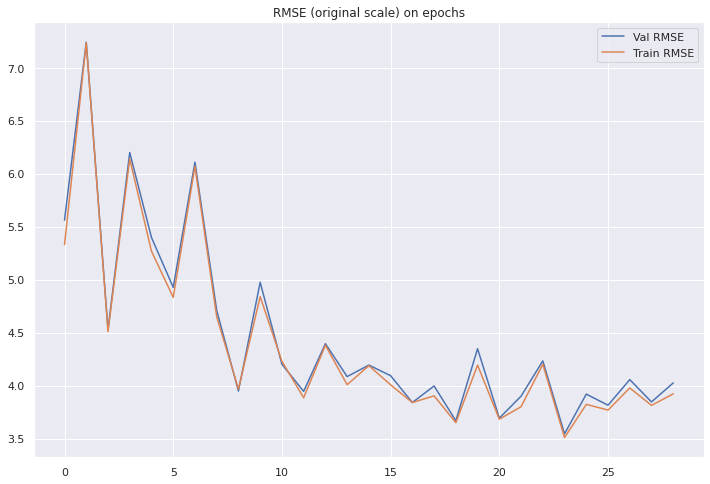

In [ ]:
basic_network.load_state_dict(best_weights)
show_results(history_tr, history_tst)

In [ ]:
evaluate_network(basic_network, 
                 X_train,
                 X_test, 
                 y_train, 
                 y_test)

train_RMSE  train_R2  test_RMSE   test_R2
0    3.509446   0.77969   3.490059  0.776459

The results are rather underwhelming as they are much worse than the ML ones and the plot shows that the errors are pretty random throughout the training process.  I'll try to make the model more complicated by adding additional layers and batch normalization.

### More advanced network

In [ ]:
class RegressionNetworkNorm(nn.Module):
  def __init__(self, input_len, learning_rate=0.001, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 32)
    self.fc2 = nn.Linear(32, 64)
    self.m2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 16)
    self.m3 = nn.BatchNorm1d(16)
    self.fc4 = nn.Linear(16, 1)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     #x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = self.fc4(x)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

Through some number of experiments I found out that normalization is improving results only after 2 layer.

In [ ]:
norm_network = RegressionNetworkNorm(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train(norm_network, 50, 32)

Epoch 21: 100%|██████████| 211/211 [00:01<00:00, 166.04batch/s, mse=1.98]



Early stop: error increasing


Best val RMSE = 1.6700625711699921


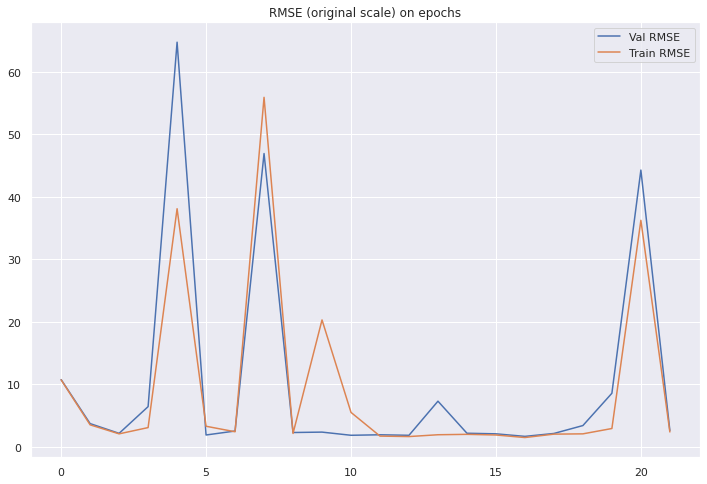

In [ ]:
norm_network.load_state_dict(best_weights)
show_results(history_tr, history_tst)

In [ ]:
evaluate_network(norm_network, 
                 X_train,
                 X_test, 
                 y_train, 
                 y_test)

train_RMSE  train_R2  test_RMSE   test_R2
0    1.483787  0.960618   1.374609  0.965322

The results got much better - the rmse is less than linear regression but the plot looks weird - it has a lot of peaks, although the majority of epoch have little rmse. I'll try another batch size


Early stop: error increasing
Model with batch size = 26
Best val RMSE = 1.7728847364814433


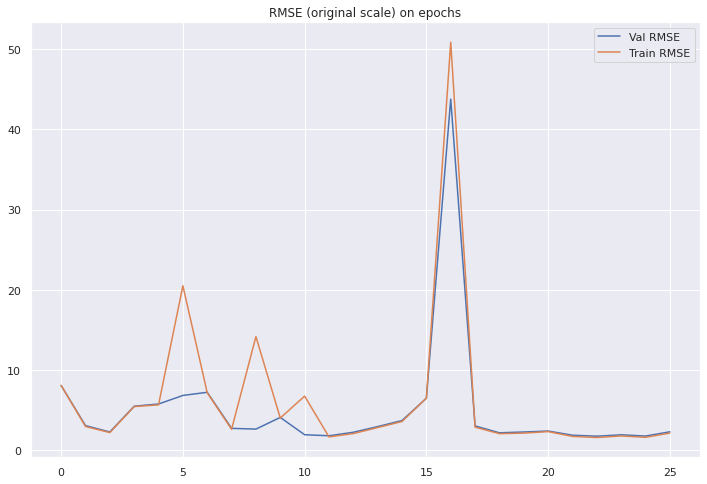


Early stop: error increasing
Model with batch size = 32
Best val RMSE = 1.7280577662048988


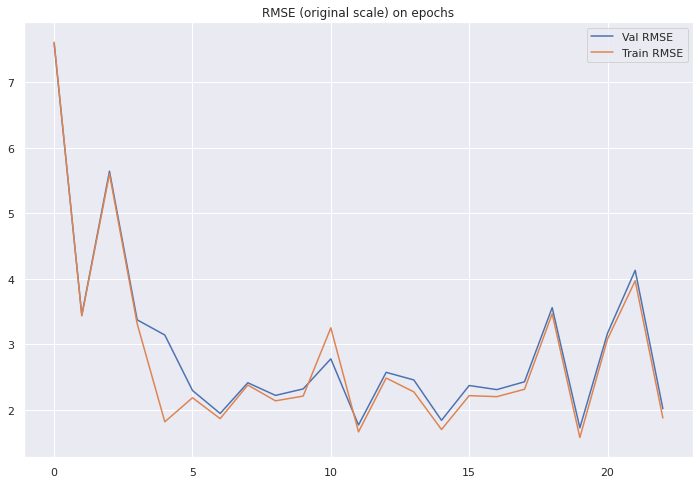


Early stop: error increasing
Model with batch size = 36
Best val RMSE = 1.8132713255144308


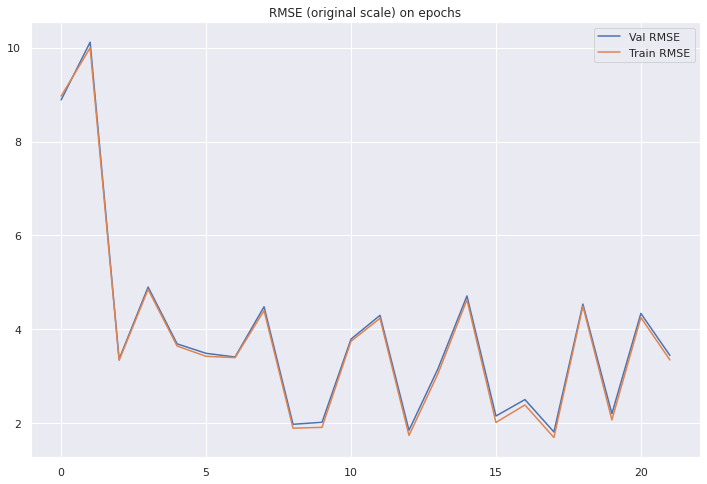


Early stop: error increasing
Model with batch size = 40
Best val RMSE = 1.7892300056767747


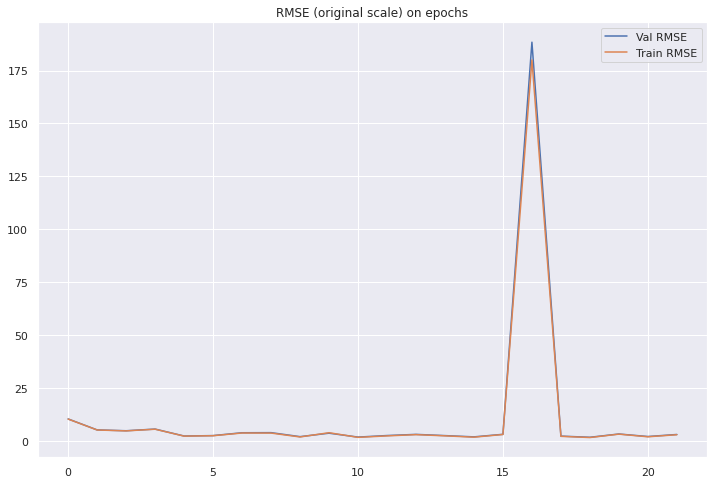


Early stop: error increasing
Model with batch size = 44
Best val RMSE = 1.848947344107051


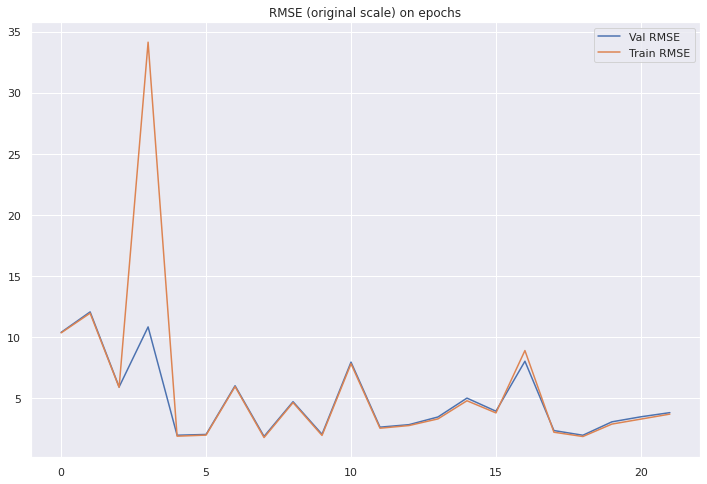

In [ ]:
results = pd.DataFrame(columns=['train_RMSE', 'train_R2', 'test_RMSE', 'test_R2'])
for batch_size in (26, 32, 36, 40, 44):
  network = RegressionNetworkNorm(X_train.size()[-1])
  history_tr, history_tst, best_weights = train(network, 50, batch_size, disable_bar=True)
  network.load_state_dict(best_weights)
  print(f'Model with batch size = {batch_size}')
  show_results(history_tr, history_tst)
  res = evaluate_network(network, 
                 X_train,
                 X_test, 
                 y_train, 
                 y_test)
  results = pd.concat([results, res], axis=0)

In [ ]:
results.index = (26, 32, 36, 40, 44)

In [ ]:
results

train_RMSE  train_R2  test_RMSE   test_R2
26    1.608000  0.953748   1.500107  0.958701
32    1.580745  0.955303   1.454796  0.961159
36    1.695107  0.948601   1.570308  0.954746
40    1.665850  0.950360   1.544149  0.956241
44    1.758444  0.944689   1.667436  0.948974

The optimal batch size seems to be 32. I'll try to tune hyperparamters to get better result.

### Hyperparameters tuning

For tuning I'll create a new calss where all number s of layers will be hyperparametrers. I'll also tune learning rate and weight decay - l2 regularization of adam to probably decrease possible overfitting.

In [ ]:
class RegressionNetworkHyper(nn.Module):
  def __init__(self, input_len=11, n1=32, n2=64, n3=16, learning_rate=0.01, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n1)
    self.fc2 = nn.Linear(n1, n2)
    self.m2 = nn.BatchNorm1d(n2)
    self.fc3 = nn.Linear(n2, n3)
    self.m3 = nn.BatchNorm1d(n3)
    self.fc4 = nn.Linear(n3, 1)
    
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     #x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = self.fc4(x)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

For finding hyperparams I'll use optuna. 

For calculating score I'll train model 3 times and calculaye average. The reasoing behid is that seed doesn't work and I get different results every time I train a model so calculating average score is a way to decrease randomness.

In [ ]:
def objective(trial):
    params_model = {'n1': trial.suggest_int('n1', 8, 164, 8),
                    'n2': trial.suggest_int('n2', 8, 128, 8),
                    'n3': trial.suggest_int('n3', 8, 128, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01, log=True),
                    'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1, log=True)
    }
    reg = RegressionNetworkHyper(X_train.size()[-1], **params_model)
    _, _, best_weights = train(reg, 50, 32, disable_bar=True)
    reg.load_state_dict(best_weights)
    score = np.sqrt(loss_fn(reg(X_val), y_val).item())
    
    return score

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-03-26 10:51:43,669] A new study created in memory with name: no-name-eab132e5-3582-4a2e-97e8-8cb8552af9e6
/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/optuna/distributions.py:716: UserWarning: The distribution is specified by [8, 164] and step=8, but the range is not divisible by `step`. It will be replaced by [8, 160].
  warnings.warn(



Early stop: error increasing
[I 2023-03-26 10:51:53,540] Trial 0 finished with value: 1.769179555540831 and parameters: {'n1': 120, 'n2': 112, 'n3': 56, 'learning_rate': 0.00035633401541093705, 'weight_decay': 0.00019169468171534006}. Best is trial 0 with value: 1.769179555540831.

Early stop: error increasing
[I 2023-03-26 10:52:01,966] Trial 1 finished with value: 1.8884255723010006 and parameters: {'n1': 56, 'n2': 72, 'n3': 56, 'learning_rate': 0.00024686678072239753, 'weight_decay': 0.0663007354137389}. Best is trial 0 with value: 1.769179555540831.

Early stop: error increasing
[I 2023-03-26 10:52:10,229] Trial 2 finished with value: 1.7310316147762814 and parameters: {'n1': 120, 'n2': 24, 'n3': 128, 'learning_rate': 0.0011168431307875825, 'weight_decay': 1.6730445019861475e-08}. Best is trial 2 with value: 1.7310316147762814.

Early stop: error increasing
[I 2023-03-26 10:52:19,438] Trial 3 finished with value: 1.8117512438888144 and parameters: {'n1': 96, 'n2': 112, 'n3': 16, '

In [ ]:
print('Best Validation RMSE: {}'.format(study.best_value))
print('Best Params: {}'.format(study.best_params))

Best Validation RMSE: 1.6084270463169832
Best Params: {'n1': 96, 'n2': 88, 'n3': 72, 'learning_rate': 0.002585028301465163, 'weight_decay': 1.6647431687442186e-06}


In [ ]:
reg = RegressionNetworkHyper(X_train.size()[-1], **study.best_params)
history_tr, history_val, best_weights = train(reg, 50, 32, disable_bar=False, early_stop=False)
reg.load_state_dict(best_weights)

Epoch 49: 100%|██████████| 211/211 [00:01<00:00, 132.64batch/s, mse=1.9]


<All keys matched successfully>

Best val RMSE = 1.6470723216721856


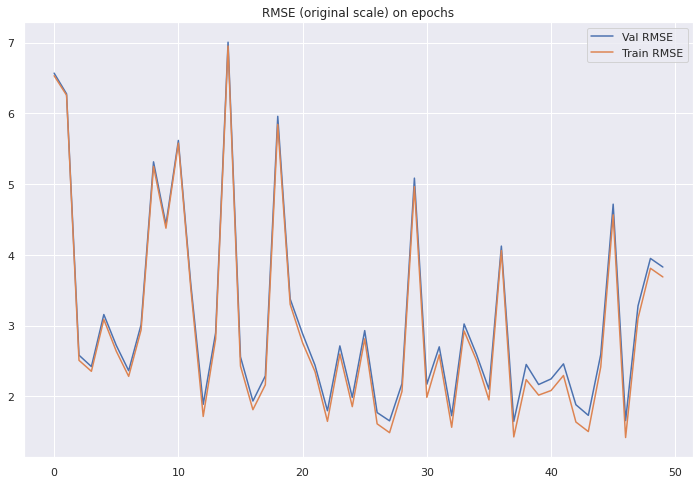

In [ ]:
show_results(history_tr, history_val)

In [ ]:
evaluate_network(reg, 
                 X_train,
                 X_test, 
                 y_train, 
                 y_test)

train_RMSE  train_R2  test_RMSE   test_R2
0    1.427693  0.963539    1.31277  0.968372

The results of tuned model are even better - the test rmse now is 1.31. The plot in the other hand looks weird but anyway the result has improved.

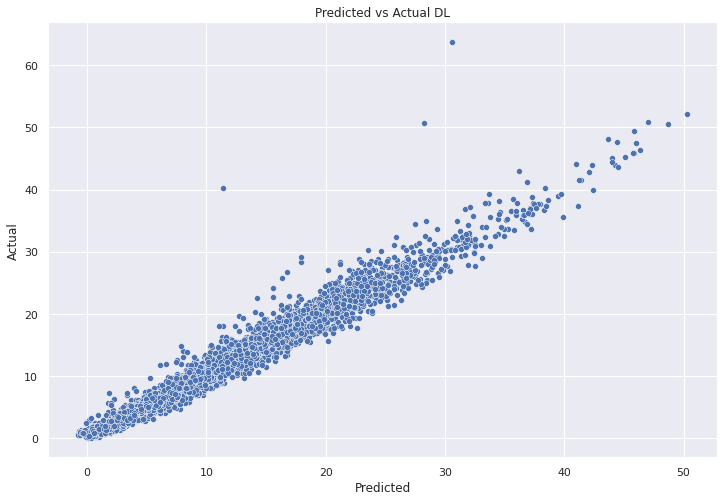

In [ ]:
sns.scatterplot(x=reg(X_train).squeeze().detach().numpy(), 
                y=y_train.squeeze().detach().numpy()).set(
                    title='Predicted vs Actual DL', xlabel='Predicted', ylabel='Actual');

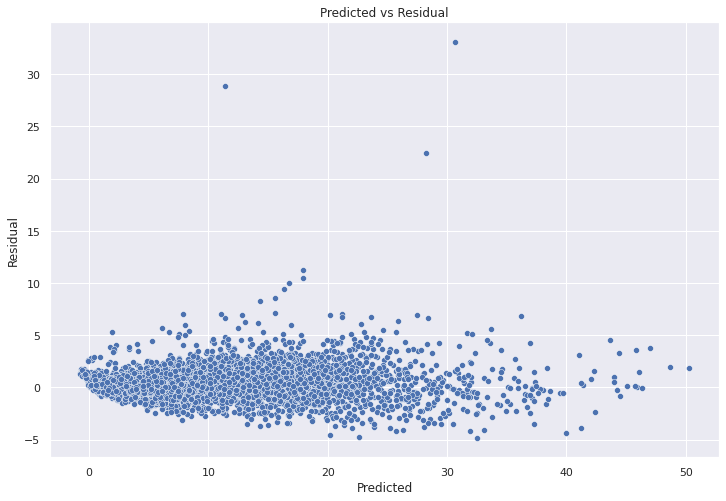

In [ ]:
sns.scatterplot(x=reg(X_train).squeeze().detach().numpy(),
                y=y_train.squeeze().detach().numpy() - reg(X_train).squeeze().detach().numpy()).set(title='Predicted vs Residual', xlabel='Predicted', ylabel='Residual');

The errors seem to be simmetricaly distributed. And homoscedasticity was achieved.

All in all, neural networks achived pretty good results - better than linear regression but worse then gradient boosting. Neural networks are significantly harder to create and tune, they study more. Another big issue is reproducability - I achieved significantly different results when I ran the same code (although I tried to fix seed in the beginning). 

# 2. Classification part.

Next chapter was copied from previous HW.

## Data preparation and ML solution

### Initial data preparation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/hw4/dataset_57_hypothyroid.csv', na_values='?')

In [ ]:
print(df.isnull().sum())

age                             1
sex                           150
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           369
T3_measured                     0
T3                            769
TT4_measured                    0
TT4                           231
T4U_measured                    0
T4U                           387
FTI_measured                    0
FTI                           385
TBG_measured                    0
TBG                          3772
referral_source                 0
Class         

In [ ]:
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
T

Most of the types are jbect which is obviously incorrect so i'll convert them to numerical types.

In [ ]:
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']].apply(pd.to_numeric)
df.dtypes

age                          float64
sex                           object
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
TBG_measured                  object
T

In [ ]:
df.describe()

age          TSH           T3          TT4          T4U  \
count  3771.000000  3403.000000  3003.000000  3541.000000  3385.000000   
mean     51.735879     5.086766     2.013500   108.319345     0.995000   
std      20.084958    24.521470     0.827434    35.604248     0.195457   
min       1.000000     0.005000     0.050000     2.000000     0.250000   
25%      36.000000     0.500000     1.600000    88.000000     0.880000   
50%      54.000000     1.400000     2.000000   103.000000     0.980000   
75%      67.000000     2.700000     2.400000   124.000000     1.080000   
max     455.000000   530.000000    10.600000   430.000000     2.320000   

               FTI  TBG  
count  3387.000000  0.0  
mean    110.469649  NaN  
std      33.089698  NaN  
min       2.000000  NaN  
25%      93.000000  NaN  
50%     107.000000  NaN  
75%     124.000000  NaN  
max     395.000000  NaN

'TBG' colum is completely nan so i'll drop it.

In [ ]:
df = df.drop('TBG', axis=1)

In [ ]:
df.describe()

age          TSH           T3          TT4          T4U  \
count  3771.000000  3403.000000  3003.000000  3541.000000  3385.000000   
mean     51.735879     5.086766     2.013500   108.319345     0.995000   
std      20.084958    24.521470     0.827434    35.604248     0.195457   
min       1.000000     0.005000     0.050000     2.000000     0.250000   
25%      36.000000     0.500000     1.600000    88.000000     0.880000   
50%      54.000000     1.400000     2.000000   103.000000     0.980000   
75%      67.000000     2.700000     2.400000   124.000000     1.080000   
max     455.000000   530.000000    10.600000   430.000000     2.320000   

               FTI  
count  3387.000000  
mean    110.469649  
std      33.089698  
min       2.000000  
25%      93.000000  
50%     107.000000  
75%     124.000000  
max     395.000000

From above table i see that there are some obvious outlier like age of 455 years. I'll change it to nan.


In [ ]:
df.loc[df[df['age']>150].index, 'age'] = np.nan

In [ ]:
df.describe()

age          TSH           T3          TT4          T4U  \
count  3770.000000  3403.000000  3003.000000  3541.000000  3385.000000   
mean     51.628912     5.086766     2.013500   108.319345     0.995000   
std      18.982990    24.521470     0.827434    35.604248     0.195457   
min       1.000000     0.005000     0.050000     2.000000     0.250000   
25%      36.000000     0.500000     1.600000    88.000000     0.880000   
50%      54.000000     1.400000     2.000000   103.000000     0.980000   
75%      67.000000     2.700000     2.400000   124.000000     1.080000   
max      94.000000   530.000000    10.600000   430.000000     2.320000   

               FTI  
count  3387.000000  
mean    110.469649  
std      33.089698  
min       2.000000  
25%      93.000000  
50%     107.000000  
75%     124.000000  
max     395.000000

#### EDA

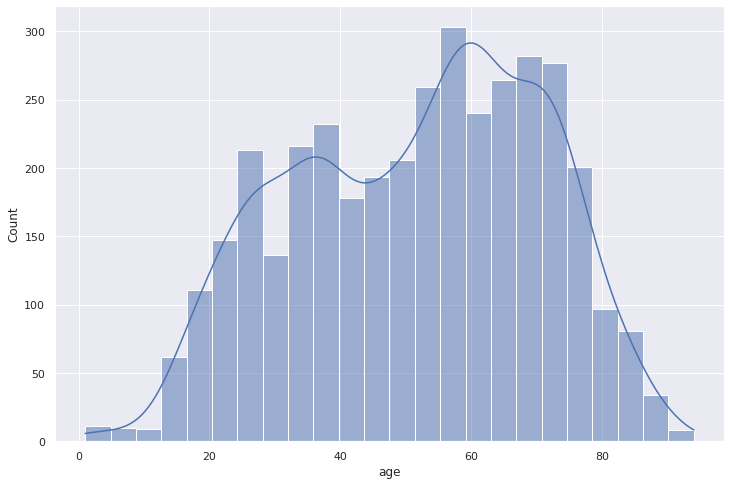

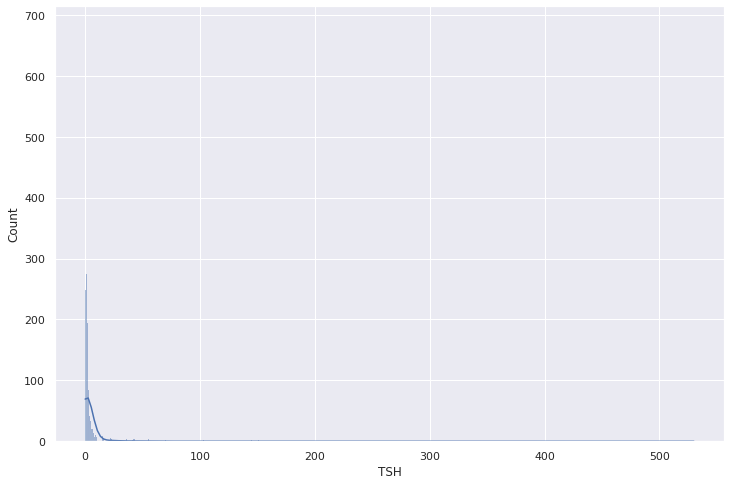

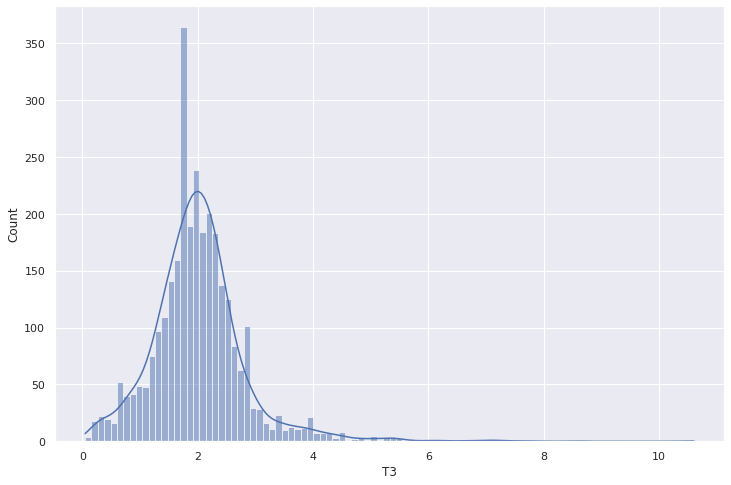

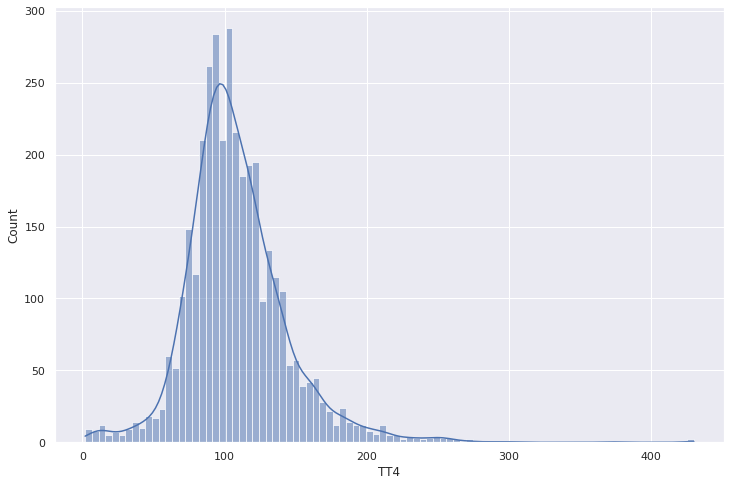

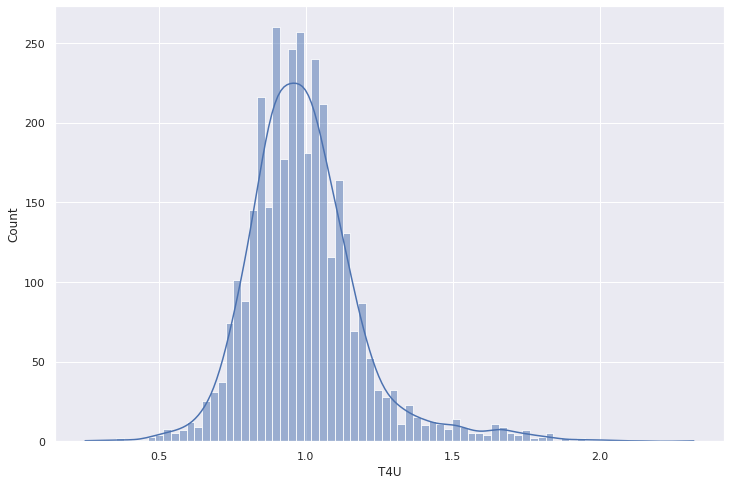

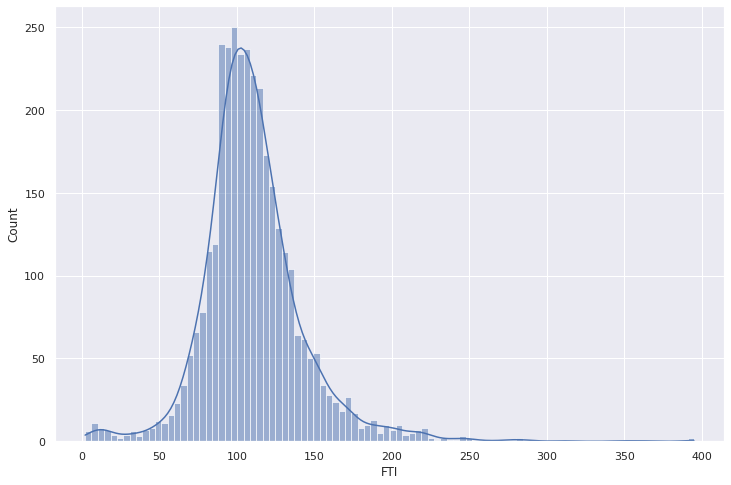

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
for column in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  sns.histplot(df[column], kde=True)
  plt.show()

Most columns seem to be normally-like disributed. The exception is TSH as it looks like exponential distribution. 

Multivariative analysis

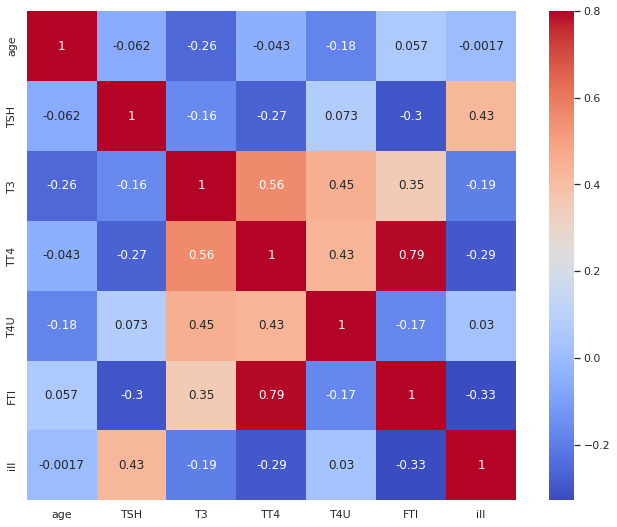

In [ ]:
df['ill'] = df['Class'].apply(lambda x: 0 if x == 'negative' else 1)
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap="coolwarm", vmax=.8, square=True, annot=True);
df.drop('ill', axis=1, inplace=True)

I've added additional bool column 'ill' which has value 1 for all ill classes and 0 for 'negative' to investigate correlation with target value. There aren't columns with huge correlation but 'FTI', 'TT4' and 'TSH' seem to be the most significant. Columns FTI and TT4 have very high correlation - 0.79.

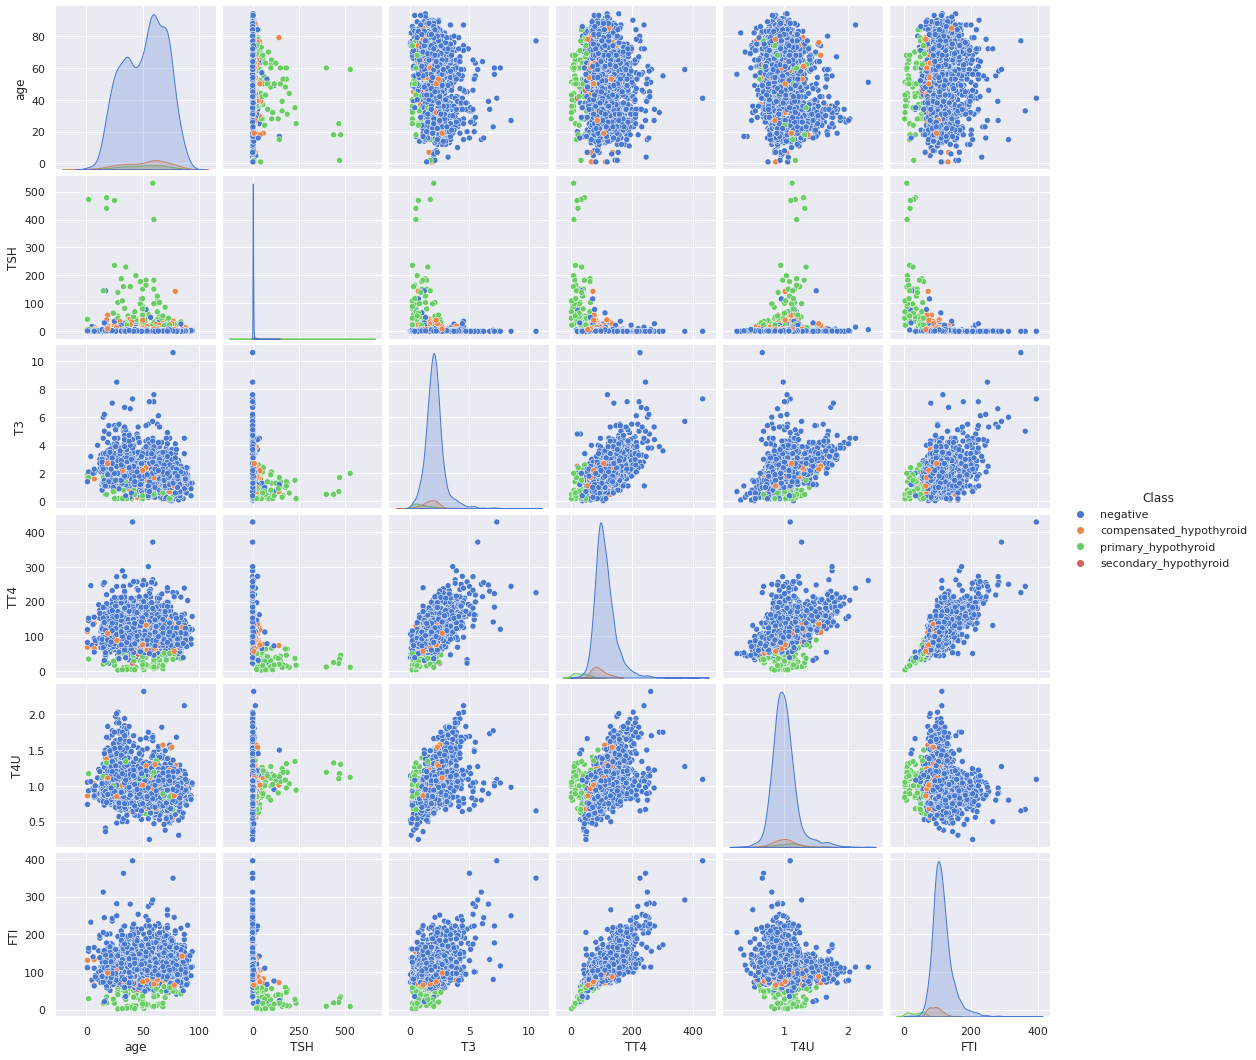

In [ ]:
sns.pairplot(df, hue='Class', palette='muted')

Paiplots ilustrate corrmap. FTI, TSH and FT4 seem to be the most related to target. FTI and TT4 indeed are very correlated, especially when the values are low but after that correlation decreses so i dont't think there is sense in dropping one of them.

referral_source is the only non-binary categorical feature so i'd like to know wheter there is link between target and this feature

<Axes: xlabel='referral_source', ylabel='Percent'>

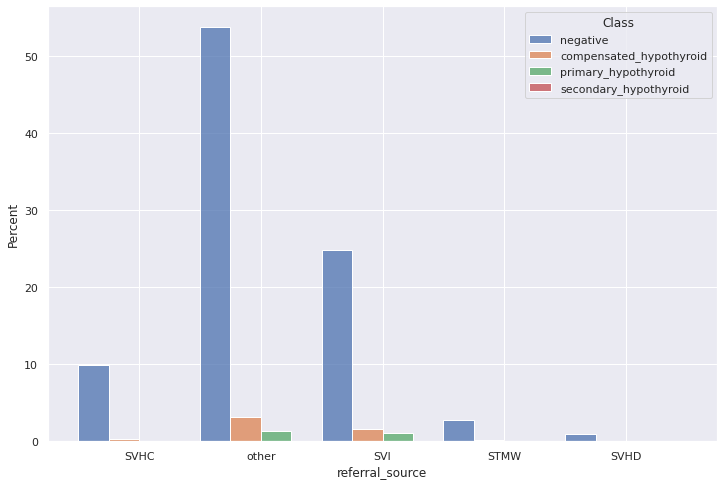

In [ ]:
sns.histplot(df, x='referral_source', hue='Class', multiple="dodge", stat='percent')

From above plot i dont see much link between target and referral_source. As there is no inner order between diffrent kinds of sourses i'd have to perform one-hot encoding and that would increase number of dimentions by 5. I think it is not that necessecery feature so i'll drop it.

### Data preprocessing 

#### Missing values

Firstly, let's see how much data is missing

In [ ]:
df.isnull().sum()/len(df)

age                          0.000530
sex                          0.039767
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
query_hyperthyroid           0.000000
lithium                      0.000000
goitre                       0.000000
tumor                        0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
TSH                          0.097826
T3_measured                  0.000000
T3                           0.203871
TT4_measured                 0.000000
TT4                          0.061241
T4U_measured                 0.000000
T4U                          0.102598
FTI_measured                 0.000000
FTI                          0.102068
TBG_measured

Most columns that contain missing data don't have more then 10 % missing. Only one column - T3 misses 20%. Let's find out if missing columns are all the same.

In [ ]:
missing = df[df[['TSH', 'T3', 'TT4', 'T4U', 'FTI']].isnull().all(axis=1)]
missing

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
39    64.0   F            f                  f                         f    f   
66    69.0   F            f                  f                         f    f   
72    59.0   F            f                  f                         f    t   
92    26.0   F            f                  f                         f    f   
104   57.0   F            f                  f                         f    f   
...    ...  ..          ...                ...                       ...  ...   
3707  51.0   F            f                  f                         f    f   
3745  59.0   F            f                  f                         f    f   
3752  71.0   F            f                  f                         f    f   
3763  41.0   F            f                  f                         f    f   
3767  30.0   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  T3  \
39          f               f              f                 f  ... NaN   
66          f               f              f                 f  ... NaN   
72          f               f              f                 f  ... NaN   
92          f               f              f                 f  ... NaN   
104         f               f              f                 f  ... NaN   
...       ...             ...            ...               ...  ...  ..   
3707        f               f              f                 f  ... NaN   
3745        f               f              f                 f  ... NaN   
3752        f               f              f                 f  ... NaN   
3763        f               f              f                 f  ... NaN   
3767        f               f              f                 f  ... NaN   

     TT4_measured TT4 T4U_measured T4U FTI_measured FTI  TBG_measured  \
39              f NaN            f NaN            f NaN             f   
66              f NaN            f NaN            f NaN             f   
72              f NaN            f NaN            f NaN             f   
92              f NaN            f NaN            f NaN             f   
104             f NaN            f NaN            f NaN             f   
...           ...  ..          ...  ..          ...  ..           ...   
3707            f NaN            f NaN            f NaN             f   
3745            f NaN            f NaN            f NaN             f   
3752            f NaN            f NaN            f NaN             f   
3763            f NaN            f NaN            f NaN             f   
3767            f NaN            f NaN            f NaN             f   

     referral_source     Class  
39             other  negative  
66             other  negative  
72             other  negative  
92             other  negative  
104            other  negative  
...              ...       ...  
3707           other  negative  
3745           other  negative  
3752           other  negative  
3763           other  negative  
3767           other  negative  

[179 rows x 29 columns]

Yes, 179 rows don't contain any numerical info apart from age. let's find out if all other columns are also the same.

In [ ]:
missing[missing.duplicated(df.columns.drop('age'), keep=False)]

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
39    64.0   F            f                  f                         f    f   
66    69.0   F            f                  f                         f    f   
72    59.0   F            f                  f                         f    t   
92    26.0   F            f                  f                         f    f   
104   57.0   F            f                  f                         f    f   
...    ...  ..          ...                ...                       ...  ...   
3707  51.0   F            f                  f                         f    f   
3745  59.0   F            f                  f                         f    f   
3752  71.0   F            f                  f                         f    f   
3763  41.0   F            f                  f                         f    f   
3767  30.0   F            f                  f                         f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  T3  \
39          f               f              f                 f  ... NaN   
66          f               f              f                 f  ... NaN   
72          f               f              f                 f  ... NaN   
92          f               f              f                 f  ... NaN   
104         f               f              f                 f  ... NaN   
...       ...             ...            ...               ...  ...  ..   
3707        f               f              f                 f  ... NaN   
3745        f               f              f                 f  ... NaN   
3752        f               f              f                 f  ... NaN   
3763        f               f              f                 f  ... NaN   
3767        f               f              f                 f  ... NaN   

     TT4_measured TT4 T4U_measured T4U FTI_measured FTI  TBG_measured  \
39              f NaN            f NaN            f NaN             f   
66              f NaN            f NaN            f NaN             f   
72              f NaN            f NaN            f NaN             f   
92              f NaN            f NaN            f NaN             f   
104             f NaN            f NaN            f NaN             f   
...           ...  ..          ...  ..          ...  ..           ...   
3707            f NaN            f NaN            f NaN             f   
3745            f NaN            f NaN            f NaN             f   
3752            f NaN            f NaN            f NaN             f   
3763            f NaN            f NaN            f NaN             f   
3767            f NaN            f NaN            f NaN             f   

     referral_source     Class  
39             other  negative  
66             other  negative  
72             other  negative  
92             other  negative  
104            other  negative  
...              ...       ...  
3707           other  negative  
3745           other  negative  
3752           other  negative  
3763           other  negative  
3767           other  negative  

[167 rows x 29 columns]

167 of them are duplicates so those i certainly drop

In [ ]:
df.drop_duplicates(df.columns.drop('age'), inplace=True)

In [ ]:
missing = df[df[['TSH', 'T3', 'TT4', 'T4U', 'FTI']].isnull().all(axis=1)]
missing

age  sex on_thyroxine query_on_thyroxine on_antithyroid_medication  \
39    64.0    F            f                  f                         f   
72    59.0    F            f                  f                         f   
150   17.0    F            f                  f                         f   
231   70.0    M            f                  f                         f   
443   41.0    F            f                  f                         f   
512   65.0    F            f                  f                         f   
622   64.0    F            t                  f                         f   
685   63.0  NaN            f                  f                         f   
700   25.0    M            f                  f                         f   
726   41.0    F            t                  f                         f   
755   44.0    F            f                  f                         f   
929   72.0    F            f                  f                         f   
957   61.0    M            f                  f                         f   
1000  38.0    M            t                  f                         f   
1235  13.0    F            f                  f                         f   
1241  31.0    M            t                  f                         f   
1249  11.0    F            f                  f                         t   
1250  56.0    M            f                  f                         f   
1665  57.0    F            t                  f                         f   
2408  15.0    F            f                  f                         t   
2469  69.0    M            f                  f                         f   
2648  72.0  NaN            f                  f                         f   
2919  69.0    F            f                  f                         f   
3028  21.0    F            f                  f                         f   
3143  38.0    F            f                  f                         f   
3166  41.0    F            f                  f                         f   

     sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  T3  \
39      f        f               f              f                 f  ... NaN   
72      t        f               f              f                 f  ... NaN   
150     f        f               f              f                 f  ... NaN   
231     f        f               f              f                 f  ... NaN   
443     f        f               f              f                 f  ... NaN   
512     t        f               f              f                 t  ... NaN   
622     f        f               f              f                 f  ... NaN   
685     f        f               f              f                 f  ... NaN   
700     f        f               f              f                 f  ... NaN   
726     f        f               f              f                 f  ... NaN   
755     f        f               f              f                 f  ... NaN   
929     t        f               f              f                 f  ... NaN   
957     t        f               f              f                 f  ... NaN   
1000    f        f               f              f                 t  ... NaN   
1235    f        f               f              f                 t  ... NaN   
1241    f        f               f              f                 f  ... NaN   
1249    f        f               f              f                 f  ... NaN   
1250    f        f               f              f                 f  ... NaN   
1665    f        f               f              f                 t  ... NaN   
2408    f        f               f              f                 f  ... NaN   
2469    f        f               f              f                 f  ... NaN   
2648    t        f               f              f                 f  ... NaN   
2919    t        f               f              f                 f  ... NaN   
3028   

Other 26 rows are all have negative class (the most frequent one) and are also highly duplicative so i'll drop them too.

In [ ]:
df.dropna(how='all', subset=['TSH', 'T3', 'TT4', 'T4U', 'FTI'], inplace=True)

In [ ]:
df.Class.value_counts()

negative                   3294
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64

In [ ]:
df.isnull().sum()/len(df)

age                          0.000558
sex                          0.040167
on_thyroxine                 0.000000
query_on_thyroxine           0.000000
on_antithyroid_medication    0.000000
sick                         0.000000
pregnant                     0.000000
thyroid_surgery              0.000000
I131_treatment               0.000000
query_hypothyroid            0.000000
query_hyperthyroid           0.000000
lithium                      0.000000
goitre                       0.000000
tumor                        0.000000
hypopituitary                0.000000
psych                        0.000000
TSH_measured                 0.000000
TSH                          0.051325
T3_measured                  0.000000
T3                           0.164575
TT4_measured                 0.000000
TT4                          0.012831
T4U_measured                 0.000000
T4U                          0.056346
FTI_measured                 0.000000
FTI                          0.055788
TBG_measured

### Data transformations

Most of the distributions are severely skewed so i'll try some transformations on them.

In [ ]:
num_cols = ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI')
res = [[st.normaltest(np.log(df[col]), nan_policy='omit') for col in num_cols]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=num_cols)
norm_h0

[[NormaltestResult(statistic=1571.68765338349, pvalue=0.0), NormaltestResult(statistic=218.2224477522723, pvalue=4.1076890177336965e-48), NormaltestResult(statistic=1189.8660120392515, pvalue=4.206088278774304e-259), NormaltestResult(statistic=2278.025040579305, pvalue=0.0), NormaltestResult(statistic=243.17285411819282, pvalue=1.5692265734261836e-53), NormaltestResult(statistic=2600.0407503970373, pvalue=0.0)]]


age                                          TSH  \
0  (1571.68765338349, 0.0)  (218.2224477522723, 4.1076890177336965e-48)   

                                             T3                       TT4  \
0  (1189.8660120392515, 4.206088278774304e-259)  (2278.025040579305, 0.0)   

                                            T4U                        FTI  
0  (243.17285411819282, 1.5692265734261836e-53)  (2600.0407503970373, 0.0)

In [ ]:
res = [[st.normaltest(df[col], nan_policy='omit') for col in num_cols]]
print(res)
norm_h0 = pd.DataFrame(data=res, columns=num_cols)
norm_h0

[[NormaltestResult(statistic=509.4836610523055, pvalue=2.3282450728850186e-111), NormaltestResult(statistic=6317.299964783477, pvalue=0.0), NormaltestResult(statistic=1281.283371012964, pvalue=5.927220820727865e-279), NormaltestResult(statistic=1076.7355223344223, pvalue=1.5482892216320525e-234), NormaltestResult(statistic=865.0220675056678, pvalue=1.4549386431045578e-188), NormaltestResult(statistic=1134.316352555169, pvalue=4.856614993979019e-247)]]


age                       TSH  \
0  (509.4836610523055, 2.3282450728850186e-111)  (6317.299964783477, 0.0)   

                                            T3  \
0  (1281.283371012964, 5.927220820727865e-279)   

                                             TT4  \
0  (1076.7355223344223, 1.5482892216320525e-234)   

                                            T4U  \
0  (865.0220675056678, 1.4549386431045578e-188)   

                                           FTI  
0  (1134.316352555169, 4.856614993979019e-247)

Those hypothesis tests are do not give much info so i'll make qqplots to visually analize data.

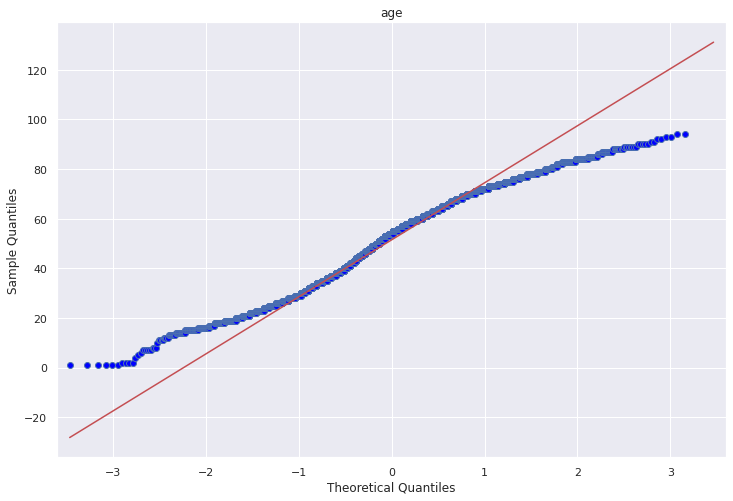

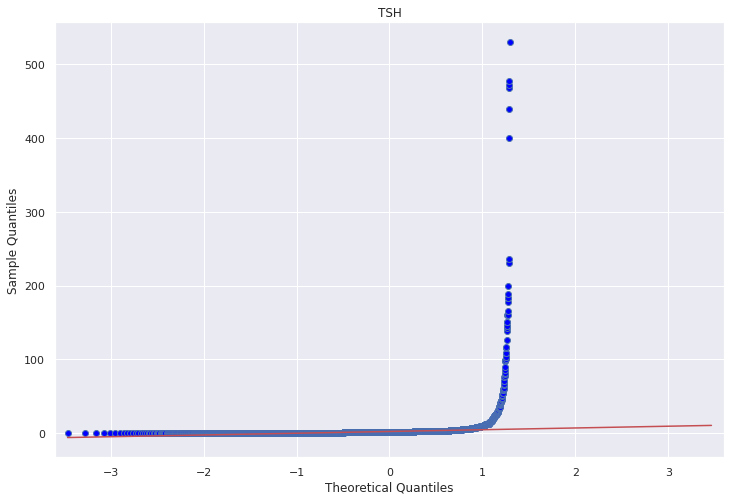

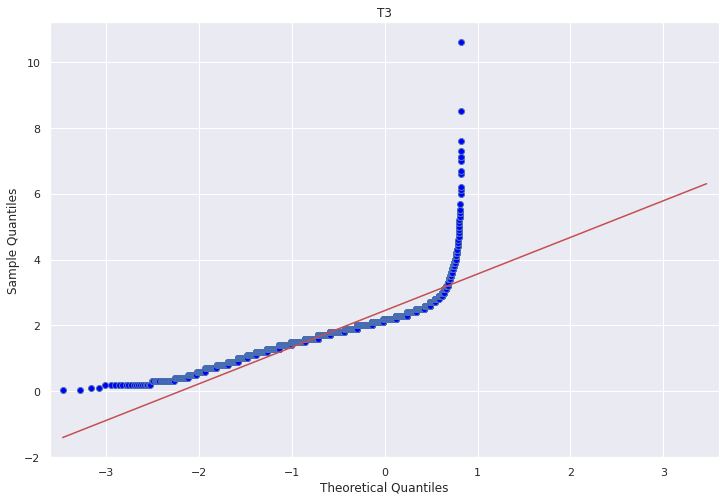

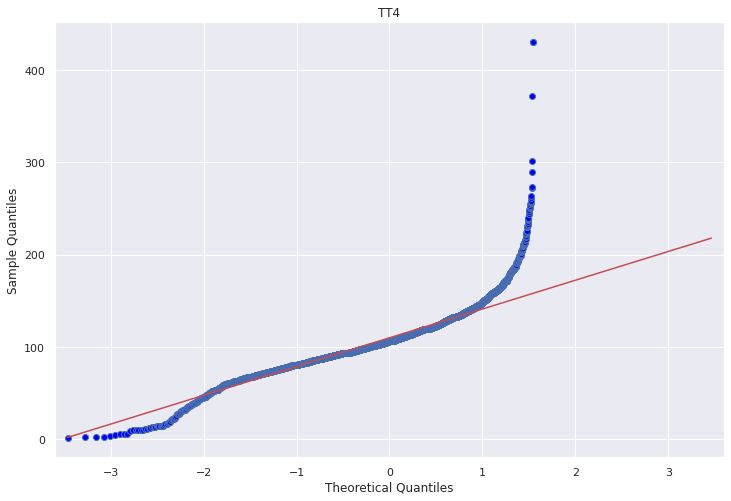

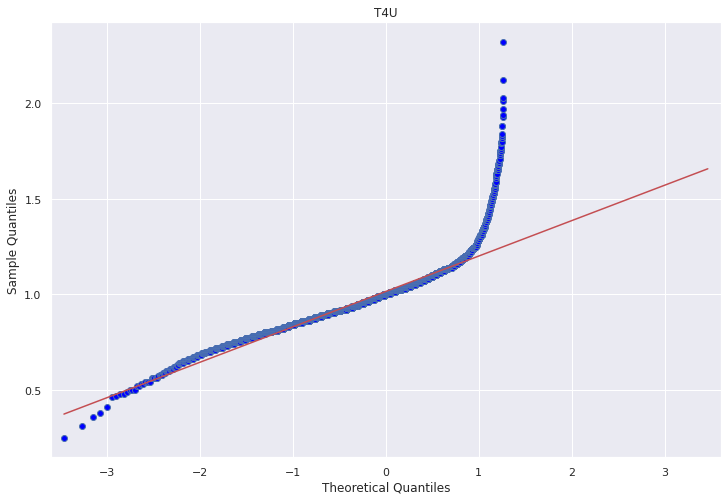

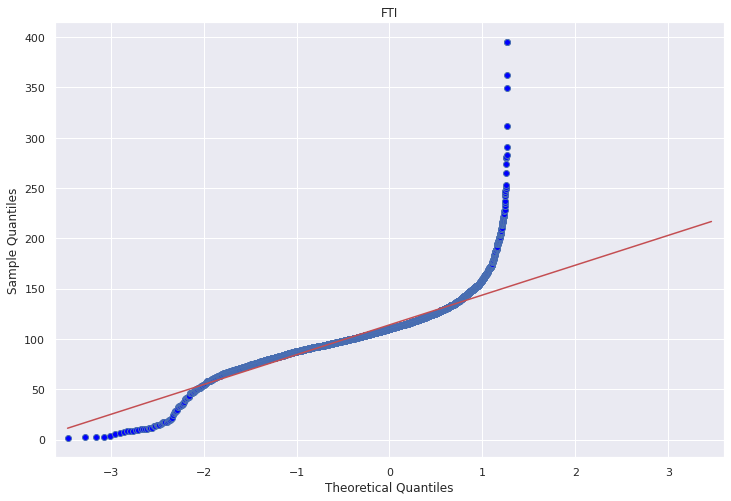

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(df[col], line='q')
  plt.title(col)
  plt.show()

From above qqplots i see that most columns have a very long right tail and only 'age is really close to be normal. Let's tru log transformation

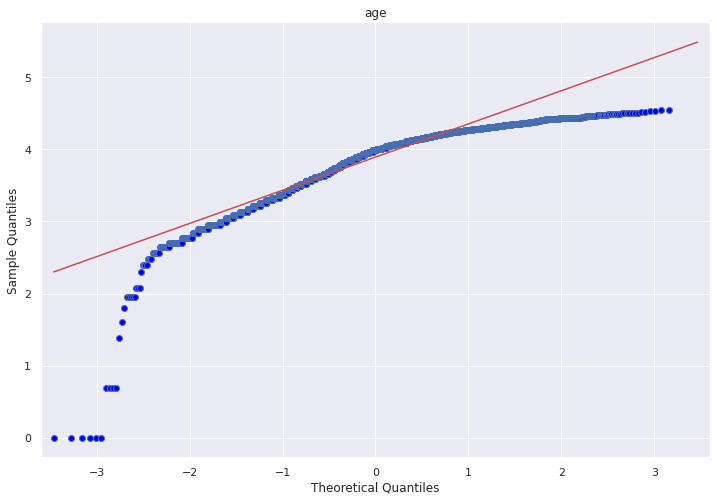

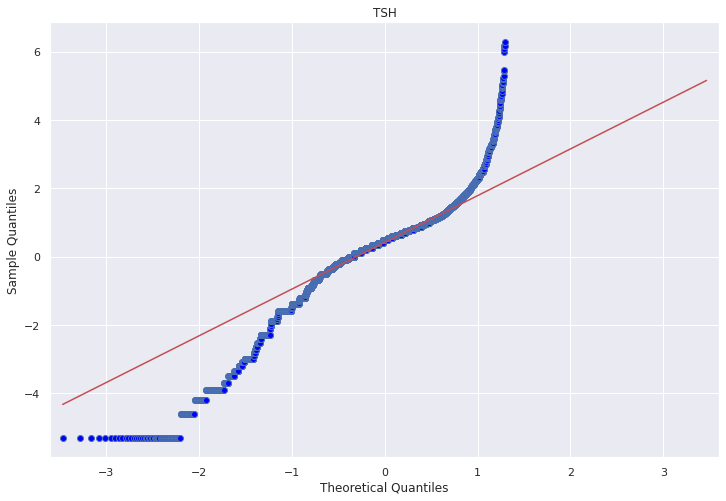

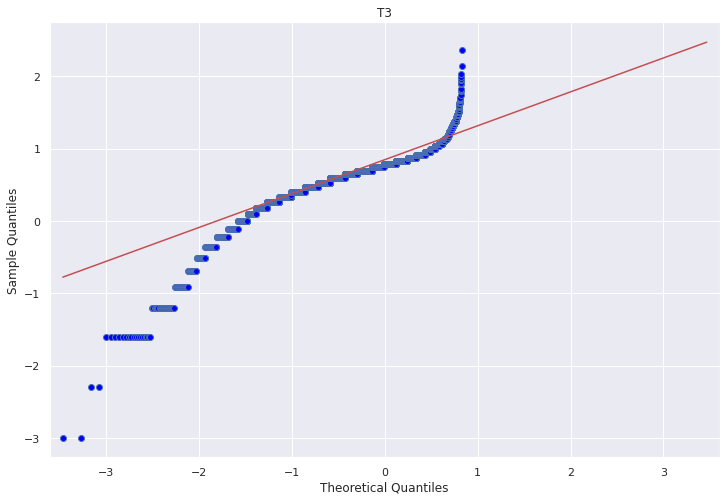

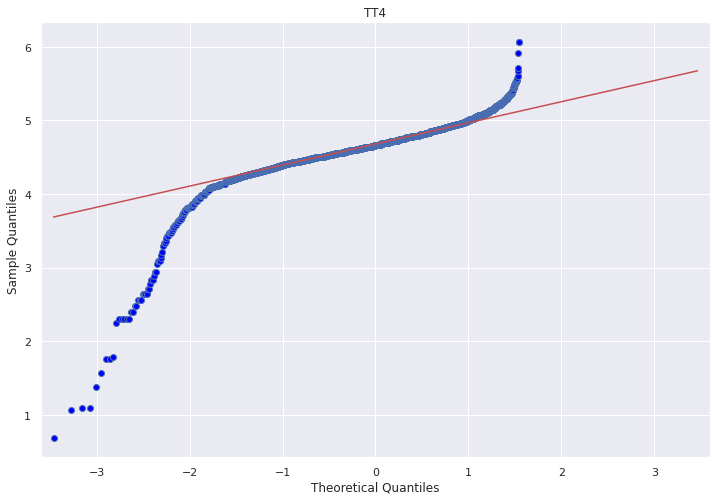

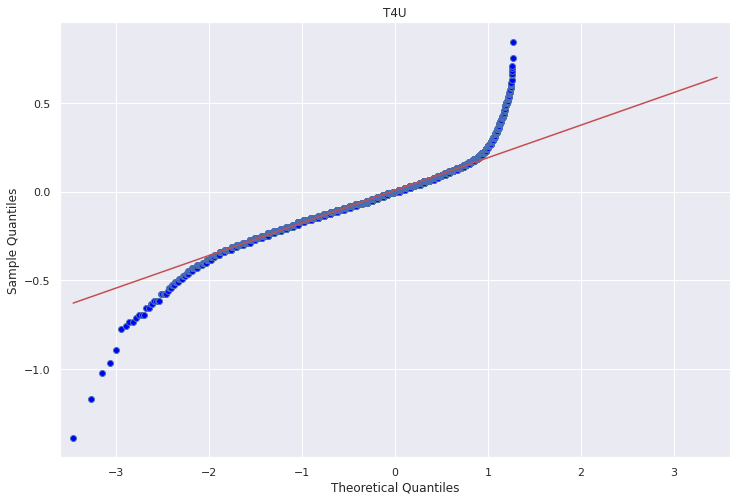

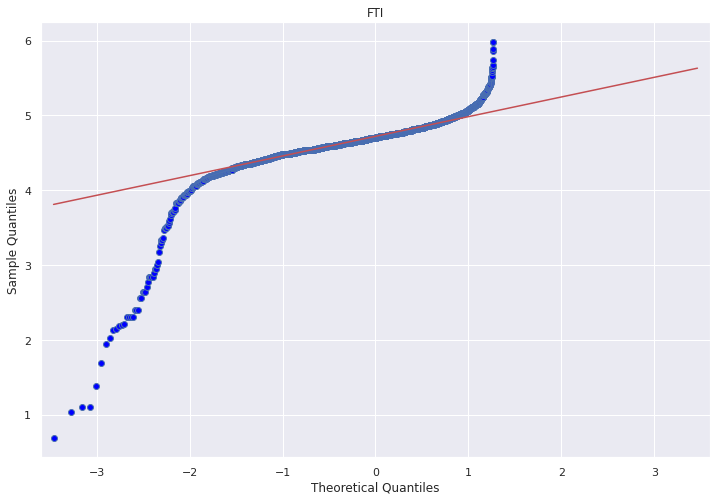

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(np.log(df[col]), line='q')
  plt.title(col)
  plt.show()

Log didn't really solve the problem as we still have problem with right tails but now little values are also smaller then they theoretically need to be. I'll try a bit softer sqrt transformation.

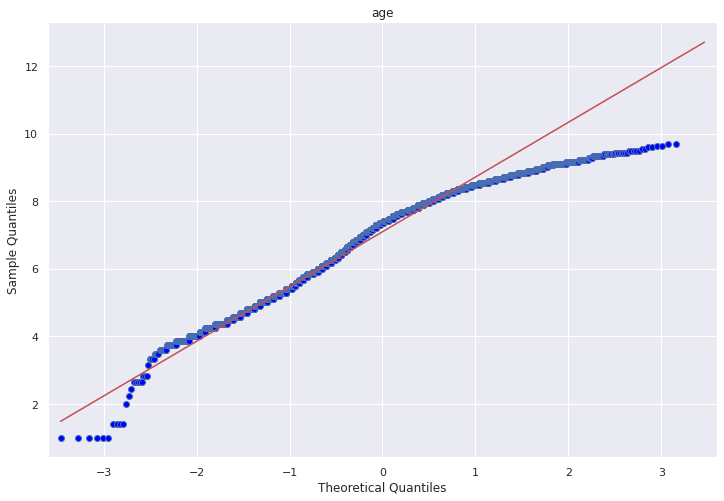

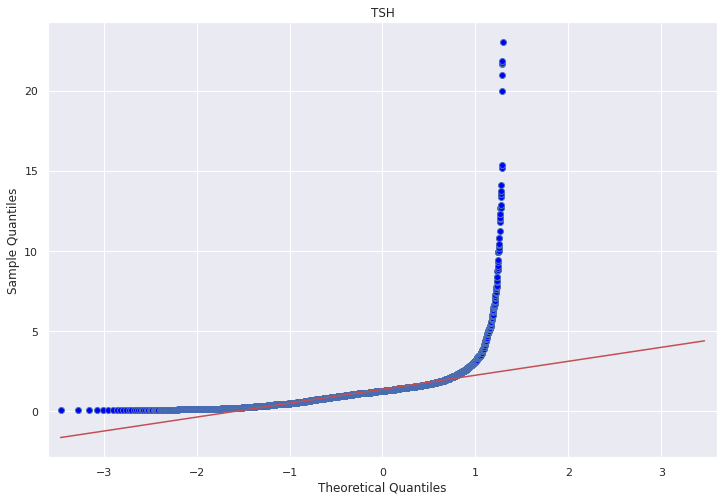

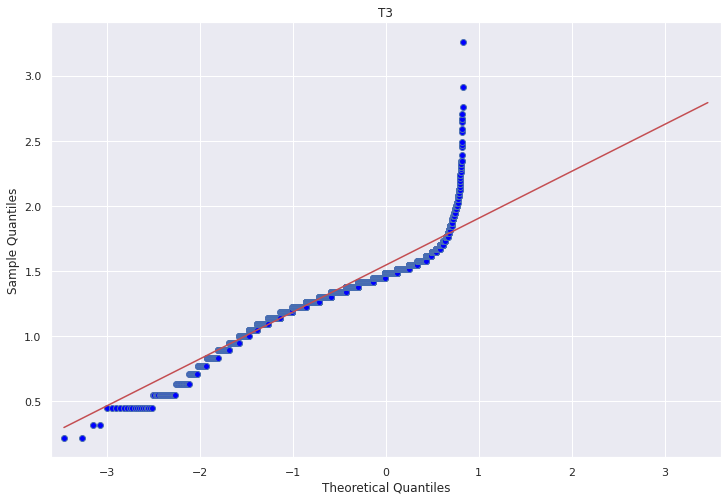

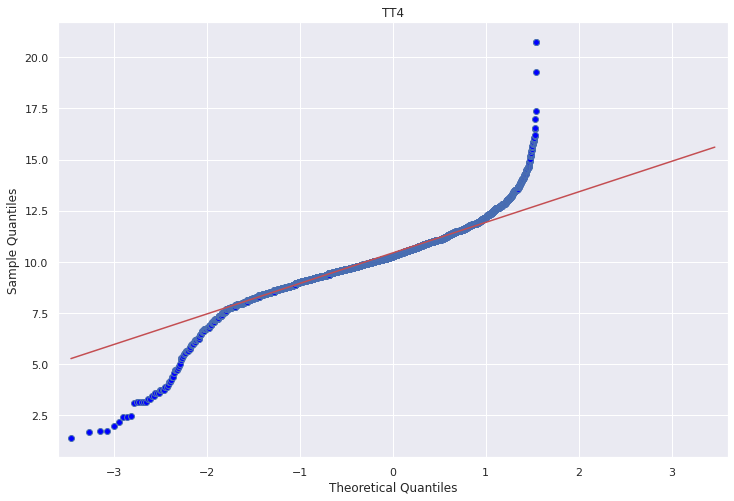

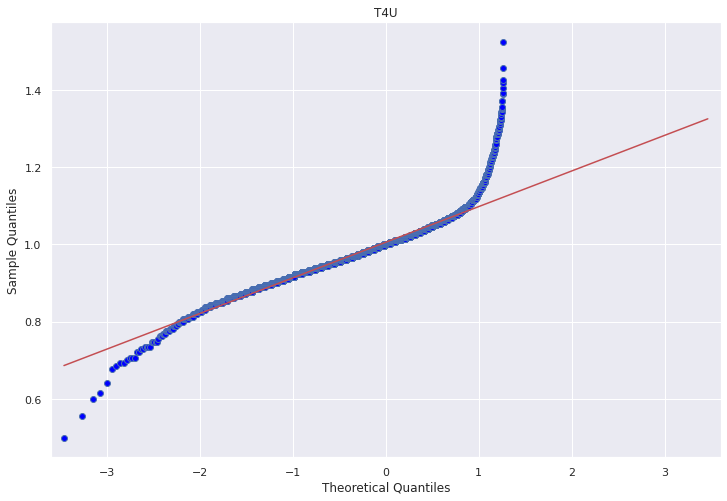

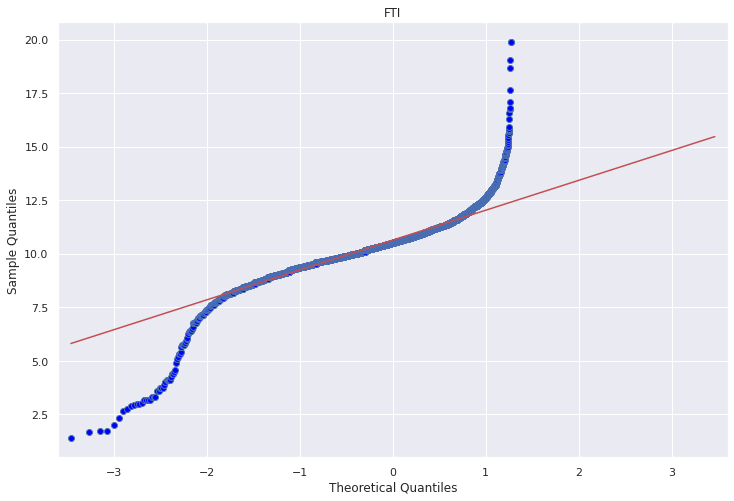

In [ ]:
for col in ('age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI'):
  fig = sm.qqplot(np.sqrt(df[col]), line='q')
  plt.title(col)
  plt.show()

Although the data is still not quite normally distributed, sqrt seem to be better then both log and untransformed data.

In [ ]:
df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']] = np.sqrt(df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']])

### Pipeline

All the remaining missing data i'm going to impute using KNNImputer after I encode categorical data so that categorical data was also used to make more accurate imputing. All the "_measure" columns that show wheather there is numerical feature or not are redundant as they only tell us if the value was imputed and they significantly increase dimentions, so i'll drop them. As i've mentioned earlier, i'll drop referral_source feature. In fact, i also have an idea of dropping 2 rows that represent 4 class which i am not sure about. On one hand, our model is about classifing illnesses so the risk of misclassifing a severy ill person is very high. One the other hand, 2 istances is clearly not enough to catch the pattern, especially if one of them is in train and other is in test set. All in all, i'm going to drop them in order to use macro avaraging to give all the remaining classes equall importance as I think this case correctly classifing ill people is more important then correctly classifing the healthy (if we had 2 classes - recall would have been more important then precision).

In [ ]:
df = df.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'FTI_measured', 'TBG_measured', 'referral_source'], axis=1)
df = df.drop(df[df['Class'] == 'secondary_hypothyroid'].index)

To perform all necessary transformation i'm going to use pipeline which will contain OrdinalEncoder, KNNImputer and StandardScaler.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], random_state=SEED, shuffle=True, stratify=df['Class'])
encode = ColumnTransformer([('encoder', OrdinalEncoder(), X_train.select_dtypes(exclude='number').columns)], remainder='passthrough')
pipe = Pipeline([('encode', encode), ('imputer', KNNImputer()), ('scaler', StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

### ML models

As the data is not time-series i can use default cv and shuffle to tune hyperparametrs. As target value is very unbalanced('negative' values is about 90%) we can't use default accuracy and i'm going to use f2 score - harmonic average of precision and recall with more importance to recall. As i don't know how the model would be used i cannot make fully valid desicion on what type of averaging to use. Intuitively, all of our classes should be equaly important as it might be very dangerous to misclassify an ill person as healthy. At the same time, our classes are imbalanced and it will be unadequate to give all classes exactly equall weight so i'll use both macro and weighted averaging for scoring but will use macro averaging for hyperparameters tuning.

In [ ]:
def evaluate(y_true, X, model):
  f2score = fbeta_score(y_true, model.predict(X), beta=2, average='macro')
  print(f'F2 score = {f2score}')
  report = classification_report(y_true, model.predict(X), digits=3)
  print('Classification Report:')
  print(report)
  return report, f2score


First, let's try baseline logistic regression model

In [ ]:
log_model = LogisticRegression().fit(X_train, y_train)
evaluate(y_test, X_test, log_model);

F2 score = 0.7144177043143438
Classification Report:
              precision    recall  f1-score   support

           0      0.722     0.271     0.394        48
           1      0.957     0.994     0.975       824
           2      0.909     0.833     0.870        24

    accuracy                          0.951       896
   macro avg      0.863     0.699     0.746       896
weighted avg      0.943     0.951     0.941       896



as a pinncale of classification methods, I'll use catboost classifier.

In [ ]:
clf = CatBoostClassifier(random_state=SEED, verbose=False)
cat_clf = clf.fit(X_train, y_train)

In [ ]:
evaluate(y_test, X_test, cat_clf);

F2 score = 0.9334768061843096
Classification Report:
              precision    recall  f1-score   support

           0      0.840     0.875     0.857        48
           1      0.994     0.989     0.991       824
           2      0.885     0.958     0.920        24

    accuracy                          0.982       896
   macro avg      0.906     0.941     0.923       896
weighted avg      0.983     0.982     0.982       896



It gives nearly perfect results.

In [ ]:
def conf_matrix(y, predictions, title):
  conf = confusion_matrix(y, predictions, normalize='true')
  sns.heatmap(conf,
              annot=conf/np.sum(conf,axis=1), #normalized by true class sizes
              yticklabels=np.unique(y),
              xticklabels=np.unique(y));
  plt.title(title);
  plt.xlabel('Predicted label');
  plt.ylabel('True label');

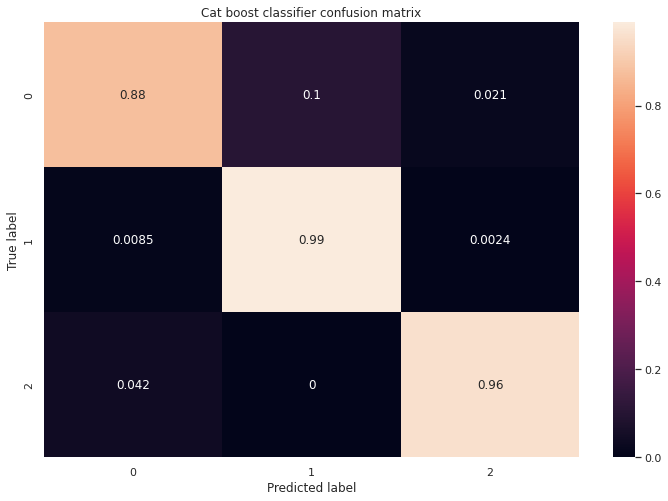

In [ ]:
conf_matrix(y_test, cat_clf.predict(X_test), 'Cat boost classifier confusion matrix')

## Deep learning solution

### Data transformation

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [ ]:
y_train.shape

torch.Size([2687, 1])

For validationg results while choosing the best epoch of my model I'm going to split test set on validation and test. Validation size will be half of previous test size which is 25% of dataset

In [ ]:
X_val = X_test[:len(X_test)//2, :]
X_test = X_test[len(X_test)//2:, :]
y_val = y_test[:len(y_test)//2]
y_test = y_test[len(y_test)//2:]

In [ ]:
y_train.squeeze_()
y_val.squeeze_()
y_test.squeeze_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 2., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [ ]:
y_train = y_train.type(torch.LongTensor)
y_val = y_val.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

In [ ]:
X_train[:, 0]

tensor([-0.6948, -0.6948, -0.6948,  ...,  1.4821,  1.4821, -0.6948])

In [ ]:
class PartDataset(Dataset):
    """Students Performance dataset."""

    def __init__(self, X, y):
        # Save target and predictors
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


In [ ]:
train = PartDataset(X_train, y_train)
val = PartDataset(X_val, y_val)
test = PartDataset(X_test, y_test)

### Basic model

Firstly, I'll try primitive model with 2 hidden layers and neither normalization nor reguralization.

In [ ]:
def train_clf(model, n_epochs=50, batch_size=64, disable_bar=False, early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val = []
  history_tr = []
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()
      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")
      for X_batch, y_batch in loop :
          # take a batch
          # X_batch = X_train[start:start+batch_size]
          # y_batch = y_train[start:start+batch_size]
          # forward pass
          y_pred = model(X_batch)
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          model.get_optimizer().zero_grad()
          loss.backward()
          # update weights
          model.get_optimizer().step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
      # evaluate accuracy at end of each epoch
      model.eval()
      y_pred = model(X_val)
      y_pred_tr = model(X_train)
      loss_val = loss_fn(y_pred, y_val).item()
      history_val.append(loss_val)
      loss_tr = loss_fn(y_pred_tr, y_train).item()
      history_tr.append(loss_tr)
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if early_stop:
        if epoch > 3 and abs(history_val[-3] - history_val[-2]) < 0.001 and abs(history_val[-2] - history_val[-1]) < 0.001:
          print('')
          print('Early stop: plato found')
          break
        if epoch > 10 and (np.mean(history_val[-10: -5]) - np.mean(history_val[-5:])) < 0:
          print('')
          print('Early stop: error increasing')
          break
      
  return history_tr, history_val, best_weights

In [ ]:
class CLFNetwork(nn.Module):
  def __init__(self, input_len, learning_rate=0.01):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 3)
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = F.softmax(self.fc3(x))
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
def evaluate_clf(y_true, y_pred):
  f2score = fbeta_score(y_true, y_pred, beta=2, average='macro')
  print(f'F2 score = {f2score}')
  report = classification_report(y_true, y_pred, digits=3)
  print('Classification Report:')
  print(report)
  return report, f2score

In [ ]:
basic_clf = CLFNetwork(X_train.size()[-1])

In [ ]:
history_tr, history_tst, best_weights = train_clf(basic_clf, 50, 28, early_stop=True)

Epoch 0:   0%|          | 0/96 [00:00<?, ?batch/s]<ipython-input-381-c4a4c626a05e>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))
Epoch 20: 100%|██████████| 96/96 [00:00<00:00, 136.10batch/s, mse=0.589]



Early stop: error increasing


Best val Entropy = 0.7565543358420199


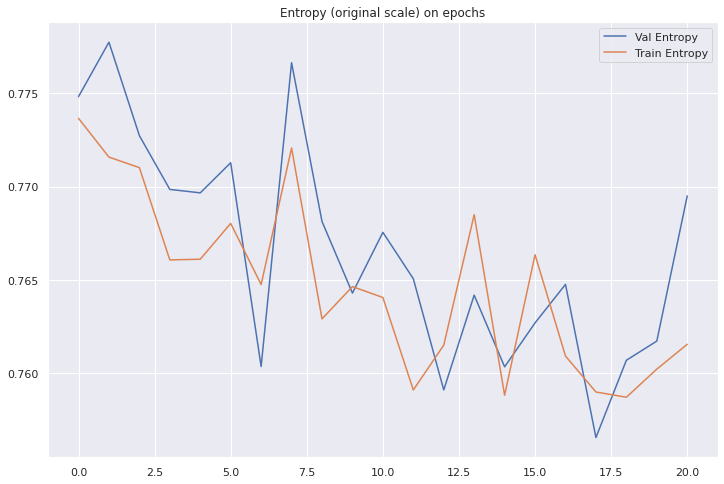

In [ ]:
basic_clf.load_state_dict(best_weights)
show_results(history_tr, history_tst, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(basic_clf(X_test), 1).detach().numpy());

F2 score = 0.7564581796663709
Classification Report:
              precision    recall  f1-score   support

           0      0.586     0.773     0.667        22
           1      0.985     0.988     0.987       410
           2      1.000     0.500     0.667        16

    accuracy                          0.960       448
   macro avg      0.857     0.754     0.773       448
weighted avg      0.966     0.960     0.959       448



<ipython-input-381-c4a4c626a05e>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


The results are ok - the entropy gets generally smaller by epochs and the result is already better then logistic regression. I'll try to add normalization to this model and the make it a bit more complicated.

### More advanced models

In [ ]:
class CLFNetworkNorm(nn.Module):
  def __init__(self, input_len=22, learning_rate=0.005, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.m2 = nn.BatchNorm1d(32)
    # self.fc3 = nn.Linear(64, 16)
    self.m1 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(32, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = self.m1(x)
     x = F.relu(self.fc2(x))
     x = self.m2(x)
    #  x = F.relu(self.fc3(x))
    #  x = self.m3(x)
     x = F.softmax(self.fc4(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
norm_clf = CLFNetworkNorm(X_train.size()[-1])

In [ ]:
history_tr, history_val, best_weights = train_clf(norm_clf, 50, 42, early_stop=True)

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 141.09batch/s, mse=0.551]



Early stop: error increasing


Best val Entropy = 0.7527522609072419


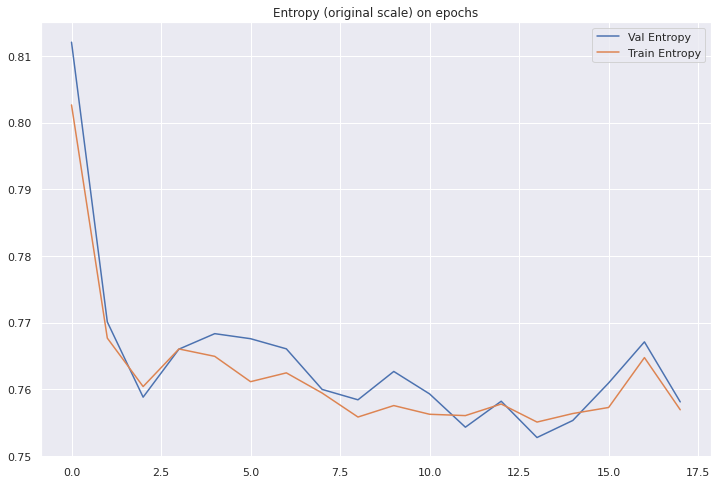

In [ ]:
norm_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(norm_clf(X_test), 1).detach().numpy());

F2 score = 0.8410115907982801
Classification Report:
              precision    recall  f1-score   support

           0      0.708     0.773     0.739        22
           1      0.983     0.985     0.984       410
           2      0.923     0.750     0.828        16

    accuracy                          0.967       448
   macro avg      0.871     0.836     0.850       448
weighted avg      0.967     0.967     0.967       448



The results got better. I'll try adding more layers.

In [ ]:
class CLFNetworkPlus(nn.Module):
  def __init__(self, input_len=22, learning_rate=0.005, weight_decay=1e-6):
    super().__init__()
    self.fc1 = nn.Linear(input_len, 64)
    self.fc2 = nn.Linear(64, 32)
    self.m2 = nn.BatchNorm1d(32)
    self.fc3 = nn.Linear(32, 16)
    self.m3 = nn.BatchNorm1d(16)
    #self.m1 = nn.BatchNorm1d(64)
    self.fc4 = nn.Linear(16, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = F.relu(self.fc2(x))
     x = self.m2(x)
     x = F.relu(self.fc3(x))
     x = self.m3(x)
     x = F.softmax(self.fc4(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
plus_clf = CLFNetworkPlus(X_train.size()[-1])

In [ ]:
history_tr, history_val, best_weights = train_clf(plus_clf, 50, 42, early_stop=True)

Epoch 13: 100%|██████████| 64/64 [00:00<00:00, 117.50batch/s, mse=0.6]


Early stop: error increasing


Best val Entropy = 0.7501743034632882


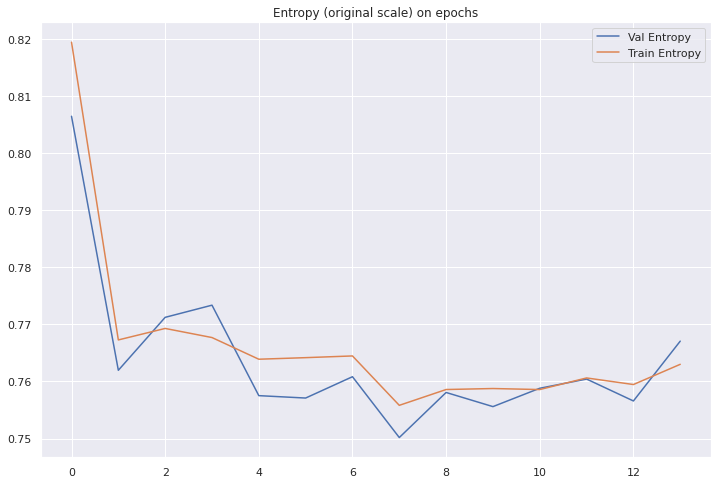

In [ ]:
plus_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(plus_clf(X_test), 1).detach().numpy());

F2 score = 0.7749635405868359
Classification Report:
              precision    recall  f1-score   support

           0      0.632     0.545     0.585        22
           1      0.974     0.988     0.981       410
           2      0.923     0.750     0.828        16

    accuracy                          0.958       448
   macro avg      0.843     0.761     0.798       448
weighted avg      0.955     0.958     0.956       448



The result didn't get better. I'll try tuning hyperparameters on previous architecture.

### Hyperparameters tuning

In [ ]:
class CLFNetworkPlusHyper(nn.Module):
  def __init__(self, input_len=22, n1=64, n2=32, learning_rate=0.005, weight_decay=0):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n1)
    self.m1 = nn.BatchNorm1d(n1)
    self.fc2 = nn.Linear(n1, n2)
    self.m2 = nn.BatchNorm1d(n2)
    # self.fc3 = nn.Linear(64, 16)
    self.fc3 = nn.Linear(n2, 3)
    self.weight_decay = weight_decay
    self.learning_rate = learning_rate
    # self.d1 = nn.Dropout(p=p1)
    #self.d2 = nn.Dropout(p=p2)
  
  def forward(self, x):
     x = F.relu(self.fc1(x))
     x = self.m1(x)
     #x = self.d1(x)
     x = F.relu(self.fc2(x))
     x = self.m2(x)
    # x = self.d2(x)
    #  x = F.relu(self.fc3(x))
    #  x = self.m3(x)
     x = F.softmax(self.fc3(x), 1)
     return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
      return optimizer

In [ ]:
def objective(trial):
    params_model = {'n1': trial.suggest_int('n1', 8, 128, 8),
                    'n2': trial.suggest_int('n2', 8, 64, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01, log=True),
                    'weight_decay': trial.suggest_float('weight_decay', 1e-8, 1, log=True)
    }
    clf = CLFNetworkPlusHyper(X_train.size()[-1], **params_model)
    history_tr, history_val, best_weights = train_clf(clf, 50, 32, disable_bar=True)
    clf.load_state_dict(best_weights)
    clf.eval()
    score = fbeta_score(y_test.detach().numpy(), torch.argmax(clf(X_test), 1).detach().numpy(), beta=2, average='macro')
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2023-03-25 15:19:31,362] A new study created in memory with name: no-name-a1c73a96-e88b-43c8-8136-d5049ecf329d
/usr/local/lib/python3.9/dist-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]


Early stop: plato found
[I 2023-03-25 15:19:34,430] Trial 0 finished with value: 0.6994836653103448 and parameters: {'n1': 112, 'n2': 40, 'learning_rate': 0.0027053915786328887, 'weight_decay': 9.411961021000482e-06}. Best is trial 0 with value: 0.6994836653103448.

Early stop: error increasing
[I 2023-03-25 15:19:37,038] Trial 1 finished with value: 0.5942239787939665 and parameters: {'n1': 104, 'n2': 56, 'learning_rate': 0.005301500399388264, 'weight_decay': 0.050590894840381054}. Best is trial 0 with value: 0.6994836653103448.

Early stop: error increasing
[I 2023-03-25 15:19:39,798] Trial 2 finished with value: 0.7444697424311953 and parameters: {'n1': 128, 'n2': 32, 'learning_rate': 0.004711162502919193, 'weight_decay': 6.664311143676079e-08}. Best is trial 2 with value: 0.7444697424311953.

Early stop: error increasing
[I 2023-03-25 15:19:42,374] Trial 3 finished with value: 0.45970881615767767 and parameters: {'n1': 32, 'n2': 56, 'learning_rate': 0.0013722979988693164, 'weight_

In [ ]:
print('Best Validation Entropy: {}'.format(study.best_value))
print('Best Params: {}'.format(study.best_params))

Best Validation Entropy: 0.8268941064016307
Best Params: {'n1': 88, 'n2': 40, 'learning_rate': 0.0013953835417317704, 'weight_decay': 2.6988680097366353e-08}


In [ ]:
#par = {'n1': 96, 'n2': 120, 'n3': 72}
hyper_clf = CLFNetworkPlusHyper(X_train.size()[-1], **study.best_params)

In [ ]:
history_tr, history_val, best_weights = train_clf(hyper_clf, 50, 32, early_stop=False)

Epoch 49: 100%|██████████| 84/84 [00:00<00:00, 104.24batch/s, mse=0.551]


Best val Entropy = 0.7524789136169066


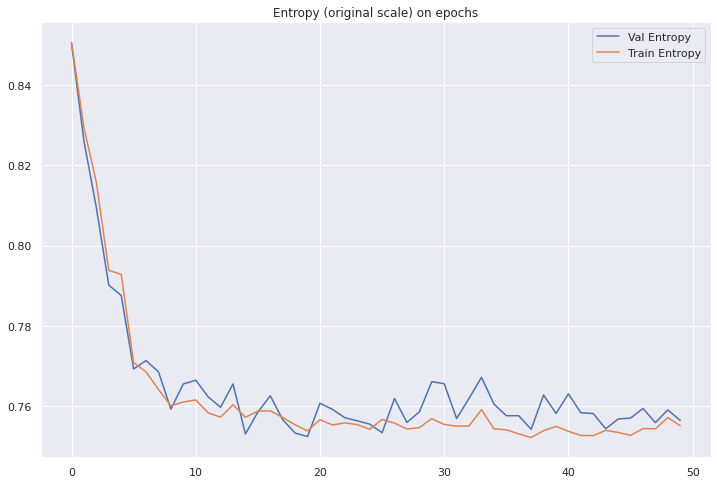

In [ ]:
hyper_clf.load_state_dict(best_weights)
show_results(history_tr, history_val, metric='Entropy')

In [ ]:
evaluate_clf(y_test.detach().numpy(), torch.argmax(hyper_clf(X_test), 1).detach().numpy());

F2 score = 0.7980856226470262
Classification Report:
              precision    recall  f1-score   support

           0      0.609     0.636     0.622        22
           1      0.981     0.985     0.983       410
           2      0.923     0.750     0.828        16

    accuracy                          0.960       448
   macro avg      0.837     0.791     0.811       448
weighted avg      0.960     0.960     0.960       448



Hyperparameters tuning didn't give much results so the best model is earlier one which has 0.84 f2 macro score. This result is better then common logistic regression solution by abou 10%, but is much worse then gradient boost classifier. Perhaps to create good DL model on tabular data we need more samples. 

# 3. Computer Vision

## Data Loading

In [ ]:
PATH = '/content/drive/MyDrive/datasets/hotdog__not_hotdog'
train_dir = PATH + '/train'
test_dir = PATH + '/test'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((200, 200)),
                                 ])

In [ ]:
train = datasets.ImageFolder(PATH + '/train', transform=transform)
test = datasets.ImageFolder(PATH + '/test', transform=transform)

In [ ]:
generator = torch.Generator().manual_seed(12)
val_subset, test_subset = random_split(test, [0.5, 0.5], generator=generator)

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


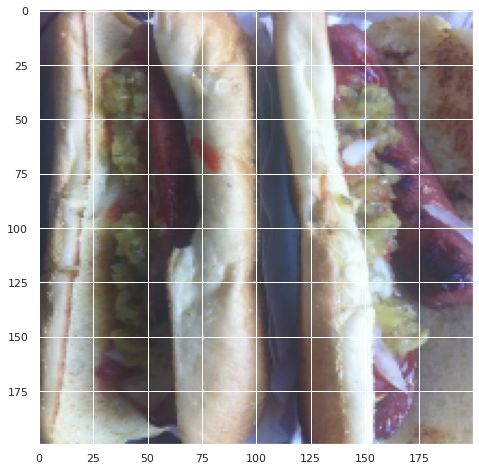

Label: 0


In [ ]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze().squeeze()
img = train_features[23].numpy().transpose((1, 2, 0))
label = train_labels[23]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

Loading of data was succesful.

For training datset, I'll use different augmentations: RandomRotation and ColorJitter - those will bring more diversity into position and colours of the dataset.


As the pictures are quite big, in order to make task computationally easier, I'll resize pictures into 200*200.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((200, 200)),
                                transforms.ColorJitter(brightness=.5, hue=.1),
                                #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
                                transforms.RandomRotation(degrees=(0, 180))
                                 ])

In [ ]:
train.transform = transform

In [ ]:
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

Feature batch shape: torch.Size([32, 3, 200, 200])
Labels batch shape: torch.Size([32])


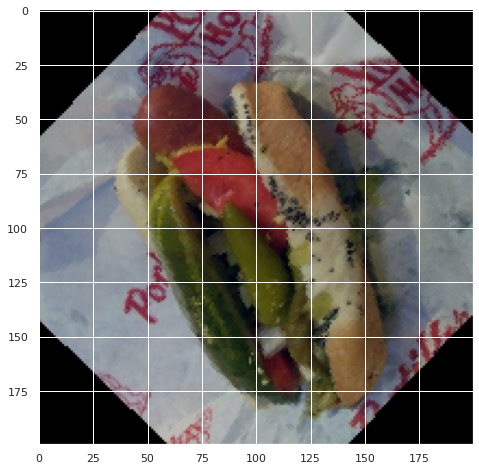

Label: 0


In [ ]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze().squeeze()
img = train_features[12].numpy().transpose((1, 2, 0))
label = train_labels[12]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

It is seen that the augmentations were applied.

## Functions initialization

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
accuracy = Accuracy(task='binary')

For training process I'll use validation dataset to  calculate accuracy and save best weights. I won't calculate it on whole dataset as it is quite a lengthy process, but instead will use 100 random samples.

In [ ]:
def show_results(history_tr, history_tst, metric='Accuracy'):
  print(f'Biggest val {metric} = {max(history_tst)}')
  print(f'Smallest val {metric} = {min(history_tst)}')
  plt.plot(history_tst)
  plt.plot(history_tr)
  plt.legend(labels=[f'Val {metric}', f'Train {metric}'])
  plt.title(f'{metric} on epochs')
  plt.show()

def validate_epoch(model, dataset, batch_size):
  subset, _ = random_split(dataset, [100, len(dataset) - 100])
  val_dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  loss = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X)
    loss += loss_fn(pred, y).item()
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  loss = loss/num_batches
  return loss, accuracy_score


def early_stop(epoch, history):
  if epoch > 3 and abs(history[-3] - history[-2]) < 0.01 and abs(history[-2] - history[-1]) < 0.01:
    print('')
    print('Early stop: plato found')
    return 1
  elif epoch > 15 and (np.max(history[-8: -4]) > np.max(history[-4:])):
    print('')
    print('Early stop: error increasing')
    return 1
  return 0

def train_cv(model, n_epochs=50, batch_size=32, disable_bar=False, check_early_stop=True):
  # Hold the best model
  best_loss = np.inf   # init to infinity
  best_weights = None
  history_val_loss, history_tr_loss = [], []
  history_val_acc, history_tr_acc  = [], []
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
  for epoch in range(n_epochs):
      model.train()

      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")

      for X_batch, y_batch in loop :
          y_pred = model(X_batch)
          y_batch = y_batch.float()
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          optimizer = model.get_optimizer()
          optimizer.zero_grad()
          loss.backward()
          # update weights
          optimizer.step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
      # evaluate accuracy at end of each epoch
      model.eval()
      loss_val, acc_val = validate_epoch(model, val_subset, batch_size)
      history_val_loss.append(loss_val)
      history_val_acc.append(acc_val)
      loss_tr, acc_tr = validate_epoch(model, train, batch_size)
      history_tr_loss.append(loss_tr)
      history_tr_acc.append(acc_tr)
      print(f'Epoch ended, accuracy val score = {acc_val}')
      if loss_val < best_loss:
          best_loss = loss_val
          best_weights = copy.deepcopy(model.state_dict())
      if check_early_stop:
        if early_stop(epoch, history_val_acc):
          break
  return history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights


In [ ]:
def evaluate_model(model, dataset, batch_size=25):
  val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X)
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  print(f'Accuracy score =  = {accuracy_score}')
  return accuracy

## Models creating

### Basic model

In [ ]:
class BasicCV(nn.Module):
  def __init__(self, input=3, learning_rate=0.001):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 3, 3) # 198
    self.pool = nn.MaxPool2d(4) # (198 - 4) // 4 + 1 = 49
    self.conv2 = nn.Conv2d(3, 3, 3) # pool(47) = 11
    self.fc1 = nn.Linear(11 * 11 * 3, 64) 
    self.fc2 = nn.Linear(64, 1)
    self.m1 = nn.BatchNorm1d(11 * 11 * 3)
    self.learning_rate = learning_rate
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    #print(x)
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
basic_cv = BasicCV()
summary(basic_cv)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            84
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            84
├─Linear: 1-4                            23,296
├─Linear: 1-5                            65
├─BatchNorm1d: 1-6                       726
Total params: 24,255
Trainable params: 24,255
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            84
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            84
├─Linear: 1-4                            23,296
├─Linear: 1-5                            65
├─BatchNorm1d: 1-6                       726
Total params: 24,255
Trainable params: 24,255
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(basic_cv, 50, 32, check_early_stop=True)

Epoch 0:   0%|          | 0/16 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 16/16 [00:12<00:00,  1.25batch/s, cross_entropy=23.1]


Epoch ended, accuracy val score = 0.5546875


Epoch 1: 100%|██████████| 16/16 [00:15<00:00,  1.01batch/s, cross_entropy=28.9]


Epoch ended, accuracy val score = 0.5234375


Epoch 2: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=17.3]


Epoch ended, accuracy val score = 0.5625


Epoch 3: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=17.2]


Epoch ended, accuracy val score = 0.5390625


Epoch 4: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=31.9]


Epoch ended, accuracy val score = 0.4765625


Epoch 5: 100%|██████████| 16/16 [00:14<00:00,  1.11batch/s, cross_entropy=22.8]


Epoch ended, accuracy val score = 0.4375


Epoch 6: 100%|██████████| 16/16 [00:13<00:00,  1.18batch/s, cross_entropy=25.8]


Epoch ended, accuracy val score = 0.4921875


Epoch 7: 100%|██████████| 16/16 [00:24<00:00,  1.54s/batch, cross_entropy=28.7]


Epoch ended, accuracy val score = 0.5859375


Epoch 8: 100%|██████████| 16/16 [00:15<00:00,  1.06batch/s, cross_entropy=25.9]


Epoch ended, accuracy val score = 0.4140625


Epoch 9: 100%|██████████| 16/16 [00:20<00:00,  1.30s/batch, cross_entropy=17.1]


Epoch ended, accuracy val score = 0.65625


Epoch 10: 100%|██████████| 16/16 [00:15<00:00,  1.03batch/s, cross_entropy=23]


Epoch ended, accuracy val score = 0.46875


Epoch 11: 100%|██████████| 16/16 [00:16<00:00,  1.05s/batch, cross_entropy=25.8]


Epoch ended, accuracy val score = 0.515625


Epoch 12: 100%|██████████| 16/16 [00:17<00:00,  1.11s/batch, cross_entropy=28.9]


Epoch ended, accuracy val score = 0.5078125


Epoch 13: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=23.4]


Epoch ended, accuracy val score = 0.6796875


Epoch 14: 100%|██████████| 16/16 [00:14<00:00,  1.07batch/s, cross_entropy=25.7]


Epoch ended, accuracy val score = 0.625


Epoch 15: 100%|██████████| 16/16 [00:13<00:00,  1.16batch/s, cross_entropy=31.4]


Epoch ended, accuracy val score = 0.578125


Epoch 16: 100%|██████████| 16/16 [00:13<00:00,  1.17batch/s, cross_entropy=33.9]


Epoch ended, accuracy val score = 0.5390625


Epoch 17: 100%|██████████| 16/16 [00:19<00:00,  1.24s/batch, cross_entropy=22.6]


Epoch ended, accuracy val score = 0.625

Early stop: error increasing


Biggest val Entropy = 48.03374242782593
Smallest val Entropy = 37.21874761581421


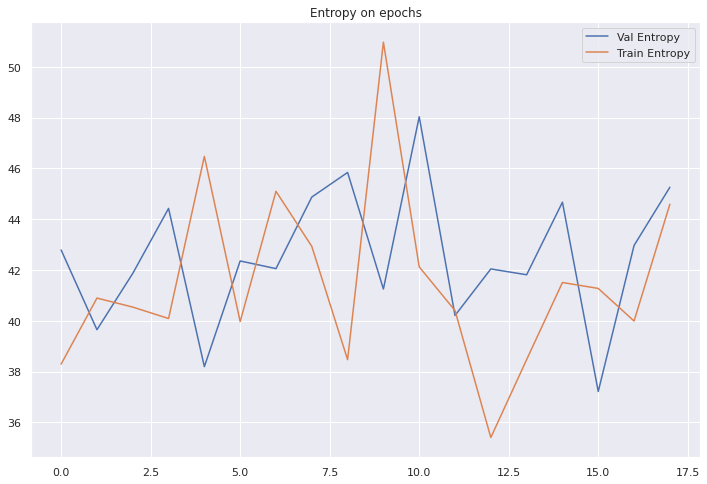

In [ ]:
basic_cv.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

Biggest val Accuracy = 0.6796875
Smallest val Accuracy = 0.4140625


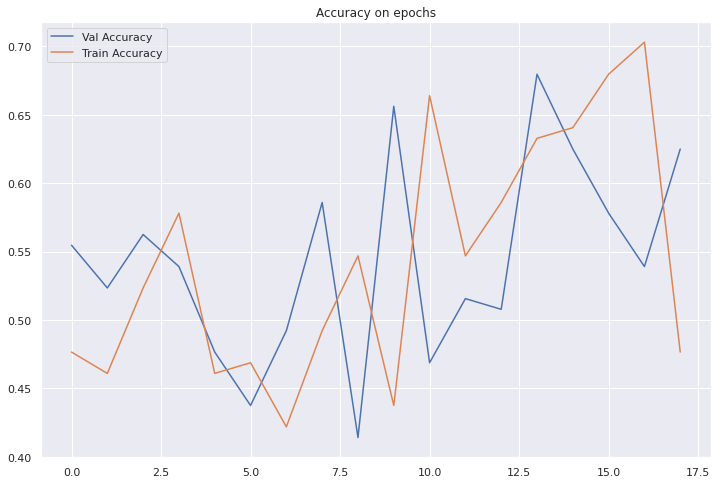

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

In [ ]:
evaluate_model(basic_cv, test_subset)

Accuracy score =  = 0.5079999953508377


BinaryAccuracy()

Based on training plots, I think the model is underfit - both loss and accuracy plots are very cheotic and the model did't preform much better then a dummy clasifier woud. I'll try increasing number of convolutions.

### More complicated models

In [ ]:
class BasicPlusCV(nn.Module):
  def __init__(self, input=3, learning_rate=0.001):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1) 
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(128, 128, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 128, 16) 
    self.fc2 = nn.Linear(16, 1) 
    self.m1 = nn.BatchNorm1d(12 * 12 * 128)
    self.learning_rate = learning_rate
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m1(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
      return optimizer

In [ ]:
cv_plus = BasicPlusCV()
summary(cv_plus)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus, 50, 25, check_early_stop=True)

Epoch 0:   0%|          | 0/20 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 20/20 [00:56<00:00,  2.84s/batch, cross_entropy=39]


Epoch ended, accuracy val score = 0.46000000089406967


Epoch 1: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=43.2]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 2: 100%|██████████| 20/20 [00:53<00:00,  2.66s/batch, cross_entropy=27.8]


Epoch ended, accuracy val score = 0.5900000035762787


Epoch 3: 100%|██████████| 20/20 [00:51<00:00,  2.59s/batch, cross_entropy=33]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 4: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=40.6]


Epoch ended, accuracy val score = 0.5199999883770943


Epoch 5: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=38.8]


Epoch ended, accuracy val score = 0.6099999994039536


Epoch 6: 100%|██████████| 20/20 [00:52<00:00,  2.64s/batch, cross_entropy=37.3]


Epoch ended, accuracy val score = 0.47999999672174454


Epoch 7: 100%|██████████| 20/20 [00:53<00:00,  2.68s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.5599999949336052


Epoch 8: 100%|██████████| 20/20 [00:53<00:00,  2.66s/batch, cross_entropy=41.8]


Epoch ended, accuracy val score = 0.7199999988079071


Epoch 9: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=18.8]


Epoch ended, accuracy val score = 0.5700000002980232


Epoch 10: 100%|██████████| 20/20 [00:51<00:00,  2.58s/batch, cross_entropy=28.6]


Epoch ended, accuracy val score = 0.6599999964237213


Epoch 11: 100%|██████████| 20/20 [00:54<00:00,  2.72s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.5699999928474426


Epoch 12: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=32]


Epoch ended, accuracy val score = 0.6000000089406967


Epoch 13: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=28.5]


Epoch ended, accuracy val score = 0.6400000005960464


Epoch 14: 100%|██████████| 20/20 [00:52<00:00,  2.65s/batch, cross_entropy=21.6]


Epoch ended, accuracy val score = 0.5600000098347664


Epoch 15: 100%|██████████| 20/20 [00:45<00:00,  2.25s/batch, cross_entropy=28.4]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 16: 100%|██████████| 20/20 [00:52<00:00,  2.61s/batch, cross_entropy=19.1]


Epoch ended, accuracy val score = 0.5699999928474426


Epoch 17: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=33.4]


Epoch ended, accuracy val score = 0.6200000047683716


Epoch 18: 100%|██████████| 20/20 [00:52<00:00,  2.62s/batch, cross_entropy=28.3]


Epoch ended, accuracy val score = 0.6899999976158142


Epoch 19: 100%|██████████| 20/20 [00:51<00:00,  2.60s/batch, cross_entropy=34.2]


Epoch ended, accuracy val score = 0.6500000059604645


Epoch 20: 100%|██████████| 20/20 [00:53<00:00,  2.67s/batch, cross_entropy=23.9]


Epoch ended, accuracy val score = 0.5899999961256981


Epoch 21: 100%|██████████| 20/20 [00:50<00:00,  2.54s/batch, cross_entropy=24]


Epoch ended, accuracy val score = 0.6599999964237213

Early stop: error increasing


Biggest val Accuracy = 0.7199999988079071
Smallest val Accuracy = 0.46000000089406967


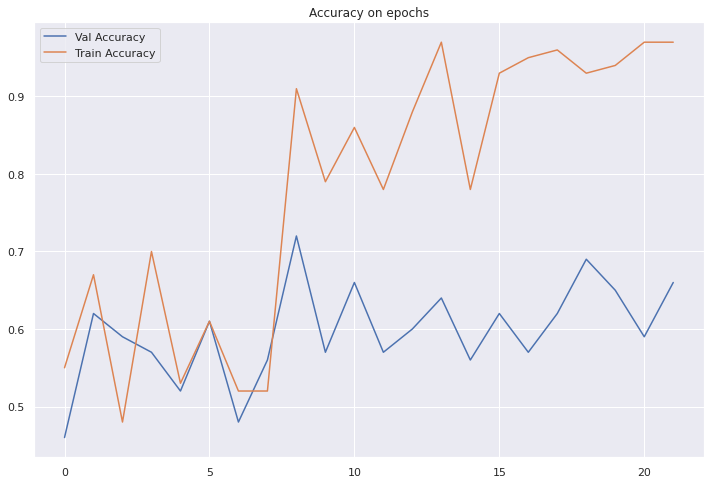

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

Biggest val Entropy = 45.62831687927246
Smallest val Entropy = 35.944591999053955


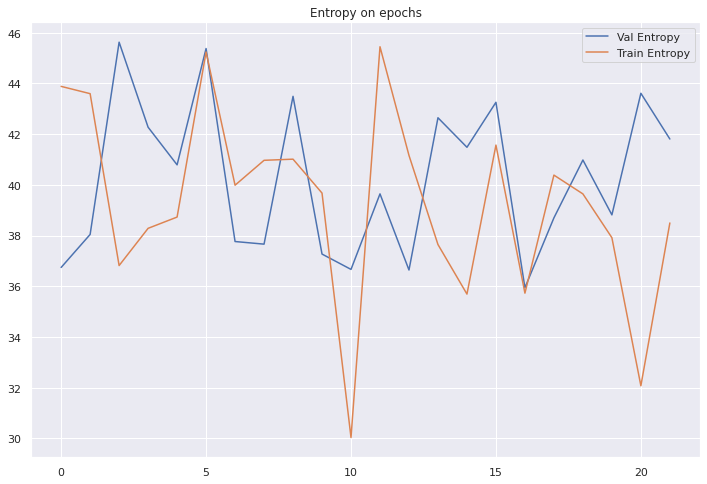

In [ ]:
cv_plus.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus, test_subset)

Accuracy score =  = 0.6159999996423722


BinaryAccuracy()

The accuracy on train dataset is very high while validation one is much smaller - the model is overfitting so I'll try adding dropouts and weight decay to optimizer. The entropy plot on the other hand is pretty random. I guess there is sense in finding optimal batch size and learning_rate to fix it.

In [ ]:
cv_plus16 = BasicPlusCV()
summary(cv_plus16)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─Linear: 1-6                            294,928
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       36,864
Total params: 572,641
Trainable params: 572,641
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus16, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=1.16]


Epoch ended, accuracy val score = 0.625


Epoch 1: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=0.882]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 2: 100%|██████████| 32/32 [00:57<00:00,  1.80s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 3: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 4: 100%|██████████| 32/32 [00:56<00:00,  1.76s/batch, cross_entropy=1.59]


Epoch ended, accuracy val score = 0.5625


Epoch 5: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=0.333]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 6: 100%|██████████| 32/32 [00:56<00:00,  1.76s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 7: 100%|██████████| 32/32 [00:56<00:00,  1.75s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 8: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=0.314]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 9: 100%|██████████| 32/32 [00:53<00:00,  1.68s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 10: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 11: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.625


Epoch 12: 100%|██████████| 32/32 [01:11<00:00,  2.22s/batch, cross_entropy=1.61]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 13: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=0.552]


Epoch ended, accuracy val score = 0.7410714285714286


Epoch 14: 100%|██████████| 32/32 [00:55<00:00,  1.75s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 15: 100%|██████████| 32/32 [00:54<00:00,  1.72s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 16: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5535714285714286

Early stop: error increasing


Biggest val Accuracy = 0.7410714285714286
Smallest val Accuracy = 0.5267857142857143


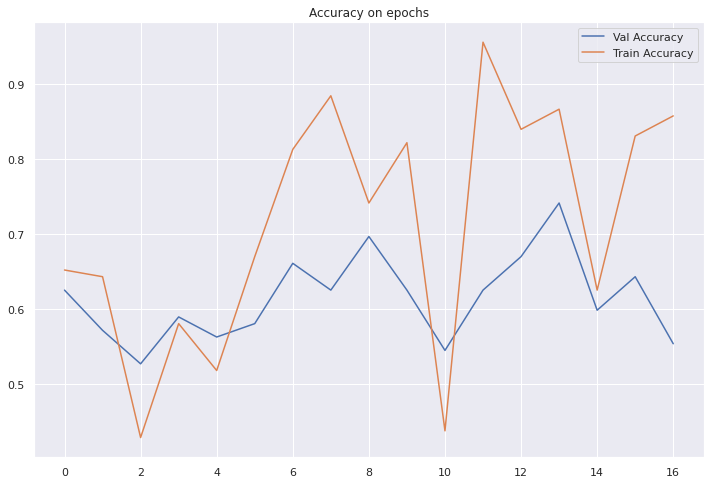

In [ ]:
show_results(history_tr_acc, history_val_acc, metric='Accuracy')

Biggest val Entropy = 21.793421660150802
Smallest val Entropy = 17.492394311087473


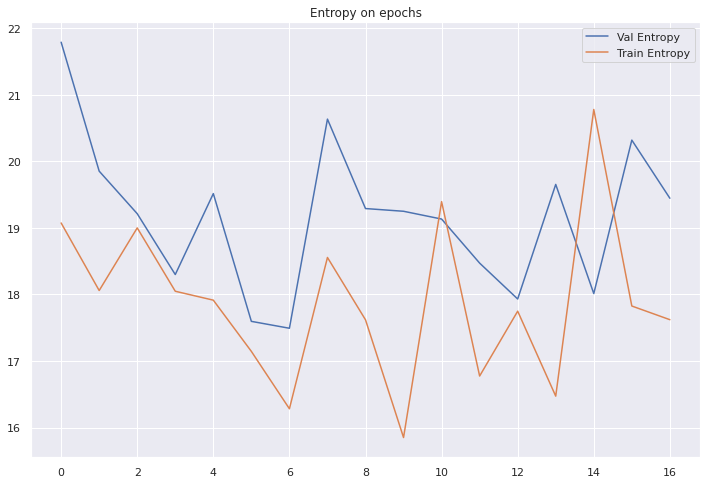

In [ ]:
cv_plus.load_state_dict(best_weights)
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus, test_subset)

Accuracy score =  = 0.6040000021457672


BinaryAccuracy()

The result looks a bit more smooth, there is less overfitting and entropy is smaller. On the other hand, the entropy is still pretty random.

I'll try even less batch_size.

In [ ]:
cv_plus10 = BasicPlusCV()

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_plus10, 50, 10, check_early_stop=True)

Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 50/50 [01:04<00:00,  1.30s/batch, cross_entropy=10.5]


Epoch ended, accuracy val score = 0.5500000149011612


Epoch 1: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=15.5]


Epoch ended, accuracy val score = 0.5399999976158142


Epoch 2: 100%|██████████| 50/50 [00:52<00:00,  1.05s/batch, cross_entropy=7.38]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 3: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=7.48]


Epoch ended, accuracy val score = 0.610000005364418


Epoch 4: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=7.46]


Epoch ended, accuracy val score = 0.5600000083446502


Epoch 5: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.75]


Epoch ended, accuracy val score = 0.5799999982118607


Epoch 6: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=10.5]


Epoch ended, accuracy val score = 0.5700000062584877


Epoch 7: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=9.17]


Epoch ended, accuracy val score = 0.6400000065565109


Epoch 8: 100%|██████████| 50/50 [00:49<00:00,  1.00batch/s, cross_entropy=5.73]


Epoch ended, accuracy val score = 0.44000000804662703


Epoch 9: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5900000035762787


Epoch 10: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.79]


Epoch ended, accuracy val score = 0.6000000029802323


Epoch 11: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=9.47]


Epoch ended, accuracy val score = 0.5500000089406967


Epoch 12: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=5.29]


Epoch ended, accuracy val score = 0.5700000077486038


Epoch 13: 100%|██████████| 50/50 [00:50<00:00,  1.01s/batch, cross_entropy=5.44]


Epoch ended, accuracy val score = 0.5700000062584877


Epoch 14: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=8.05]


Epoch ended, accuracy val score = 0.5800000071525574


Epoch 15: 100%|██████████| 50/50 [00:51<00:00,  1.03s/batch, cross_entropy=14.8]


Epoch ended, accuracy val score = 0.5700000047683715


Epoch 16: 100%|██████████| 50/50 [00:51<00:00,  1.02s/batch, cross_entropy=7]


Epoch ended, accuracy val score = 0.5800000041723251

Early stop: error increasing


Biggest val Accuracy = 0.6400000065565109
Smallest val Accuracy = 0.44000000804662703


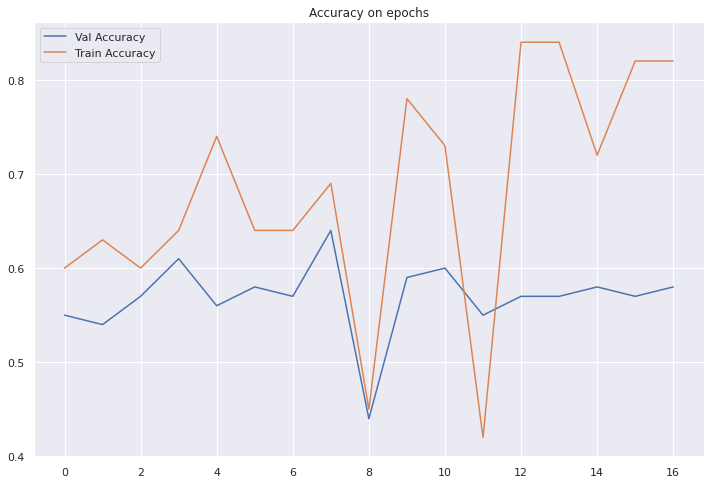

Biggest val Entropy = 13.861388397216796
Smallest val Entropy = 10.131335258483887


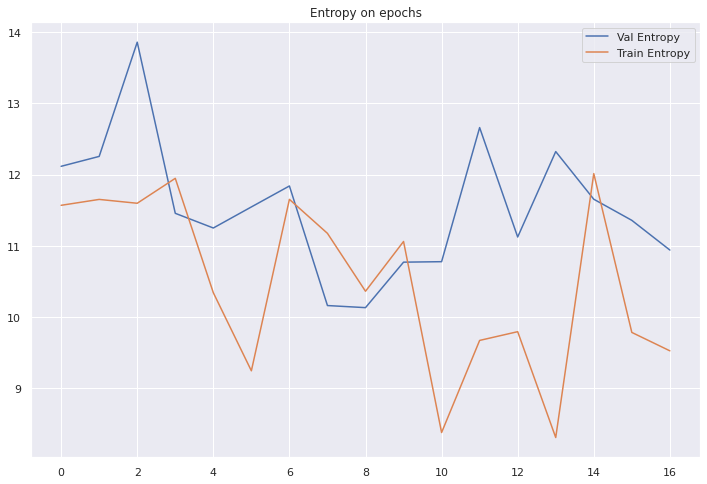

In [ ]:
cv_plus10.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(cv_plus10, test_subset);

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy score =  = 0.4960000038146973


This batch size seems to be worse then the previous one as the accuracy dropped. All those models have a clear overfitting so I'll try to use weight decay and decrease number of channels.

In [ ]:
class PlusCVReg(nn.Module):
  def __init__(self, input=3, learning_rate=0.001, weight_decay=1e-5):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1) 
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 64, 16) 
    self.fc2 = nn.Linear(16, 1) 
    self.m1 = nn.BatchNorm1d(12 * 12 * 64)
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m1(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), 
                                   lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
      return optimizer

In [ ]:
smaller_model = PlusCVReg()
summary(smaller_model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       18,432
Total params: 259,169
Trainable params: 259,169
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm1d: 1-8                       18,432
Total params: 259,169
Trainable params: 259,169
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(smaller_model, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:53<00:00,  1.68s/batch, cross_entropy=1.42]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 1: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 2: 100%|██████████| 32/32 [00:40<00:00,  1.28s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 3: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=0.466]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 4: 100%|██████████| 32/32 [00:46<00:00,  1.44s/batch, cross_entropy=1.27]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 5: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.48214285714285715


Epoch 6: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.405]


Epoch ended, accuracy val score = 0.5089285714285714


Epoch 7: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.46]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 8: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.325]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 9: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 10: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.484]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 11: 100%|██████████| 32/32 [00:47<00:00,  1.49s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 12: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=0.315]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 13: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=0.396]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 14: 100%|██████████| 32/32 [00:46<00:00,  1.44s/batch, cross_entropy=1.49]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 15: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=0.326]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 16: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.5446428571428571

Early stop: error increasing


Biggest val Accuracy = 0.6785714285714286
Smallest val Accuracy = 0.44642857142857145


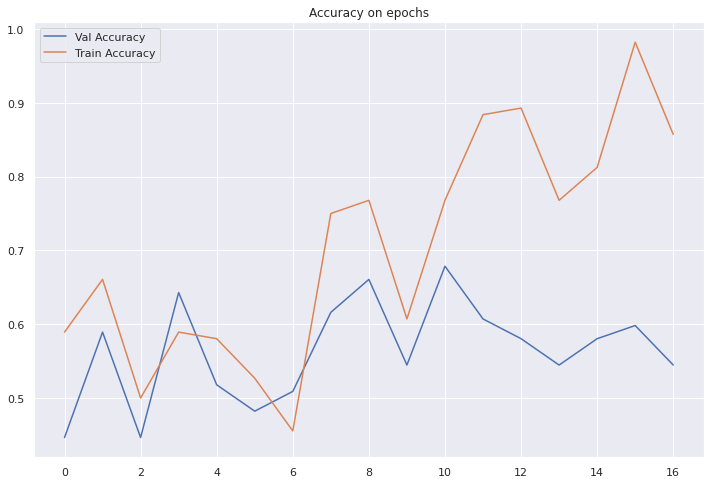

Biggest val Entropy = 22.336836133684432
Smallest val Entropy = 16.56010048730033


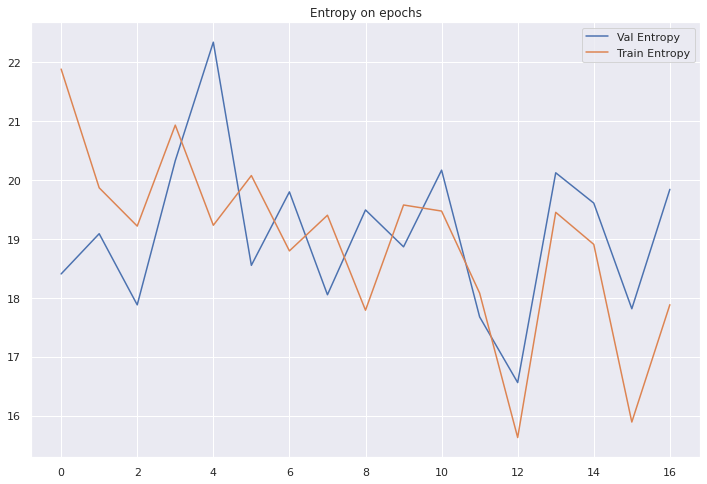

In [ ]:
smaller_model.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(smaller_model, test_subset);

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Accuracy score =  = 0.6079999953508377


I've made the model more reguralized but it is still overfitting. I'll dropout.

In [ ]:
class PlusCVRegDrop(nn.Module):
  def __init__(self, input=3, learning_rate=0.001, weight_decay=1e-3, p1=0.2):
    super().__init__()
    self.conv1 = nn.Conv2d(input, 32, 3, padding=1) 
    self.pool = nn.MaxPool2d(2) # 100
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # pool(x) = 50
    self.conv3 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 25
    self.conv4 = nn.Conv2d(64, 64, 3, padding=1) # pool(x) = 12
    self.fc1 = nn.Linear(12 * 12 * 64, 16) 
    self.fc2 = nn.Linear(16, 1) 
    self.m1 = nn.BatchNorm2d(32)
    self.m2 = nn.BatchNorm2d(64)
    self.m3 = nn.BatchNorm2d(64)
    self.m4 = nn.BatchNorm1d(12 * 12 * 64)
    self.d1 = nn.Dropout(p1)
    self.learning_rate = learning_rate
    self.weight_decay = weight_decay
  
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.m1(self.pool(x))
    x = F.relu(self.m2(self.conv2(x)))
    x = self.pool(x)
    x = F.relu(self.m3(self.conv3(x)))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = self.d1(x)
    #x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = self.m4(x)
    x = F.relu(self.fc1(x))
    x = F.sigmoid(self.fc2(x)).squeeze()
    return x

  def get_optimizer(self):
      optimizer = torch.optim.Adam(self.parameters(), 
                                   lr=self.learning_rate,
                                   weight_decay=self.weight_decay)
      return optimizer

In [ ]:
dropout_model = PlusCVRegDrop()
summary(dropout_model)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm2d: 1-8                       64
├─BatchNorm2d: 1-9                       128
├─BatchNorm2d: 1-10                      128
├─BatchNorm1d: 1-11                      18,432
├─Dropout: 1-12                          --
Total params: 259,489
Trainable params: 259,489
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            896
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            36,928
├─Conv2d: 1-5                            36,928
├─Linear: 1-6                            147,472
├─Linear: 1-7                            17
├─BatchNorm2d: 1-8                       64
├─BatchNorm2d: 1-9                       128
├─BatchNorm2d: 1-10                      128
├─BatchNorm1d: 1-11                      18,432
├─Dropout: 1-12                          --
Total params: 259,489
Trainable params: 259,489
Non-trainable params: 0

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(dropout_model, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 1: 100%|██████████| 32/32 [00:45<00:00,  1.41s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 2: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=0.355]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 3: 100%|██████████| 32/32 [00:43<00:00,  1.37s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 4: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.375]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 5: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=0.455]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 6: 100%|██████████| 32/32 [00:38<00:00,  1.21s/batch, cross_entropy=0.372]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 7: 100%|██████████| 32/32 [00:47<00:00,  1.49s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 8: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=1.55]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 9: 100%|██████████| 32/32 [00:46<00:00,  1.45s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 10: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5535714285714286


Epoch 11: 100%|██████████| 32/32 [00:55<00:00,  1.75s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 12: 100%|██████████| 32/32 [00:46<00:00,  1.47s/batch, cross_entropy=1.45]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 13: 100%|██████████| 32/32 [00:45<00:00,  1.44s/batch, cross_entropy=0.313]


Epoch ended, accuracy val score = 0.7410714285714286


Epoch 14: 100%|██████████| 32/32 [00:47<00:00,  1.47s/batch, cross_entropy=1.52]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 15: 100%|██████████| 32/32 [00:48<00:00,  1.50s/batch, cross_entropy=0.314]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 16: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=0.929]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 17: 100%|██████████| 32/32 [00:45<00:00,  1.43s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714

Early stop: error increasing


Biggest val Accuracy = 0.7410714285714286
Smallest val Accuracy = 0.4642857142857143


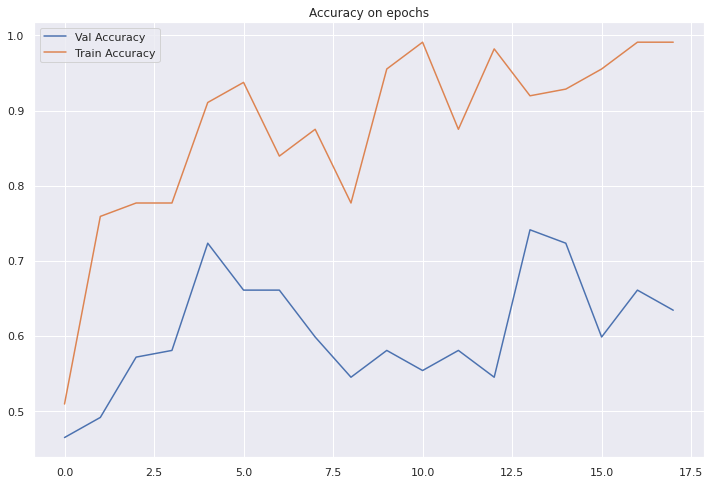

Biggest val Entropy = 21.373507227216447
Smallest val Entropy = 16.886781113488333


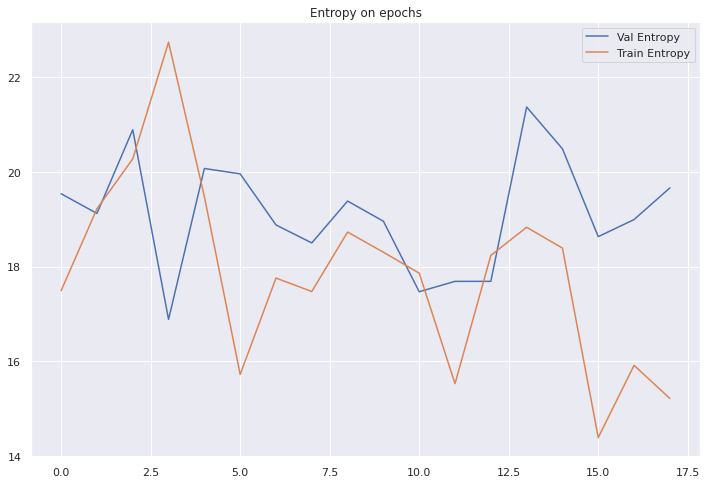

In [ ]:
dropout_model.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(dropout_model, test_subset);

Accuracy score =  = 0.6199999958276748


The test accuracy of this one is the best but probably increasing probability of dropout will imrove the results even more.

In [ ]:
dropout_model_05 = PlusCVRegDrop(weight_decay=0.01, p1=0.5)

In [ ]:
history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(dropout_model_05, 50, 16, check_early_stop=True)

Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5357142857142857


Epoch 1: 100%|██████████| 32/32 [00:49<00:00,  1.54s/batch, cross_entropy=0.908]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 2: 100%|██████████| 32/32 [01:14<00:00,  2.33s/batch, cross_entropy=1.07]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 3: 100%|██████████| 32/32 [01:11<00:00,  2.25s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5625


Epoch 4: 100%|██████████| 32/32 [01:04<00:00,  2.01s/batch, cross_entropy=0.677]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 5: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 6: 100%|██████████| 32/32 [00:56<00:00,  1.77s/batch, cross_entropy=0.47]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 7: 100%|██████████| 32/32 [00:54<00:00,  1.71s/batch, cross_entropy=0.332]


Epoch ended, accuracy val score = 0.5


Epoch 8: 100%|██████████| 32/32 [00:58<00:00,  1.82s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7321428571428571


Epoch 9: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.371]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 10: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.75


Epoch 11: 100%|██████████| 32/32 [00:47<00:00,  1.48s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 12: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.6875


Epoch 13: 100%|██████████| 32/32 [00:48<00:00,  1.51s/batch, cross_entropy=0.334]


Epoch ended, accuracy val score = 0.6785714285714286

Early stop: plato found


Biggest val Accuracy = 0.75
Smallest val Accuracy = 0.5


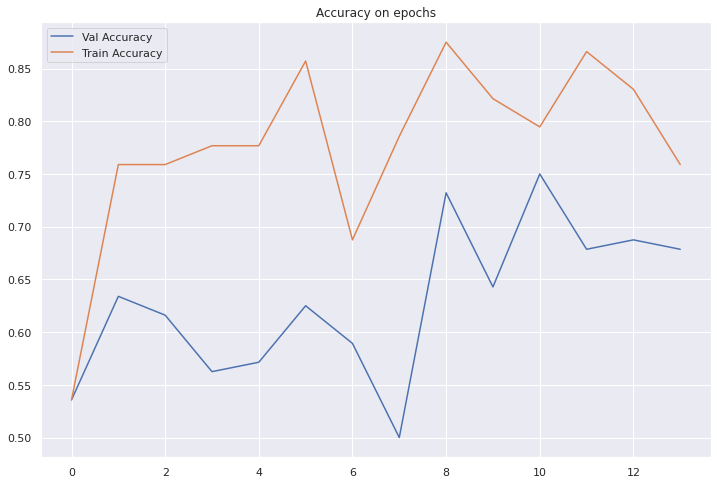

Biggest val Entropy = 21.741024698529923
Smallest val Entropy = 16.657828535352433


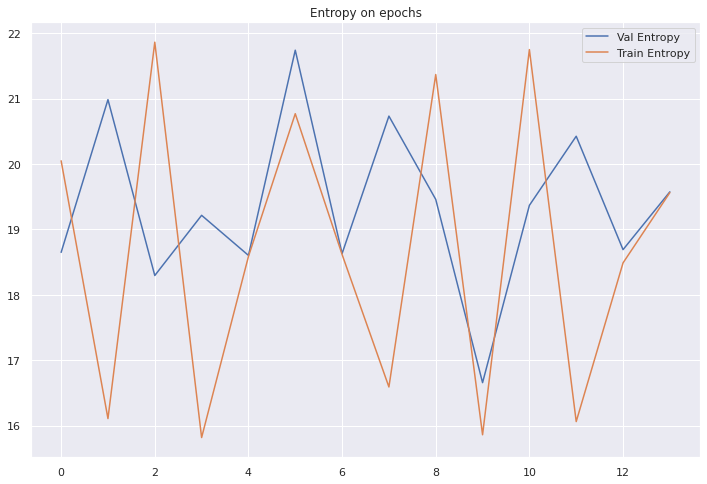

In [ ]:
dropout_model_05.load_state_dict(best_weights)
show_results(history_tr_acc, history_val_acc, metric='Accuracy')
show_results(history_tr_loss, history_val_loss, metric='Entropy')

In [ ]:
evaluate_model(dropout_model_05, test_subset);

Accuracy score =  = 0.568000003695488


Learning curve of accuracy looks the better then the rest of the models but got I little accuracy score on test set. The entropy plot is very cheotic so perhaps different learning rate will make the results more stable.

### Learning rate tuning

Model with lr size = 0.01


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [01:06<00:00,  2.06s/batch, cross_entropy=0.571]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 1: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 2: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.493]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 3: 100%|██████████| 32/32 [00:53<00:00,  1.69s/batch, cross_entropy=0.577]


Epoch ended, accuracy val score = 0.4732142857142857


Epoch 4: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.3482142857142857


Epoch 5: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.392]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 6: 100%|██████████| 32/32 [00:52<00:00,  1.64s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.39285714285714285


Epoch 7: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 8: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.495]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 9: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 10: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=0.67]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.722]


Epoch ended, accuracy val score = 0.5267857142857143


Epoch 12: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=0.544]


Epoch ended, accuracy val score = 0.625


Epoch 13: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=0.498]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 14: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.619]


Epoch ended, accuracy val score = 0.4732142857142857


Epoch 15: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=0.489]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 16: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.625]


Epoch ended, accuracy val score = 0.5982142857142857

Early stop: error increasing
Biggest val Accuracy = 0.625
Smallest val Accuracy = 0.3482142857142857


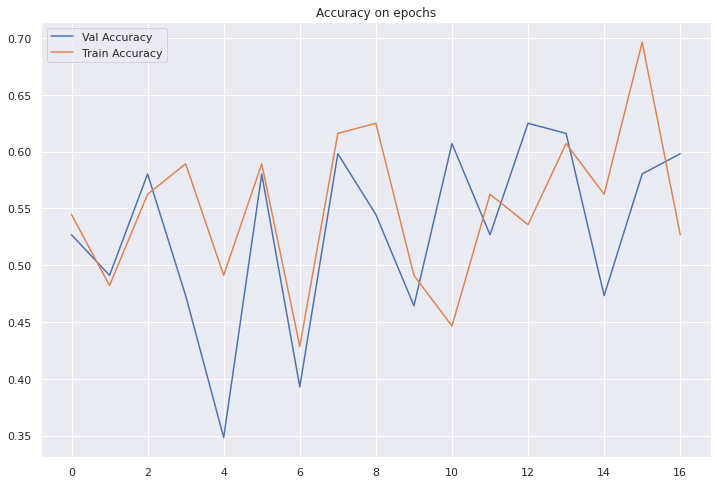

Biggest val Entropy = 24.755259377615793
Smallest val Entropy = 16.39125861440386


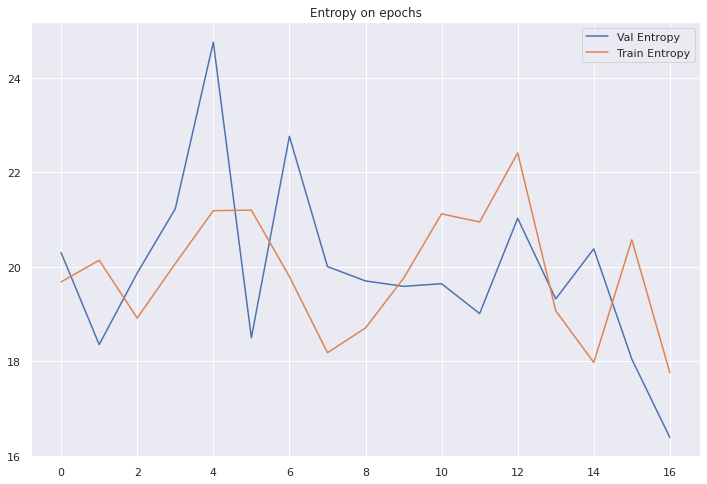

Accuracy score =  = 0.5399999976158142
Accuracy score =  = 0.5120000034570694
Model with lr size = 0.005


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.435]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 1: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.5089285714285714


Epoch 2: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 3: 100%|██████████| 32/32 [00:49<00:00,  1.55s/batch, cross_entropy=1.6]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 4: 100%|██████████| 32/32 [00:50<00:00,  1.56s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.44642857142857145


Epoch 5: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.64]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 6: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=0.345]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 7: 100%|██████████| 32/32 [00:49<00:00,  1.56s/batch, cross_entropy=0.735]


Epoch ended, accuracy val score = 0.45535714285714285


Epoch 8: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=1.5]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 9: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=0.512]


Epoch ended, accuracy val score = 0.45535714285714285


Epoch 10: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.54]


Epoch ended, accuracy val score = 0.4642857142857143


Epoch 12: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 13: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=1.22]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 14: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.606]


Epoch ended, accuracy val score = 0.5625


Epoch 15: 100%|██████████| 32/32 [00:52<00:00,  1.63s/batch, cross_entropy=1.61]


Epoch ended, accuracy val score = 0.5625


Epoch 16: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.376]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 17: 100%|██████████| 32/32 [00:50<00:00,  1.58s/batch, cross_entropy=0.422]


Epoch ended, accuracy val score = 0.5714285714285714

Early stop: error increasing
Biggest val Accuracy = 0.7053571428571429
Smallest val Accuracy = 0.44642857142857145


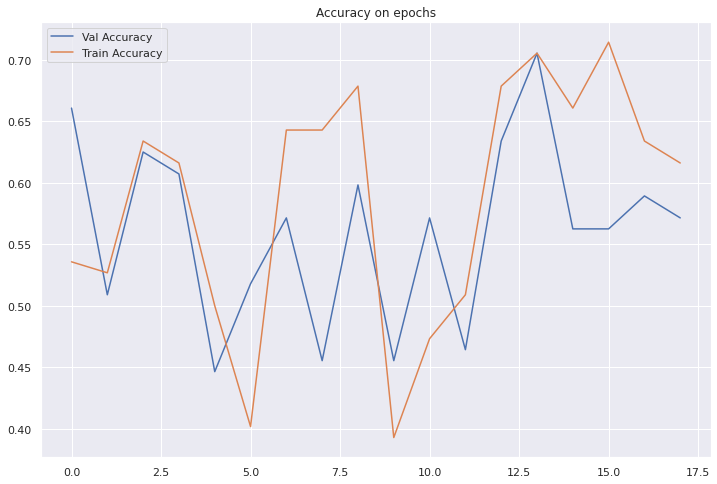

Biggest val Entropy = 22.299683025905065
Smallest val Entropy = 17.57873817852565


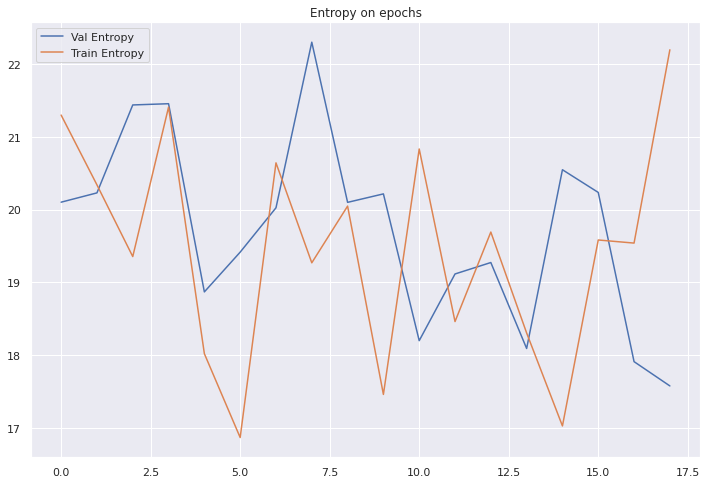

Accuracy score =  = 0.5279999941587448
Accuracy score =  = 0.5159999966621399
Model with lr size = 0.001


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:52<00:00,  1.64s/batch, cross_entropy=0.573]


Epoch ended, accuracy val score = 0.49107142857142855


Epoch 1: 100%|██████████| 32/32 [00:46<00:00,  1.46s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5357142857142857


Epoch 2: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 3: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.504]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 4: 100%|██████████| 32/32 [00:49<00:00,  1.56s/batch, cross_entropy=0.33]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 5: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.995]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 6: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.32]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 7: 100%|██████████| 32/32 [00:50<00:00,  1.59s/batch, cross_entropy=0.984]


Epoch ended, accuracy val score = 0.6071428571428571


Epoch 8: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.348]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 9: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=0.326]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 10: 100%|██████████| 32/32 [00:51<00:00,  1.62s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 11: 100%|██████████| 32/32 [00:50<00:00,  1.56s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5714285714285714


Epoch 12: 100%|██████████| 32/32 [00:51<00:00,  1.61s/batch, cross_entropy=1.41]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 13: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 14: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=0.368]


Epoch ended, accuracy val score = 0.5446428571428571


Epoch 15: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.62]


Epoch ended, accuracy val score = 0.7053571428571429


Epoch 16: 100%|██████████| 32/32 [00:53<00:00,  1.66s/batch, cross_entropy=1.48]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 17: 100%|██████████| 32/32 [00:51<00:00,  1.60s/batch, cross_entropy=0.343]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 18: 100%|██████████| 32/32 [00:50<00:00,  1.57s/batch, cross_entropy=1.4]


Epoch ended, accuracy val score = 0.6428571428571429


Epoch 19: 100%|██████████| 32/32 [00:52<00:00,  1.65s/batch, cross_entropy=0.448]


Epoch ended, accuracy val score = 0.6428571428571429

Early stop: plato found
Biggest val Accuracy = 0.7053571428571429
Smallest val Accuracy = 0.49107142857142855


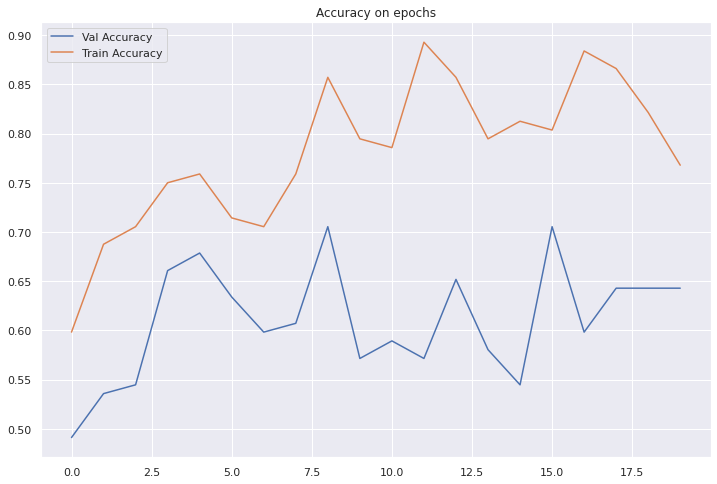

Biggest val Entropy = 21.852656262261526
Smallest val Entropy = 15.882162877491542


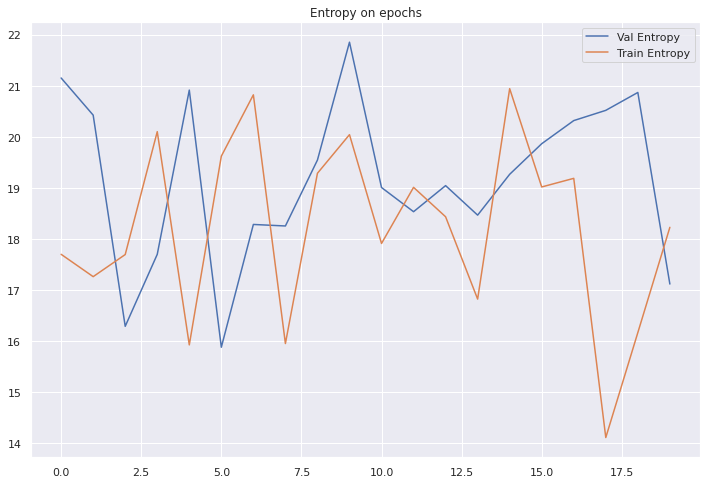

Accuracy score =  = 0.6720000088214875
Accuracy score =  = 0.6080000013113022
Model with lr size = 0.0005


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:59<00:00,  1.85s/batch, cross_entropy=0.965]


Epoch ended, accuracy val score = 0.4375


Epoch 1: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=0.595]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 2: 100%|██████████| 32/32 [01:01<00:00,  1.91s/batch, cross_entropy=0.923]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 3: 100%|██████████| 32/32 [01:05<00:00,  2.06s/batch, cross_entropy=1.12]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 4: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.439]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 5: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=0.373]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 6: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=0.782]


Epoch ended, accuracy val score = 0.6875


Epoch 7: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 8: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=0.322]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 9: 100%|██████████| 32/32 [01:01<00:00,  1.91s/batch, cross_entropy=0.336]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 10: 100%|██████████| 32/32 [01:02<00:00,  1.95s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7142857142857143


Epoch 11: 100%|██████████| 32/32 [00:58<00:00,  1.83s/batch, cross_entropy=0.871]


Epoch ended, accuracy val score = 0.5892857142857143


Epoch 12: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7142857142857143


Epoch 13: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=1.55]


Epoch ended, accuracy val score = 0.75


Epoch 14: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=1.43]


Epoch ended, accuracy val score = 0.5625


Epoch 15: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6785714285714286


Epoch 16: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.805]


Epoch ended, accuracy val score = 0.6607142857142857


Epoch 17: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5982142857142857

Early stop: error increasing
Biggest val Accuracy = 0.75
Smallest val Accuracy = 0.4375


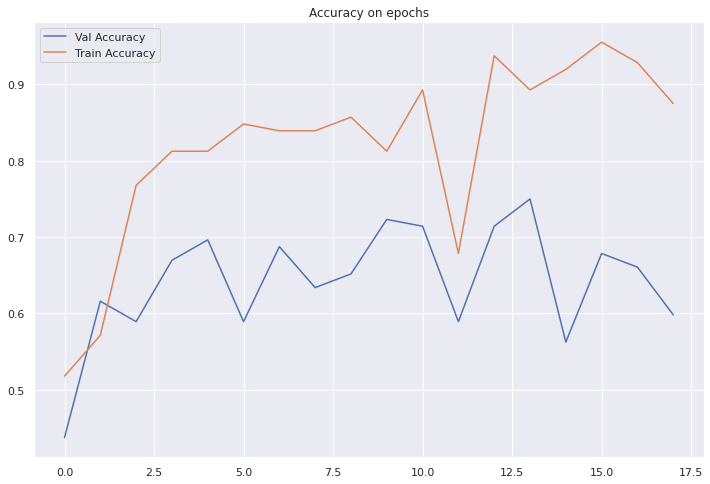

Biggest val Entropy = 23.540148632866995
Smallest val Entropy = 15.784310783658709


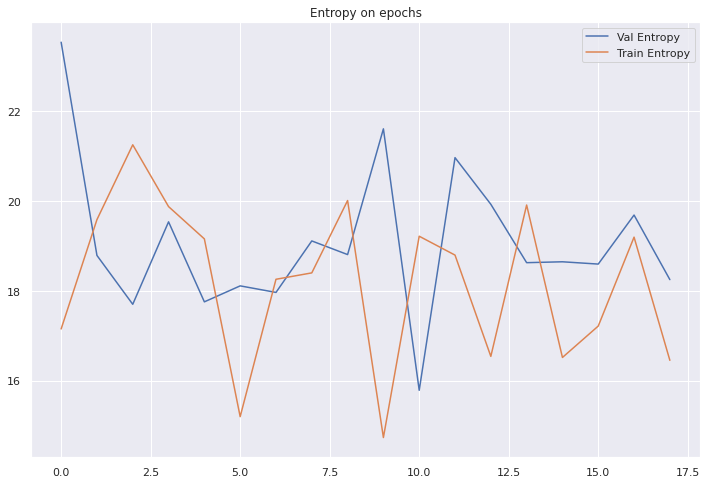

Accuracy score =  = 0.69200000166893
Accuracy score =  = 0.6440000057220459
Model with lr size = 0.0001


Epoch 0:   0%|          | 0/32 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Epoch 0: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.763]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 1: 100%|██████████| 32/32 [01:00<00:00,  1.89s/batch, cross_entropy=1.39]


Epoch ended, accuracy val score = 0.6160714285714286


Epoch 2: 100%|██████████| 32/32 [01:00<00:00,  1.89s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 3: 100%|██████████| 32/32 [01:00<00:00,  1.90s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.5803571428571429


Epoch 4: 100%|██████████| 32/32 [01:01<00:00,  1.93s/batch, cross_entropy=0.562]


Epoch ended, accuracy val score = 0.5178571428571429


Epoch 5: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=0.672]


Epoch ended, accuracy val score = 0.5982142857142857


Epoch 6: 100%|██████████| 32/32 [01:00<00:00,  1.91s/batch, cross_entropy=0.472]


Epoch ended, accuracy val score = 0.6517857142857143


Epoch 7: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=0.504]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 8: 100%|██████████| 32/32 [01:00<00:00,  1.88s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 9: 100%|██████████| 32/32 [00:55<00:00,  1.74s/batch, cross_entropy=1.44]


Epoch ended, accuracy val score = 0.7232142857142857


Epoch 10: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=1.43]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 11: 100%|██████████| 32/32 [00:59<00:00,  1.85s/batch, cross_entropy=0.372]


Epoch ended, accuracy val score = 0.6696428571428571


Epoch 12: 100%|██████████| 32/32 [00:58<00:00,  1.84s/batch, cross_entropy=0.456]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 13: 100%|██████████| 32/32 [00:59<00:00,  1.87s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.6964285714285714


Epoch 14: 100%|██████████| 32/32 [01:01<00:00,  1.93s/batch, cross_entropy=0.402]


Epoch ended, accuracy val score = 0.6339285714285714


Epoch 15: 100%|██████████| 32/32 [00:59<00:00,  1.86s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.625


Epoch 16: 100%|██████████| 32/32 [00:58<00:00,  1.82s/batch, cross_entropy=-]


Epoch ended, accuracy val score = 0.7053571428571429

Early stop: error increasing
Biggest val Accuracy = 0.7232142857142857
Smallest val Accuracy = 0.5178571428571429


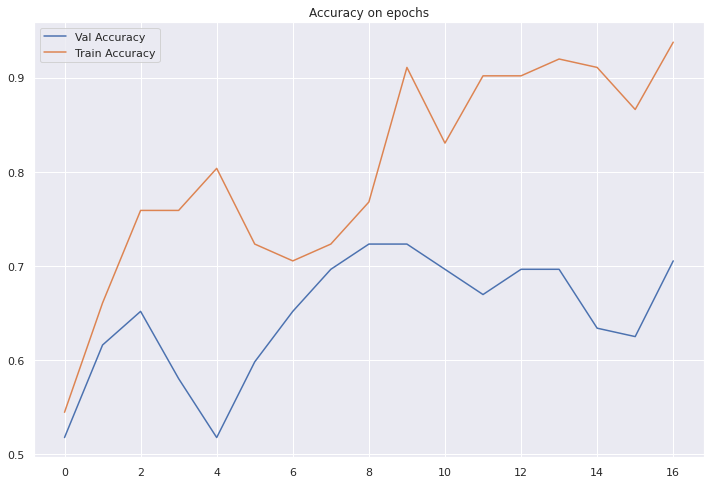

Biggest val Entropy = 20.931647334780013
Smallest val Entropy = 18.513073308127268


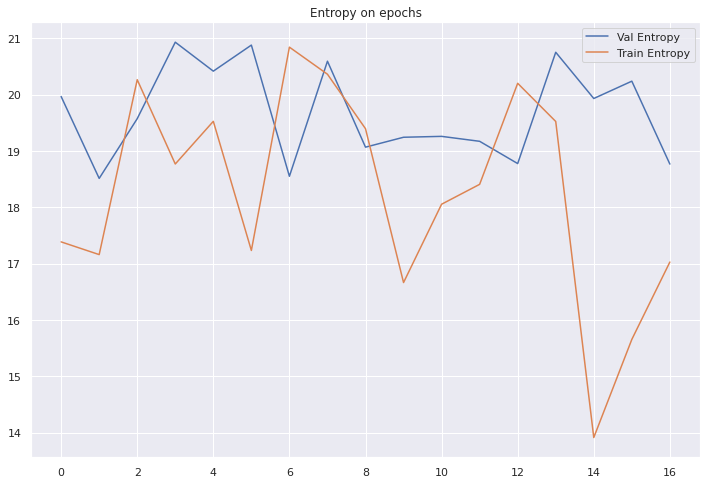

Accuracy score =  = 0.5760000020265579
Accuracy score =  = 0.5399999916553497


In [ ]:
results = pd.DataFrame(columns=['val_acc', 'test_acc'])
for learning_rate in (0.01, 0.005, 0.001, 0.0005, 0.0001):
  print(f'Model with lr size = {learning_rate}')
  cv_model = PlusCVRegDrop(learning_rate=learning_rate, weight_decay=0.001, p1=0.5)
  
  history_val_loss, history_tr_loss, history_val_acc, history_tr_acc, best_weights = train_cv(cv_model, 50, 16, check_early_stop=True) 
  cv_model.load_state_dict(best_weights)
  
  show_results(history_tr_acc, history_val_acc, metric='Accuracy')
  show_results(history_tr_loss, history_val_loss, metric='Entropy')
  res = pd.DataFrame({
        'val_acc': [evaluate_model(cv_model, val_subset)], 
        'test_acc': [evaluate_model(cv_model, test_subset)]
    })
  results = pd.concat([results, res], axis=0)

The best model seems to be one wirh learning_rate=0.0005. It's validation score = 0.692 and test score = 0.644. Next I'm going ti try pretrained models.

In [ ]:
results

val_acc  test_acc
0.0100    0.539     0.512
0.0050    0.527     0.515
0.0010    0.672     0.608
0.0005    0.692     0.644
0.0001    0.576     0.539

The accuracy score on 0.0005 learning rate is the best on both train and test datasets so I think it is optimal for my architecture. I fear I won't get much better models as the dataset is not that big and so I'll try to use pretrained models to achieve better results.

### Pretrained models.

### Specific functions

In [ ]:
def pretrained_cv(model, n_epochs=5, batch_size=32, learning_rate=0.001, disable_bar=False):
  # Hold the best model
  best_acc = 0   # init to infinity
  best_weights = None
  train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
  
  for epoch in range(n_epochs):
      model.train()

      loop = tqdm.tqdm(train_dataloader, unit="batch", mininterval=0, disable=disable_bar)
      loop.set_description(f"Epoch {epoch}")

      for X_batch, y_batch in loop :
          y_pred = model(X_batch)
          y_pred = y_pred.squeeze()

          y_batch = y_batch.float()
          loss = loss_fn(y_pred, y_batch)
          # backward pass
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
          optimizer.zero_grad()
          loss.backward()
          # update weights
          optimizer.step()
          # print progress
          loop.set_postfix(cross_entropy=loss.item())
  val_acc = test_unfreezed(model, val_subset)
  if best_acc < val_acc:
    best_acc = val_acc
    best_weights = copy.deepcopy(model.state_dict())
  return best_weights

In [ ]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


As resnet already has hot dog class, I can just see if hot dog class probability is the highets or not and give prediction based on that. Hot dog class is 934, so I'll just hardcode a function.

In [ ]:
def eval_pretrained(model, data, hotdog_idx=934):
  data = torch.utils.data.DataLoader(data, batch_size=25, shuffle=True)
  n_iter = 0
  accuracy_score = 0
  for X, y in data:
    #y = y.float()
    n_iter += 1
    pred = model(X)
    hotdog_probs = pred[:, hotdog_idx]
    other_probs = torch.cat((pred[:, :hotdog_idx], pred[:, hotdog_idx+1:]), dim=1)
    # Compare probability for hotdog class with maximum probability for all other classes
    max_other_probs, _ = torch.max(other_probs, dim=1)
    not_hotdog = hotdog_probs < max_other_probs
    acc = accuracy(not_hotdog, y).item()
    print(f'Accuracy of batch {n_iter} = {acc}')
    accuracy_score += acc
    
  accuracy_score = accuracy_score/n_iter
  print(f'Pretrained model has acc_score = {accuracy_score}')
  return accuracy_score

In [ ]:
def test_unfreezed(model, dataset, batch_size=50):
  model.eval()
  val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  num_batches = 0
  accuracy_score = 0
  for X, y in val_dataloader:
    y = y.float()
    pred = model(X).squeeze()
    accuracy_score += accuracy(pred, y).item()
    num_batches += 1
  accuracy_score = accuracy_score / num_batches
  print(f'Accuracy score =  = {accuracy_score}')
  return accuracy_score

### Resnet

In [ ]:
resnet.eval()
res = eval_pretrained(resnet, test_subset)

Accuracy of batch 1 = 0.6800000071525574
Accuracy of batch 2 = 0.7599999904632568
Accuracy of batch 3 = 0.800000011920929
Accuracy of batch 4 = 0.7200000286102295
Accuracy of batch 5 = 0.800000011920929
Accuracy of batch 6 = 0.7599999904632568
Accuracy of batch 7 = 0.800000011920929
Accuracy of batch 8 = 0.6800000071525574
Accuracy of batch 9 = 0.8799999952316284
Accuracy of batch 10 = 0.7599999904632568
Pretrained model has acc_score = 0.764000004529953


From the very beggining I see that pretrained model gave better results then my own. 0.76 vs 0.64. I'll try to unfreeze last layer to train model strictly for binary case.

In order to use unfreeze method I'll disable grad reqirement to all the layers apart from last one which will result in only one neuron (as the classification is binary)

In [ ]:
for param in resnet.parameters():
  param.requires_grad = False

In [ ]:
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 1)
resnet.fc.requires_grad = True
resnet.sigmoid = nn.Sigmoid()

In [ ]:
best_weights = pretrained_cv(resnet, 5, 32)

Epoch 4: 100%|██████████| 16/16 [02:22<00:00,  8.90s/batch, cross_entropy=19.8]


In [ ]:
resnet.load_state_dict(best_weights)
val_acc = test_unfreezed(resnet, val_subset)
test_acc = test_unfreezed(resnet, test_subset)

Accuracy score =  = 0.8439999938011169
Accuracy score =  = 0.8320000052452088


In [ ]:
print(f'Resnet freezed validation accuracy = {val_acc}')
print(f'Resnet freezed test accuracy = {test_acc}')

Resnet freezed validation accuracy = 0.8439999938011169
Resnet freezed test accuracy = 0.8320000052452088


After training the result got even higher - 0.832 on test set.

Next I'll try another pretrained model - densenet.

### Densenet

In [ ]:
densenet = models.densenet121(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
densenet.eval()
res = eval_pretrained(densenet, test_subset)

Accuracy of batch 1 = 0.800000011920929
Accuracy of batch 2 = 0.9599999785423279
Accuracy of batch 3 = 0.800000011920929
Accuracy of batch 4 = 0.7599999904632568
Accuracy of batch 5 = 0.7599999904632568
Accuracy of batch 6 = 0.7599999904632568
Accuracy of batch 7 = 0.800000011920929
Accuracy of batch 8 = 0.7599999904632568
Accuracy of batch 9 = 0.9200000166893005
Accuracy of batch 10 = 0.9200000166893005
Pretrained model has acc_score = 0.8240000009536743


Densenet has better result without training - 0.82 vs 0.76 in case of resnet. Next I'll try to retrain last layer.

In [ ]:
for param in densenet.parameters():
  param.requires_grad = False

In [ ]:
num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs, 1)
densenet.classifier.requires_grad = True
densenet.sigmoid = nn.Sigmoid()

In [ ]:
best_weights_dense = pretrained_cv(densenet, 10)

Epoch 9: 100%|██████████| 16/16 [02:01<00:00,  7.56s/batch, cross_entropy=22.1]


Accuracy score =  = 0.8320000052452088


In [ ]:
densenet.load_state_dict(best_weights_dense)
val_acc = test_unfreezed(densenet, val_subset)
test_acc = test_unfreezed(densenet, test_subset)

Accuracy score =  = 0.8319999933242798
Accuracy score =  = 0.8559999942779541


In [ ]:
print(f'Resnet freezed validation accuracy = {val_acc}')
print(f'Resnet freezed test accuracy = {test_acc}')

Resnet freezed validation accuracy = 0.8319999933242798
Resnet freezed test accuracy = 0.8559999942779541


Achieved results are very simmilar to those I achived with manipulations with target and no training. In that case the result was 0.824, with training it is 0.855.

Achieved results are very simmilar to those I got with resnet. Both networks trained about the same amount of time. Test accuracy of resnet = 0.832, densenet = 0.855. Interestingly, in case of no training and just picking 947th class (hotdog) resnet got much worse results - 0.76, compared to densenet - 0.82.

# 4. Conclusions

I've preformed 3 types of task using deep learning methods: regression, classification and computer vision. On tablar data tasks the achieved results were better then common linear or logistic regression but in both cases were worse that gradient boosting. In case of CV, achieved results appeared relatively good, although significantly worse than in case of using pretrained models. Those, combined with trained by myself final layer gave the best results. I think that the main limitation in this part was the dataset - I  coudn't achieve stable results and so my models tended to overfit. Perhaps with bigger dataset resulting accuracy woud have been higher.